# Import Modules

In [20]:
import os, sys
import pandas as pd
import numpy as np
import datetime as dt
from pprint import pprint
import csv
import itertools as it
from prettytable import PrettyTable
import matplotlib.pylab as plt
import seaborn as sns
import portion as P
from collections import namedtuple

DF = namedtuple('DF', 'filename, df', defaults=tuple([None]*2))

pdir = os.path.abspath(os.path.join(os.getcwd(), '..'))  # for jupyter-notebook
sys.path.insert(1, pdir)
from myutils import *

%config InlineBackend.figure_format = 'retina'  # 提高 jupyter notebook 的圖形顯示解析度
# plt.style.use('ggplot')

pd.set_option('display.max_columns', 200)
# pd.set_option('display.max_rows', 200)

datadir = "/Users/jackbedford/Desktop/MOXA/Code/data"
exp = "_Bandlock_Udp_B1_B3_B7_B8_RM500Q"
devices = [
    'qc00',
    'qc01',
    'qc02',
    'qc03',
]
schemes = [
    'B1',
    'B3',
    'B7',
    'B8',
]
dates = {
    "2023-03-15": [*['#{:02d}'.format(i+1) for i in range(1, 4)], '#06'],
    "2023-03-16": ['#{:02d}'.format(i+1) for i in range(16)],
}

In [21]:
def set_data(df):
    df['seq'] = df['seq'].astype('Int32')
    df['rpkg'] = df['rpkg'].astype('Int8')
    df['frame_id'] = df['frame_id'].astype('Int32')
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df['xmit_time'] = pd.to_datetime(df['xmit_time'])
    df['arr_time'] = pd.to_datetime(df['arr_time'])
    df['Timestamp_epoch'] = df['Timestamp_epoch'].astype('float32')
    df['xmit_time_epoch'] = df['xmit_time_epoch'].astype('float32')
    df['arr_time_epoch'] = df['arr_time_epoch'].astype('float32')
    df['lost'] = df['lost'].astype('boolean')
    df['excl'] = df['excl'].astype('boolean')
    df['latency'] = df['latency'].astype('float32')
    return df

# Test

In [31]:
df_ho = pd.read_csv("/Users/jackbedford/Desktop/MOXA/Code/data/2023-04-01/_Bandlock_Udp_All_LTE_B1B3_B1B8_RM500Q/qc03/#01/data/diag_log_qc03_2023-04-01_15-21-12_rrc.csv")
df_dl = pd.read_csv("/Users/jackbedford/Desktop/MOXA/Code/data/2023-04-01/_Bandlock_Udp_All_LTE_B1B3_B1B8_RM500Q/qc03/#01/data/udp_dnlk_loss_latency.csv")
df_ul = pd.read_csv("/Users/jackbedford/Desktop/MOXA/Code/data/2023-04-01/_Bandlock_Udp_All_LTE_B1B3_B1B8_RM500Q/qc03/#01/data/udp_uplk_loss_latency.csv")

df_ho, _, _ = mi_parse_ho(df_ho, tz=8)
df_ho['ho_type0'] = df_ho['ho_type'].astype('string')
df_ho.loc[df_ho['cause'].notna(), 'ho_type0'] = df_ho['ho_type'].astype('string') + '_' + df_ho['cause'].astype('string')
df_ho['ho_type0'] = df_ho['ho_type0'].astype('category')
df_dl = set_data(df_dl)
df_ul = set_data(df_ul)

start                        end      ho_type  \
0 2023-04-01 15:22:22.239022 2023-04-01 15:22:22.315842  MCG_Failure   
1 2023-04-01 15:22:29.147945 2023-04-01 15:22:29.222987  MCG_Failure   

       intr  sPCI  sFreq  tPCI  tFreq  snrPCI  tnrPCI             cause  \
0  0.076820   130   1750    22   <NA>       3    <NA>  otherFailure (2)   
1  0.075042    11   3650   130   <NA>      11    <NA>  otherFailure (2)   

  others  st_scel  ePCI       ECI     eNB  BID  DL_Freq   DL_BW  UL_Freq  \
0   <NA>        0   130  54303511  212123    3     1750  20 MHz    19750   
1   <NA>        0    11  54547467  213076    8     3650  10 MHz    21650   

    UL_BW  ePCI1      ECI1    eNB1  BID1  DL_Freq1  DL_BW1  UL_Freq1  UL_BW1  \
0  20 MHz    130  54303511  212123     3      1750  20 MHz     19750  20 MHz   
1  10 MHz     11  54547467  213076     8      3650  10 MHz     21650  10 MHz   

   nrPCI  nrFreq  nrPCI1  nrFreq1                  Timestamp  \
0      3  631000    <NA>     <NA> 2023-04-01 15:22:22.239022   
1     11  631000    <NA>     <NA> 2023-04-01 15:22:29.147945   

                    type_id                      ho_type0  
0  RRC_OTA_Handover_Parsing  MCG_Failure_otherFailure (2)  
1  RRC_OTA_Handover_Parsing  MCG_Failure_otherFailure (2)

2023-04-01 15:22:22.239022
2023-04-01 15:22:22.315842
2023-04-01 15:22:22.277432


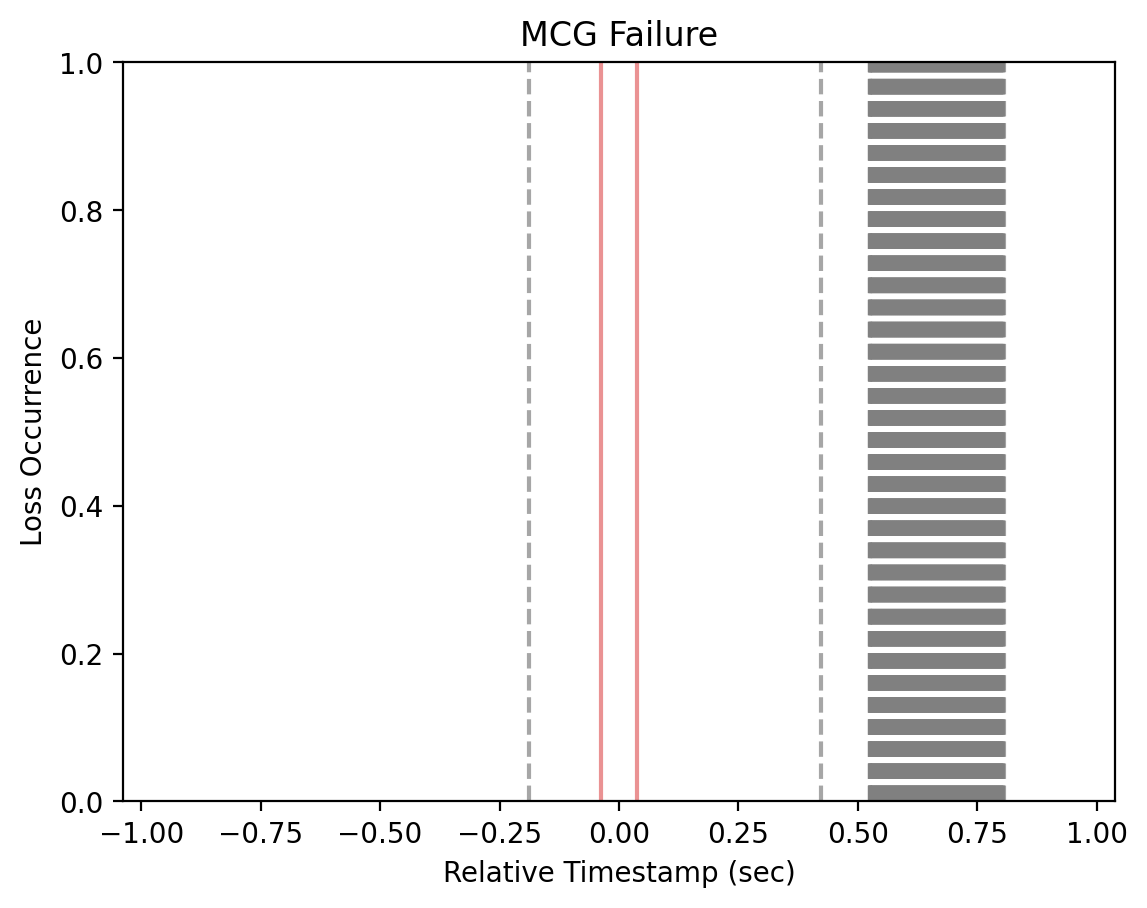

In [32]:
df = df_ho.query('ho_type == "MCG_Failure"').copy().reset_index(drop=True)
display(df)

idx = 0
start = df.at[idx, 'start']
end = df.at[idx, 'end']
midpoint = start + (end - start) / 2
print(start, end, midpoint, sep='\n')

sec = 1
intv = P.closed(start-pd.Timedelta(seconds=sec), end+pd.Timedelta(seconds=sec))

# df_ul.query('xmit_time >= @intv.lower & xmit_time <= @intv.upper')
# df_ul.query('xmit_time >= @intv.lower & xmit_time <= @intv.upper & lost == True')
# df_dl.query('arr_time >= @intv.lower & arr_time <= @intv.upper')
# df_dl.query('arr_time >= @intv.lower & arr_time <= @intv.upper & lost == True')

df_plot = df_dl.query('arr_time >= @intv.lower & arr_time <= @intv.upper & lost == True').copy().reset_index(drop=True)
df_plot['rel_time'] = (df_plot['arr_time'] - midpoint).dt.total_seconds()
df_plot

fig, ax = plt.subplots()
ax.set_xlim([(intv.lower-midpoint).total_seconds(), (intv.upper-midpoint).total_seconds()])
ax.set_title('MCG Failure')
for ts in df_plot['rel_time']:
    ax.axvline(ts, linestyle='--', color='gray', alpha=0.7)
ax.axvline((start-midpoint).total_seconds(), color='tab:red', alpha=0.5)
ax.axvline((end-midpoint).total_seconds(), color='tab:red', alpha=0.5)
ax.set_xlabel('Relative Timestamp (sec)')
ax.set_ylabel('Loss Occurrence')

plt.show()

start                        end   ho_type      intr  \
0 2023-04-01 15:22:22.786446 2023-04-01 15:22:22.824023  SN_Setup  0.037577   
1 2023-04-01 15:22:29.544480 2023-04-01 15:22:29.583170  SN_Setup  0.038690   

   sPCI  sFreq  tPCI  tFreq  snrPCI  tnrPCI cause           others  st_scel  \
0   130   1750  <NA>   <NA>    <NA>      11   NaN             <NA>        0   
1    11   3650  <NA>   <NA>    <NA>      11   NaN  Set up 1 SCell.        1   

   ePCI       ECI     eNB  BID  DL_Freq   DL_BW  UL_Freq   UL_BW  ePCI1  \
0   130  54303511  212123    3     1750  20 MHz    19750  20 MHz    130   
1    11  54547467  213076    8     3650  10 MHz    21650  10 MHz     11   

       ECI1    eNB1  BID1  DL_Freq1  DL_BW1  UL_Freq1  UL_BW1  nrPCI  nrFreq  \
0  54303511  212123     3      1750  20 MHz     19750  20 MHz    130  631000   
1  54547467  213076     8      3650  10 MHz     21650  10 MHz     11  631000   

   nrPCI1  nrFreq1                  Timestamp                   type_id  \
0      11   631000 2023-04-01 15:22:22.786446  RRC_OTA_Handover_Parsing   
1      11   631000 2023-04-01 15:22:29.544480  RRC_OTA_Handover_Parsing   

   ho_type0  
0  SN_Setup  
1  SN_Setup

2023-04-01 15:22:22.786446
2023-04-01 15:22:22.824023
2023-04-01 15:22:22.805234500


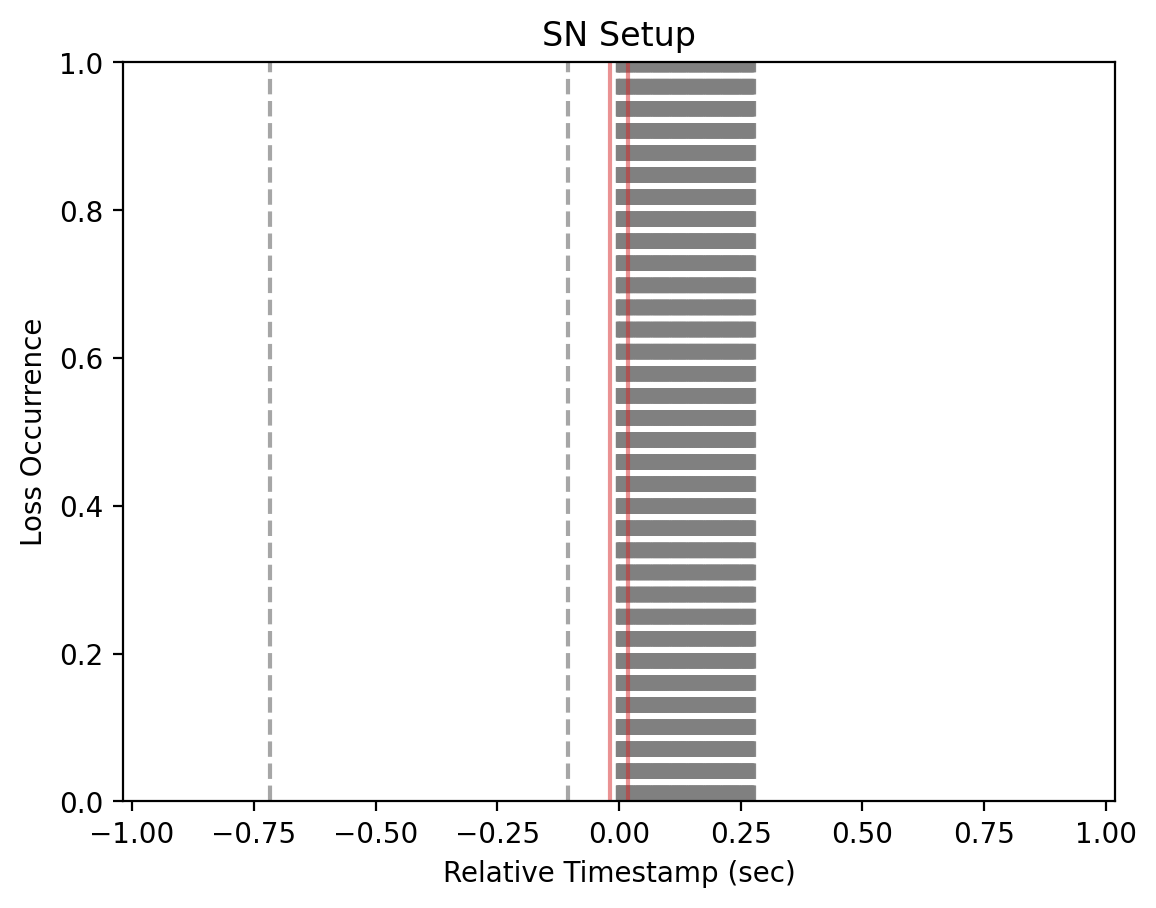

In [33]:
df = df_ho.query('ho_type == "SN_Setup"').copy().reset_index(drop=True)
display(df)

idx = 0
start = df.at[idx, 'start']
end = df.at[idx, 'end']
midpoint = start + (end - start) / 2
print(start, end, midpoint, sep='\n')

sec = 1
intv = P.closed(start-pd.Timedelta(seconds=sec), end+pd.Timedelta(seconds=sec))

# df_ul.query('xmit_time >= @intv.lower & xmit_time <= @intv.upper')
# df_ul.query('xmit_time >= @intv.lower & xmit_time <= @intv.upper & lost == True')
# df_dl.query('arr_time >= @intv.lower & arr_time <= @intv.upper')
# df_dl.query('arr_time >= @intv.lower & arr_time <= @intv.upper & lost == True')

df_plot = df_dl.query('arr_time >= @intv.lower & arr_time <= @intv.upper & lost == True').copy().reset_index(drop=True)
df_plot['rel_time'] = (df_plot['arr_time'] - midpoint).dt.total_seconds()
df_plot

fig, ax = plt.subplots()
ax.set_xlim([(intv.lower-midpoint).total_seconds(), (intv.upper-midpoint).total_seconds()])
ax.set_title('SN Setup')
for ts in df_plot['rel_time']:
    ax.axvline(ts, linestyle='--', color='gray', alpha=0.7)
ax.axvline((start-midpoint).total_seconds(), color='tab:red', alpha=0.5)
ax.axvline((end-midpoint).total_seconds(), color='tab:red', alpha=0.5)
ax.set_xlabel('Relative Timestamp (sec)')
ax.set_ylabel('Loss Occurrence')

plt.show()

In [34]:
def setup_profile(df, start, end, mode='ul', sec=1):
    if pd.notna(end):
        midpoint = start + (end - start) / 2
        intv = P.closed(start-pd.Timedelta(seconds=sec), end+pd.Timedelta(seconds=sec))
    else:
        midpoint = start
        intv = P.closed(start-pd.Timedelta(seconds=sec), start+pd.Timedelta(seconds=sec))
    
    # print(start, end, midpoint, sep='\n')
    # print(start, end, midpoint)
    
    if mode == 'ul':
        df_plot = df.query('xmit_time >= @intv.lower & xmit_time <= @intv.upper').copy().reset_index(drop=True)
        df_plot['rel_time'] = (df_plot['xmit_time'] - midpoint).dt.total_seconds()
    elif mode == 'dl':
        df_plot = df.query('arr_time >= @intv.lower & arr_time <= @intv.upper').copy().reset_index(drop=True)
        df_plot['rel_time'] = (df_plot['arr_time'] - midpoint).dt.total_seconds()
    else: # 'pyl'
        df_plot = df.query('Timestamp >= @intv.lower & Timestamp <= @intv.upper').copy().reset_index(drop=True)
        df_plot['rel_time'] = (df_plot['Timestamp'] - midpoint).dt.total_seconds()
    df_plot['cat_id'] = ((df_plot['rel_time'] + 0.005) // 0.01) * 0.01
    # display(df_plot)

    ts_group = df_plot.groupby(['cat_id'])
    table = ts_group['lost'].agg(['count','sum','mean']).copy().reset_index()
    table = table.rename(columns={'count':'tx_count', 'sum':'lost', 'mean':'PLR'})
    table['PLR'] = table['PLR'] * 100
    # display(table)
    return table, intv

def merge_profile(tables, intrs):
    intr = np.mean(intrs)
    table = pd.DataFrame(columns=['cat_id','tx_count','lost','PLR'])
    table['cat_id'] = table['cat_id'].astype('float32')
    table['tx_count'] = table['tx_count'].astype('Int32')
    table['lost'] = table['lost'].astype('Int32')
    table['PLR'] = table['PLR'].astype('float32')
    for i in range(len(tables)):
        _table = tables[i].copy()
        table = table.merge(_table, on=['cat_id'], how='outer').fillna(0)
        table['tx_count'] = table['tx_count_x'] + table['tx_count_y']
        table['lost'] = table['lost_x'] + table['lost_y']
        table['PLR'] = 0
        table = table[['cat_id','tx_count','lost','PLR']]
    table['PLR'] = table['lost'] / (table['tx_count'] + 1e-9) * 100
    table = table[['cat_id','tx_count','lost','PLR']].copy().sort_values(by=['cat_id']).reset_index(drop=True)
    return table, intr

def plot_profile(table, intr=0, title='', mode='lost'):
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.set_xlim(table.iat[0, table.columns.get_loc('cat_id')], table.iat[-1, table.columns.get_loc('cat_id')])
    # ax.set_xlim([(intv.lower-midpoint).total_seconds(), (intv.upper-midpoint).total_seconds()])
    if mode == 'lost':
        ax.bar(table['cat_id'], table['lost'], width=0.5)
        ax.set_ylabel('Lost Number')
    if mode == 'plr':
        ax.bar(table['cat_id'], table['PLR'], width=0.5)
        ax.set_ylabel('Packet Loss Rate (%)')
    intr /= 2
    # ax.axvline((start-midpoint).total_seconds(), color='tab:red', alpha=0.5)
    # ax.axvline((end-midpoint).total_seconds(), color='tab:red', alpha=0.5)
    ax.axvline(-intr, color='tab:red', alpha=0.5)
    ax.axvline(intr, color='tab:red', alpha=0.5)
    ax.set_xlabel('Relative Timestamp (sec)')
    plt.gcf().autofmt_xdate()
    plt.show()

start                        end      ho_type  \
0 2023-04-01 15:22:22.239022 2023-04-01 15:22:22.315842  MCG_Failure   
1 2023-04-01 15:22:29.147945 2023-04-01 15:22:29.222987  MCG_Failure   

       intr  sPCI  sFreq  tPCI  tFreq  snrPCI  tnrPCI             cause  \
0  0.076820   130   1750    22   <NA>       3    <NA>  otherFailure (2)   
1  0.075042    11   3650   130   <NA>      11    <NA>  otherFailure (2)   

  others  st_scel  ePCI       ECI     eNB  BID  DL_Freq   DL_BW  UL_Freq  \
0   <NA>        0   130  54303511  212123    3     1750  20 MHz    19750   
1   <NA>        0    11  54547467  213076    8     3650  10 MHz    21650   

    UL_BW  ePCI1      ECI1    eNB1  BID1  DL_Freq1  DL_BW1  UL_Freq1  UL_BW1  \
0  20 MHz    130  54303511  212123     3      1750  20 MHz     19750  20 MHz   
1  10 MHz     11  54547467  213076     8      3650  10 MHz     21650  10 MHz   

   nrPCI  nrFreq  nrPCI1  nrFreq1                  Timestamp  \
0      3  631000    <NA>     <NA> 2023-04-01 15:22:22.239022   
1     11  631000    <NA>     <NA> 2023-04-01 15:22:29.147945   

                    type_id                      ho_type0  
0  RRC_OTA_Handover_Parsing  MCG_Failure_otherFailure (2)  
1  RRC_OTA_Handover_Parsing  MCG_Failure_otherFailure (2)

0.075931


cat_id  tx_count  lost  PLR
0     -1.04       2.0     0  0.0
1     -1.03      10.0     0  0.0
2     -1.02      10.0     0  0.0
3     -1.01       6.0     0  0.0
4     -1.00      11.0     0  0.0
..      ...       ...   ...  ...
204    1.00       8.0     0  0.0
205    1.01      10.0     0  0.0
206    1.02       6.0     0  0.0
207    1.03       3.0     0  0.0
208    1.04       3.0     0  0.0

[209 rows x 4 columns]

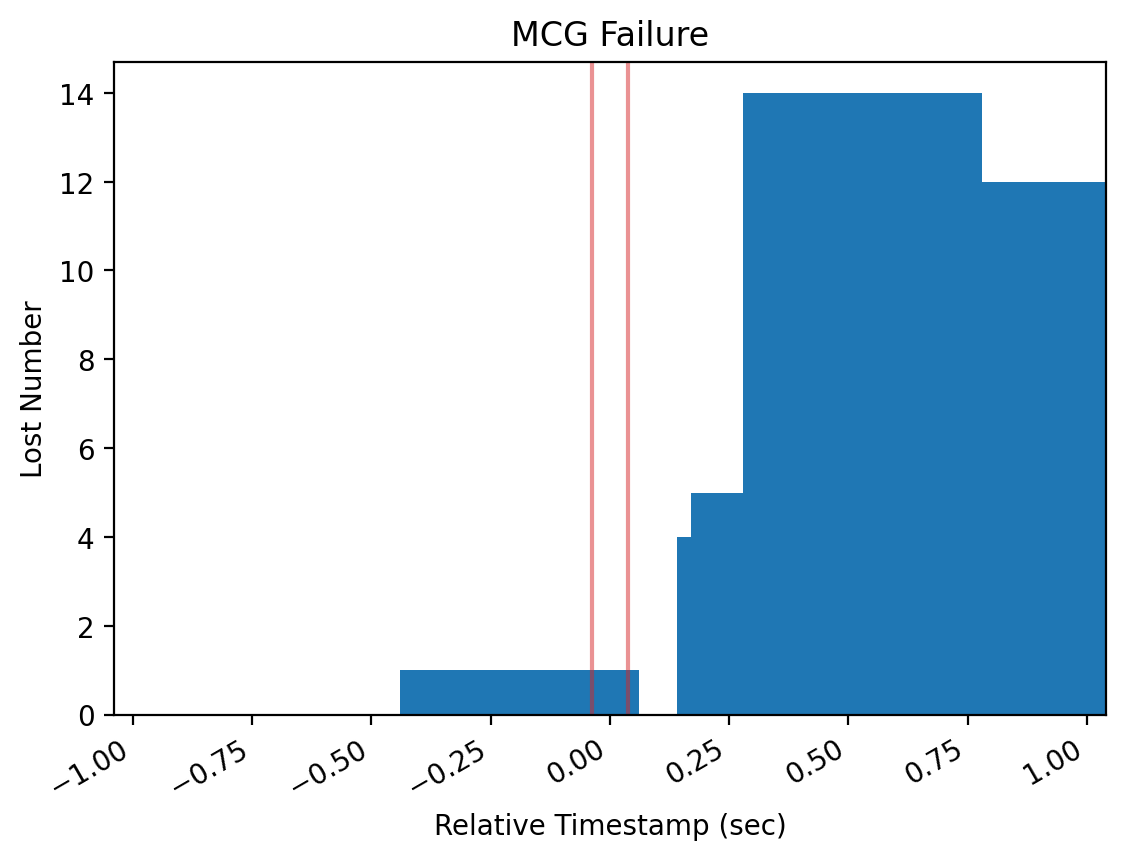

In [35]:
df = df_ho.query('ho_type == "MCG_Failure"').copy().reset_index(drop=True)
display(df)
tables = []
intrs = []
for i, row in df.iterrows():
    # display(df)
    start, end, intr = df.at[i, 'start'], df.at[i, 'end'], df.at[i, 'intr']
    table, intv = setup_profile(df_dl, start, end, mode='dl', sec=1)
    tables.append(table)
    intrs.append(intr)
    # plot_profile(table, intr=intr, title='MCG Failure')
table, intr = merge_profile(tables, intrs)
print(intr)
display(table)
plot_profile(table, intr=intr, title='MCG Failure')

MN_HO
Avg Duration: 0.016930167 seconds
HO Count: 24


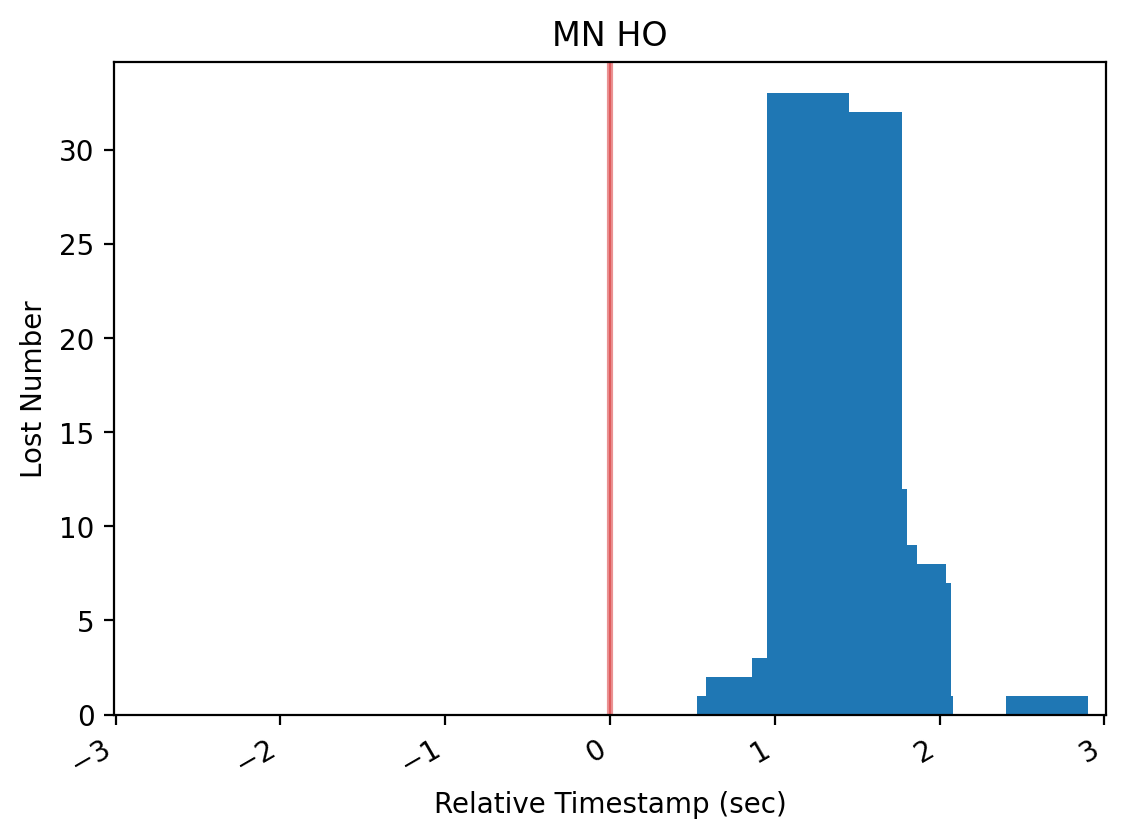

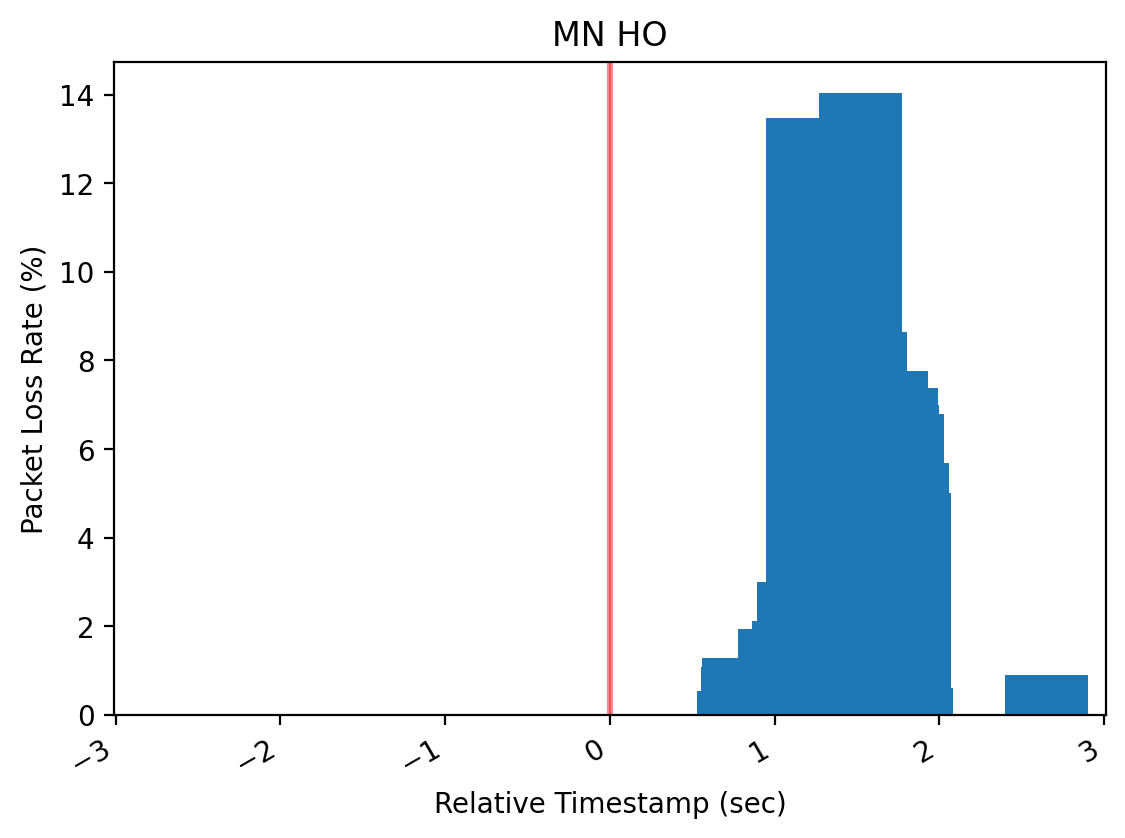

SN_HO
Avg Duration: 0.0146668125 seconds
HO Count: 16


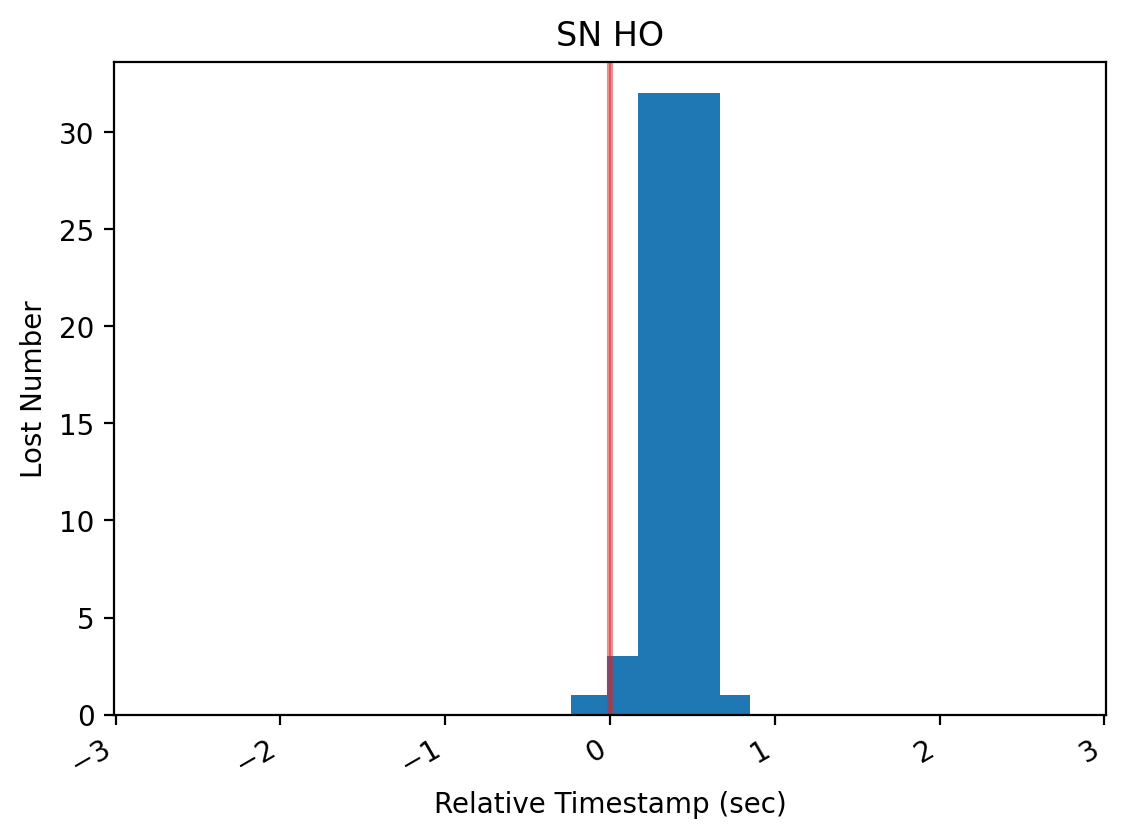

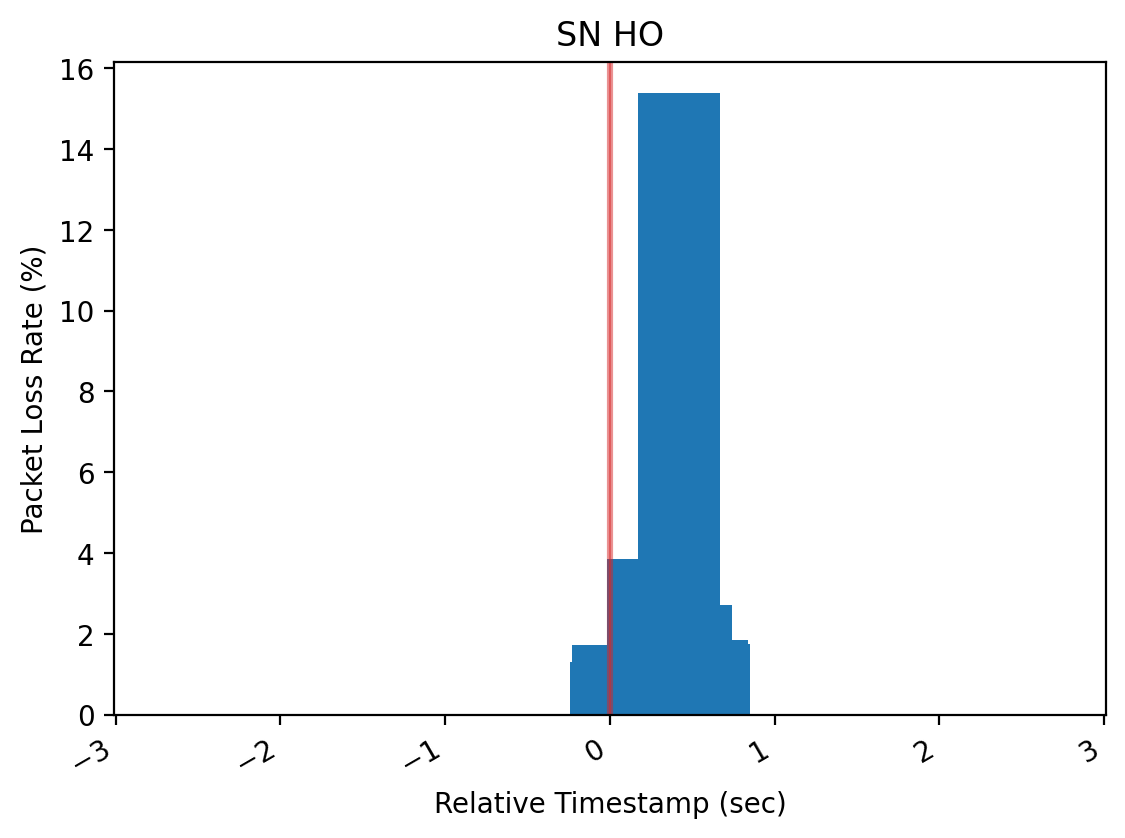

SN_Setup
Avg Duration: 0.038133502 seconds
HO Count: 2


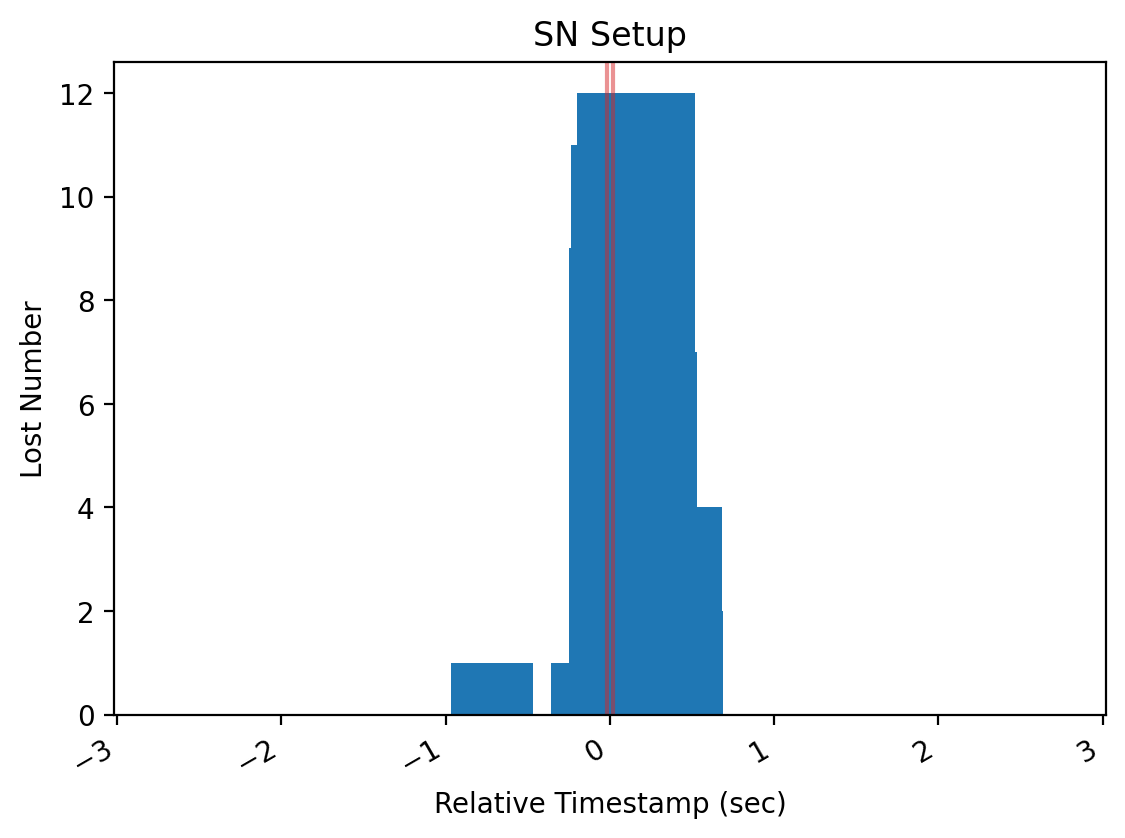

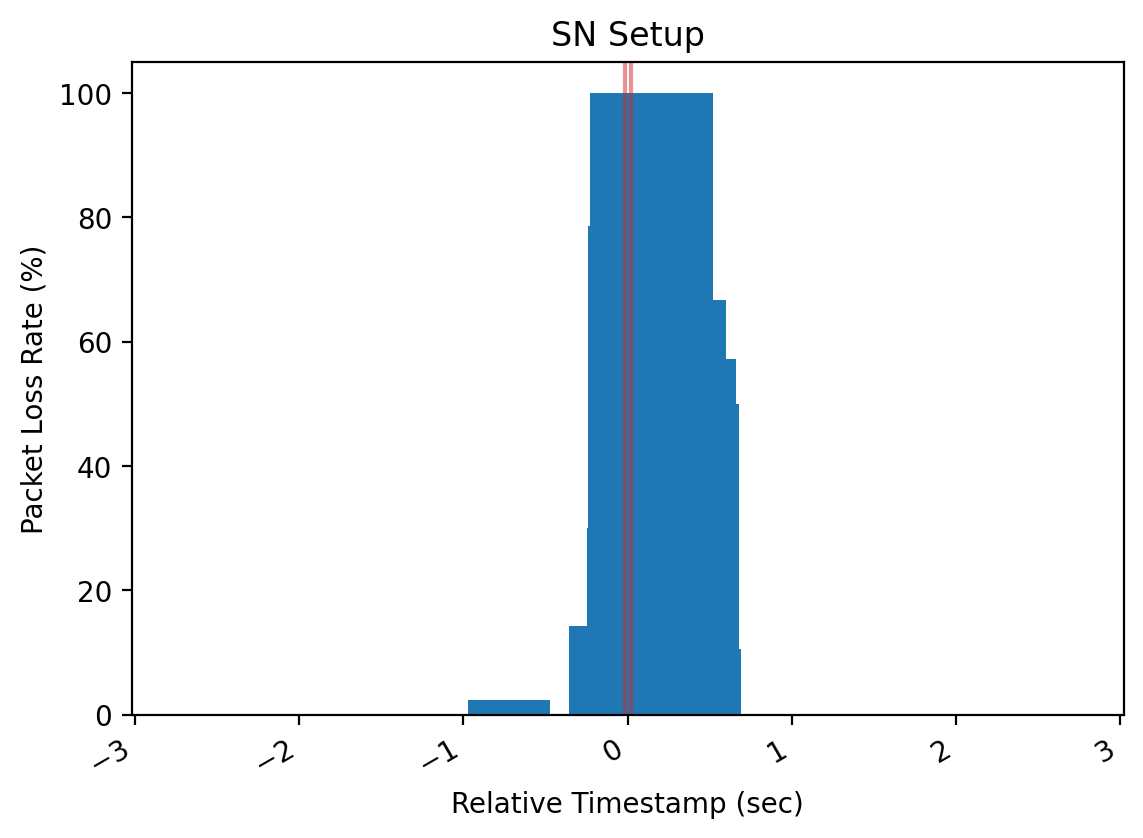

MCG_Failure_otherFailure (2)
Avg Duration: 0.075931 seconds
HO Count: 2


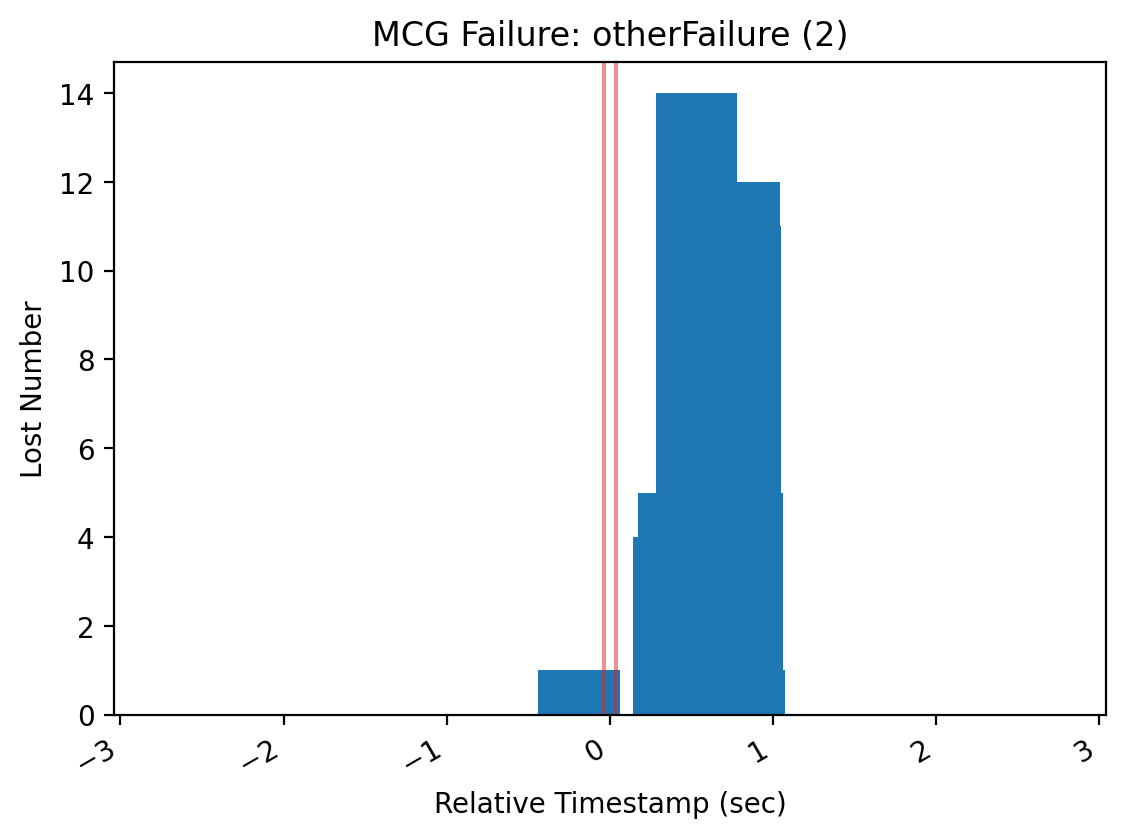

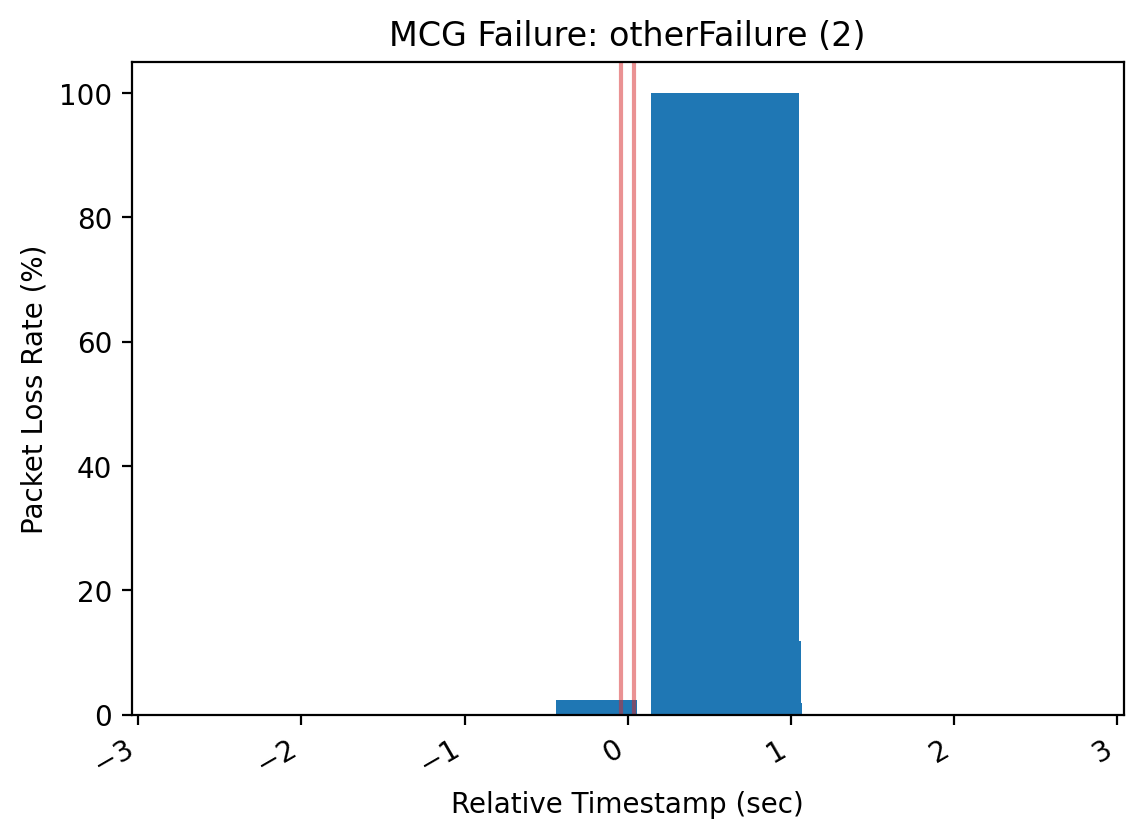

In [37]:
sorter = ['LTE_HO','MN_HO','SN_HO','MNSN_HO','SN_Rel','SN_Setup','SN_Rel_MN_HO','SN_Setup_MN_HO',
          'SCG_Failure_t310-Expiry (0)','SCG_Failure_randomAccessProblem (1)','SCG_Failure_rlc-MaxNumRetx (2)','SCG_Failure_synchReconfigFailureSCG (3)',
          'SCG_Failure_scg-ReconfigFailure (4)','SCG_Failure_srb3-IntegrityFailure (5)','SCG_Failure_other-r16 (6)',
          'MCG_Failure_reconfigurationFailure (0)','MCG_Failure_handoverFailure (1)','MCG_Failure_otherFailure (2)',
          'NAS_Recovery_reconfigurationFailure (0)','NAS_Recovery_handoverFailure (1)','NAS_Recovery_otherFailure (2)']

for tag in sorter:
    df = df_ho.query('ho_type0 == @tag').copy().reset_index(drop=True)
    if df.empty:
        continue
    print('===================================')
    print(tag)
    if not df.empty:
        cname = ' '.join(df.at[0, 'ho_type'].split('_')) + ': ' + df.at[0, 'cause'] if pd.notna(df.at[0, 'cause']) else ' '.join(df.at[0, 'ho_type'].split('_'))
        tables = []
        intrs = []
        for i, row in df.iterrows():
            start, end = df.at[i, 'start'], df.at[i, 'end']
            intr = df.at[i, 'intr'] if pd.notna(df.at[i, 'intr']) else 0
            table, intv = setup_profile(df_dl, start, end, mode='dl', sec=3)
            # print(intr)
            # display(table)
            tables.append(table)
            intrs.append(intr)
        table, intr = merge_profile(tables, intrs)
        print('Avg Duration:', intr, 'seconds')
        print('HO Count:', len(df))
        # display(table)
        plot_profile(table, intr=intr, title=cname, mode='lost')
        plot_profile(table, intr=intr, title=cname, mode='plr')
    else:
        table = pd.DataFrame(columns=['cat_id','tx_count','lost','PLR'])
        table['cat_id'] = table['cat_id'].astype('float32')
        table['tx_count'] = table['tx_count'].astype('Int32')
        table['lost'] = table['lost'].astype('Int32')
        table['PLR'] = table['PLR'].astype('float32')
        intr = 0

# Go

In [99]:
def setup_profile(df, start, end, mode='ul', sec=1):
    if pd.notna(end):
        midpoint = start + (end - start) / 2
        intv = P.closed(start-pd.Timedelta(seconds=sec), end+pd.Timedelta(seconds=sec))
    else:
        midpoint = start
        intv = P.closed(start-pd.Timedelta(seconds=sec), start+pd.Timedelta(seconds=sec))
    
    # print(start, end, midpoint, sep='\n')
    # print(start, end, midpoint)
    
    if mode == 'ul':
        df_plot = df.query('xmit_time >= @intv.lower & xmit_time <= @intv.upper').copy().reset_index(drop=True)
        df_plot['rel_time'] = (df_plot['xmit_time'] - midpoint).dt.total_seconds()
    elif mode == 'dl':
        df_plot = df.query('arr_time >= @intv.lower & arr_time <= @intv.upper').copy().reset_index(drop=True)
        df_plot['rel_time'] = (df_plot['arr_time'] - midpoint).dt.total_seconds()
    else: # 'pyl'
        df_plot = df.query('Timestamp >= @intv.lower & Timestamp <= @intv.upper').copy().reset_index(drop=True)
        df_plot['rel_time'] = (df_plot['Timestamp'] - midpoint).dt.total_seconds()
    df_plot['cat_id'] = ((df_plot['rel_time'] + 0.005) // 0.01) * 0.01
    # display(df_plot)

    ts_group = df_plot.groupby(['cat_id'])
    table = ts_group['lost'].agg(['count','sum','mean']).copy().reset_index()
    table = table.rename(columns={'count':'tx_count', 'sum':'lost', 'mean':'PLR'})
    table['PLR'] = table['PLR'] * 100
    # display(table)
    return table, intv

def merge_profile(tables, intrs):
    intr = np.mean(intrs)
    table = pd.DataFrame(columns=['cat_id','tx_count','lost','PLR'])
    table['cat_id'] = table['cat_id'].astype('float32')
    table['tx_count'] = table['tx_count'].astype('Int32')
    table['lost'] = table['lost'].astype('Int32')
    table['PLR'] = table['PLR'].astype('float32')
    for i in range(len(tables)):
        _table = tables[i].copy()
        table = table.merge(_table, on=['cat_id'], how='outer').fillna(0)
        table['tx_count'] = table['tx_count_x'] + table['tx_count_y']
        table['lost'] = table['lost_x'] + table['lost_y']
        table['PLR'] = 0
        table = table[['cat_id','tx_count','lost','PLR']]
    table['PLR'] = table['lost'] / (table['tx_count'] + 1e-9) * 100
    table = table[['cat_id','tx_count','lost','PLR']].copy().sort_values(by=['cat_id']).reset_index(drop=True)
    return table, intr

def plot_profile(table, intr=0, title='', mode='lost'):
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.set_title(title)
    ax.set_xlim(table.iat[0, table.columns.get_loc('cat_id')], table.iat[-1, table.columns.get_loc('cat_id')])
    # ax.set_xlim([(intv.lower-midpoint).total_seconds(), (intv.upper-midpoint).total_seconds()])
    if mode == 'lost':
        ax.bar(table['cat_id'], table['lost'], width=0.5)
        ax.set_ylabel('Lost Number')
    if mode == 'plr':
        ax.bar(table['cat_id'], table['PLR'], width=0.5)
        ax.set_ylabel('Packet Loss Rate (%)')
        ax.set_ylim(top=105)
    intr /= 2
    # ax.axvline((start-midpoint).total_seconds(), color='tab:red', alpha=0.5)
    # ax.axvline((end-midpoint).total_seconds(), color='tab:red', alpha=0.5)
    ax.axvline(-intr, color='tab:red', alpha=0.5)
    ax.axvline(intr, color='tab:red', alpha=0.5)
    ax.set_xlabel('Relative Timestamp (sec)')
    plt.gcf().autofmt_xdate()
    plt.show()

def plot_intrs(data, tag):
    data = [s*1000 for s in data]
    
    # Plot the violin plot
    fig, ax = plt.subplots(figsize=(6, 1.5))
    ax.violinplot(data, positions=None, vert=False, quantiles=[0.25, 0.5, 0.75])

    # Calculate and plot the mean and median values
    mean = np.mean(data)
    ax.axvline(mean, color='r', linestyle='--', label='Mean')
    ax.text(mean, 0.58, '{:.1f}'.format(mean), ha='center', fontweight='bold', fontsize=10, color='r')
    ax.set_xlim(left=0)
    ax.set_yticks([])
    ax.set_title(tag)
    ax.set_xlabel('Handover Interruption Time (ms)')

    # Add legend and title
    ax.legend()
    
    # Show the plot
    plt.show()

## Downlink

### Read Data

In [100]:
datadir = "/Users/jackbedford/Desktop/MOXA/Code/data"
exps = {
    ## Uplink
    # "2023-03-15/_Bandlock_Udp_B1_B3_B7_B8_RM500Q": [*['#{:02d}'.format(i+1) for i in range(1, 4)], '#06'],
    # "2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q": ['#{:02d}'.format(i+1) for i in range(12)],
    # "2023-04-01/_Bandlock_Udp_B1_B3_B7_B8_RM500Q": ['#{:02d}'.format(i+1) for i in range(6)],
    # "2023-04-01/_Bandlock_Udp_All_LTE_B1B3_B1B8_RM500Q": ['#{:02d}'.format(i+1) for i in range(4)],
    ## Downlink
    "2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q": ['#{:02d}'.format(i+1) for i in range(16)],
    "2023-04-01/_Bandlock_Udp_B1_B3_B7_B8_RM500Q": ['#{:02d}'.format(i+1) for i in range(6)],
    "2023-04-01/_Bandlock_Udp_All_LTE_B1B3_B1B8_RM500Q": ['#{:02d}'.format(i+1) for i in range(4)],
}
_devices = [
    # ['qc00','qc02','qc03'],
    ['qc00','qc02','qc03'],
    ['qc00','qc01','qc02','qc03'],
    ['qc00','qc01','qc02','qc03'],
]
_schemes = [
    # ['B1','B7','B8'],
    ['B1','B7','B8'],
    ['B1','B3','B7','B8'],
    ['B1B3','B1B8','LTE','All'],
]

# dfs_dl = []
# for (exp, traces), devices, schemes in zip(exps.items(), _devices, _schemes):
#     for trace in traces:
#         for j, (dev, schm) in enumerate(zip(devices, schemes)):
#             data = os.path.join(datadir, exp, dev, trace, 'data', 'udp_dnlk_loss_latency.csv')
#             print(data, os.path.isfile(data))
#             df = pd.read_csv(data)
#             df = set_data(df)
#             # dfs_dl.append(DF(data, df.copy()))
#             dfs_dl.append(DF(data, None))
# print(len(dfs_dl))

# dfs_ho = []
# for (exp, traces), devices, schemes in zip(exps.items(), _devices, _schemes):
#     for trace in traces:
#         for j, (dev, schm) in enumerate(zip(devices, schemes)):
#             path = os.path.join(datadir, exp, dev, trace, 'data')
#             data = os.path.join(path, [s for s in os.listdir(path) if s.startswith('diag_log_') and s.endswith('_rrc.csv')][0])
#             print(data, os.path.isfile(data))
#             df = pd.read_csv(data)
#             df, _, _ = mi_parse_ho(df, tz=8)
#             df['ho_type0'] = df['ho_type'].astype('string')
#             df.loc[df['cause'].notna(), 'ho_type0'] = df['ho_type'].astype('string') + '_' + df['cause'].astype('string')
#             df['ho_type0'] = df['ho_type0'].astype('category')
#             # dfs_ho.append(DF(data, df.copy()))
#             dfs_ho.append(DF(data, None))
# print(len(dfs_ho))

### Arrival Time

In [101]:
sorter = ['LTE_HO','MN_HO','SN_HO','MNSN_HO','SN_Rel','SN_Setup','SN_Rel_MN_HO','SN_Setup_MN_HO',
          'SCG_Failure_t310-Expiry (0)','SCG_Failure_randomAccessProblem (1)','SCG_Failure_rlc-MaxNumRetx (2)','SCG_Failure_synchReconfigFailureSCG (3)',
          'SCG_Failure_scg-ReconfigFailure (4)','SCG_Failure_srb3-IntegrityFailure (5)','SCG_Failure_other-r16 (6)',
          'MCG_Failure_reconfigurationFailure (0)','MCG_Failure_handoverFailure (1)','MCG_Failure_otherFailure (2)',
          'NAS_Recovery_reconfigurationFailure (0)','NAS_Recovery_handoverFailure (1)','NAS_Recovery_otherFailure (2)']

D = {}
for tag in sorter:
    D[tag] = {'tables': [], 'intrs': [], 'count': []}

for (exp, traces), devices, schemes in zip(exps.items(), _devices, _schemes):
    for trace in traces:
        for j, (dev, schm) in enumerate(zip(devices, schemes)):
            ## read downlink
            data = os.path.join(datadir, exp, dev, trace, 'data', 'udp_dnlk_loss_latency.csv')
            print(data, os.path.isfile(data))
            df_dl = pd.read_csv(data)
            df_dl = set_data(df_dl)
            ## read handover
            path = os.path.join(datadir, exp, dev, trace, 'data')
            data = os.path.join(path, [s for s in os.listdir(path) if s.startswith('diag_log_') and s.endswith('_rrc.csv')][0])
            print(data, os.path.isfile(data))
            df_ho = pd.read_csv(data)
            df_ho, _, _ = mi_parse_ho(df_ho, tz=8)
            df_ho['ho_type0'] = df_ho['ho_type'].astype('string')
            df_ho.loc[df_ho['cause'].notna(), 'ho_type0'] = df_ho['ho_type'].astype('string') + '_' + df_ho['cause'].astype('string')
            df_ho['ho_type0'] = df_ho['ho_type0'].astype('category')
            ## start processing
            for tag in sorter:
                # print('===================================')
                # print(tag)
                df = df_ho.query('ho_type0 == @tag').copy().reset_index(drop=True)
                tables = []
                intrs = []
                if not df.empty:
                    cname = ' '.join(df.at[0, 'ho_type'].split('_')) + ': ' + df.at[0, 'cause'] if pd.notna(df.at[0, 'cause']) else ' '.join(df.at[0, 'ho_type'].split('_'))
                    for i, row in df.iterrows():
                        start, end = df.at[i, 'start'], df.at[i, 'end']
                        intr = df.at[i, 'intr'] if pd.notna(df.at[i, 'intr']) else 0
                        table, intv = setup_profile(df_dl, start, end, mode='dl', sec=10)
                        # print(intr)
                        # display(table)
                        tables.append(table)
                        intrs.append(intr)
                    table, intr = merge_profile(tables, intrs)
                    # print('Avg Duration:', intr, 'seconds')
                    # display(table)
                    # plot_profile(table, intr=intr, title=cname, mode='lost')
                    # plot_profile(table, intr=intr, title=cname, mode='plr')
                else:
                    table = pd.DataFrame(columns=['cat_id','tx_count','lost','PLR'])
                    table['cat_id'] = table['cat_id'].astype('float32')
                    table['tx_count'] = table['tx_count'].astype('Int32')
                    table['lost'] = table['lost'].astype('Int32')
                    table['PLR'] = table['PLR'].astype('float32')
                    intr = 0
                # print('HO Count:', len(df))
                D[tag]['tables'].append(table)
                D[tag]['intrs'] = [*D[tag]['intrs'], *intrs]
                D[tag]['count'].append(len(df))

/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#01/data/udp_dnlk_loss_latency.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#01/data/diag_log_qc00_2023-03-16_19-23-29_rrc.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc02/#01/data/udp_dnlk_loss_latency.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc02/#01/data/diag_log_qc02_2023-03-16_19-23-29_rrc.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc03/#01/data/udp_dnlk_loss_latency.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc03/#01/data/diag_log_qc03_2023-03-16_19-23-29_rrc.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#02/data/udp_dnlk_loss_latency.csv True
/Users/jackbedford/Desktop/MOXA/Cod

LTE_HO
Avg Duration: 0.030064277 seconds
HO Count: 156


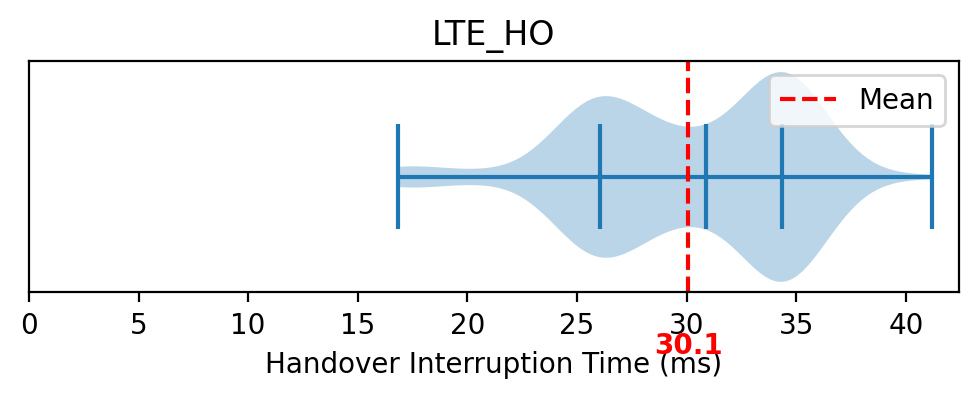

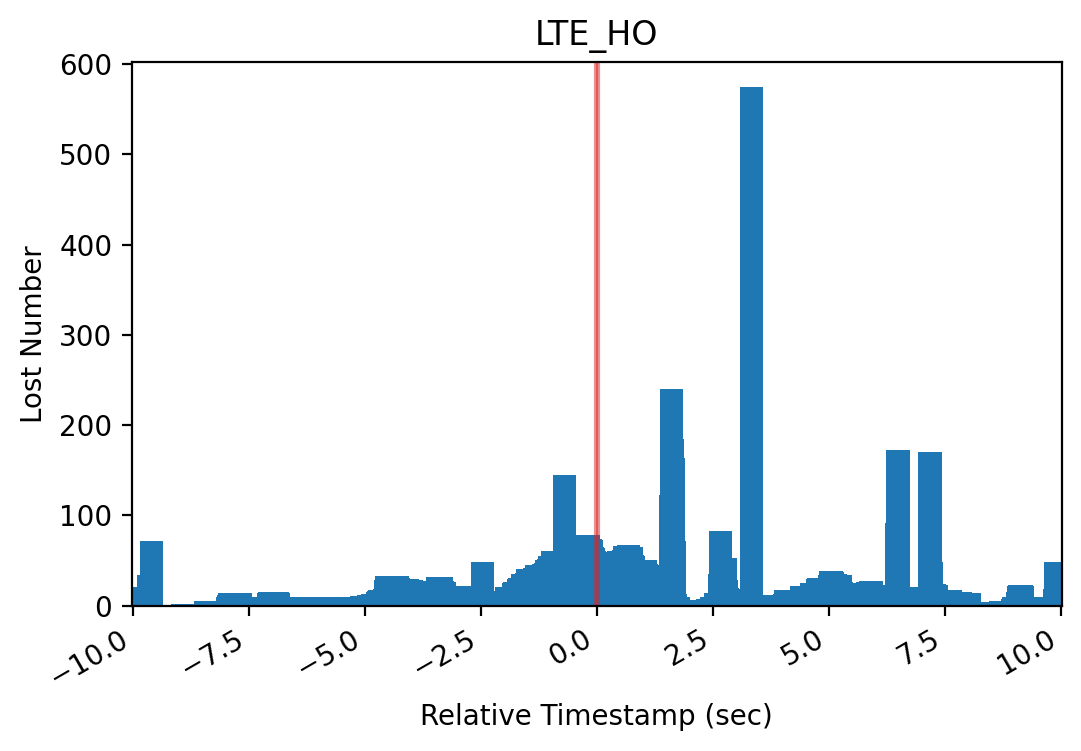

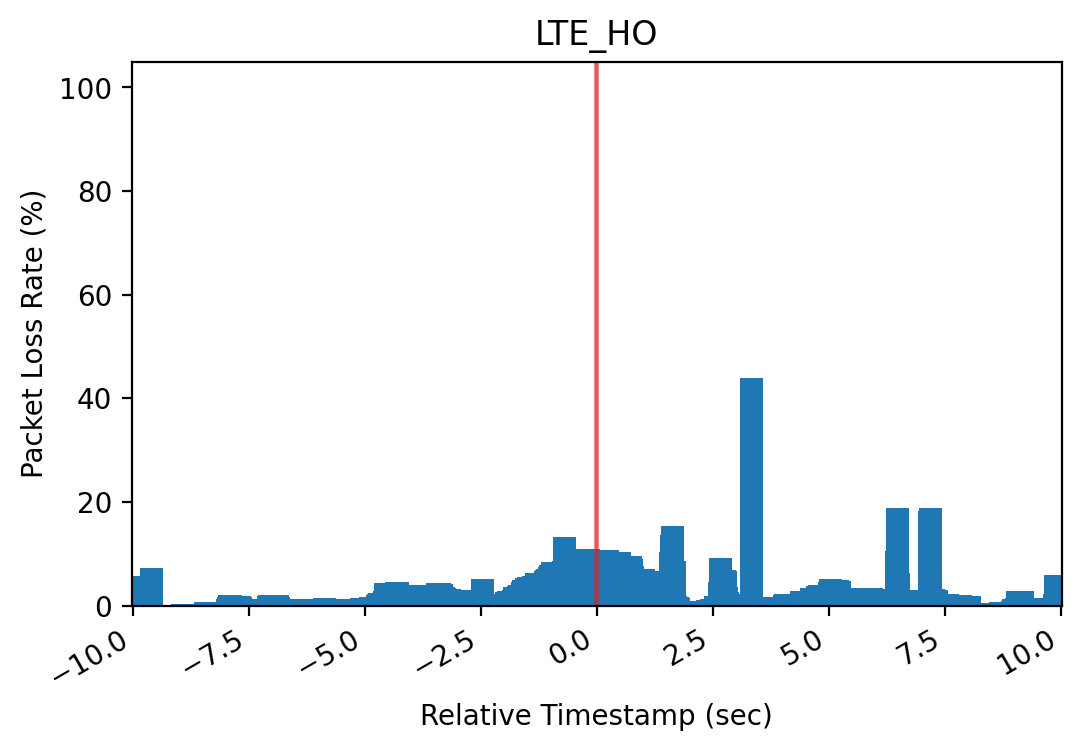

MN_HO
Avg Duration: 0.01831815 seconds
HO Count: 1031


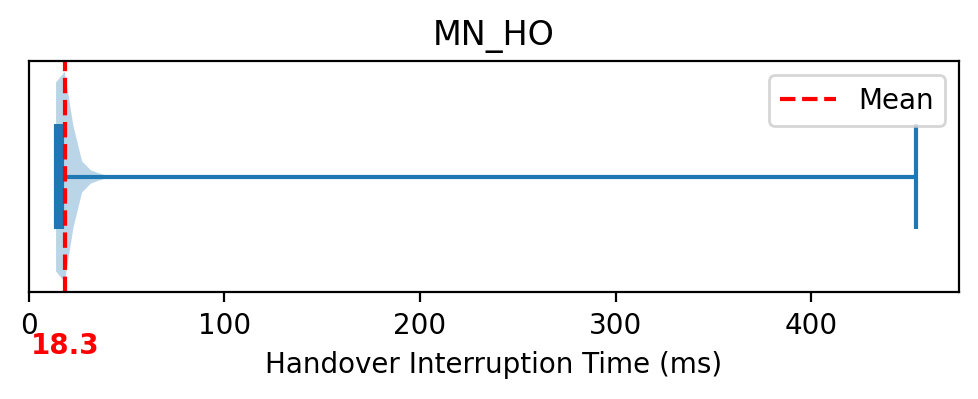

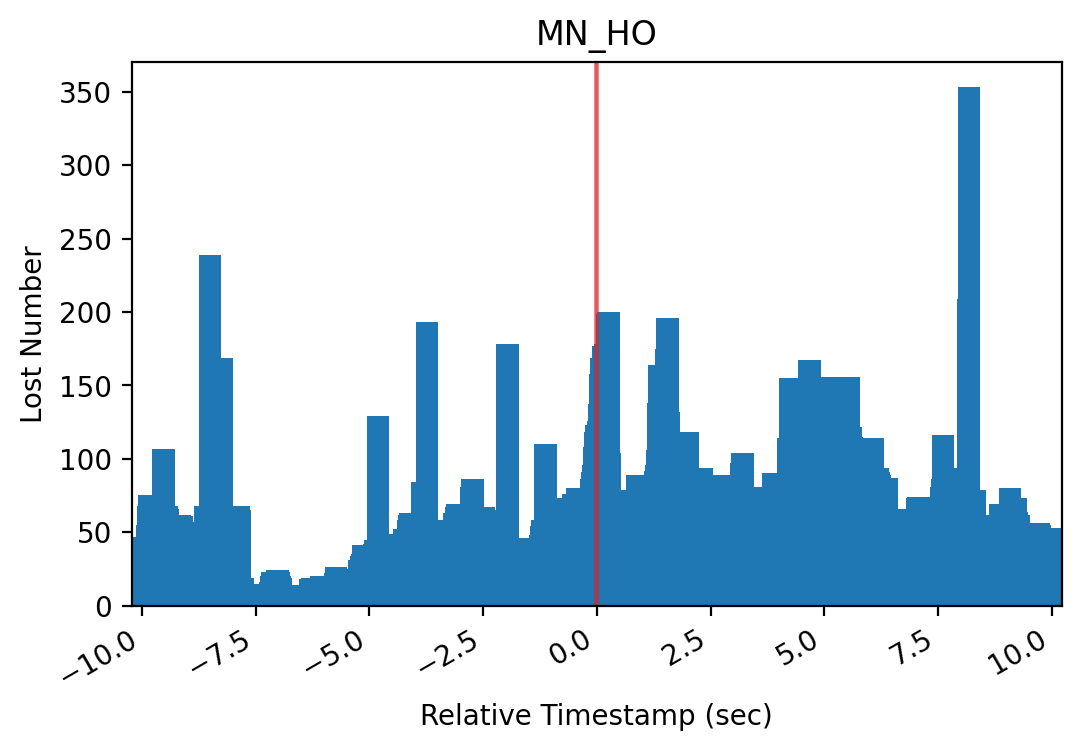

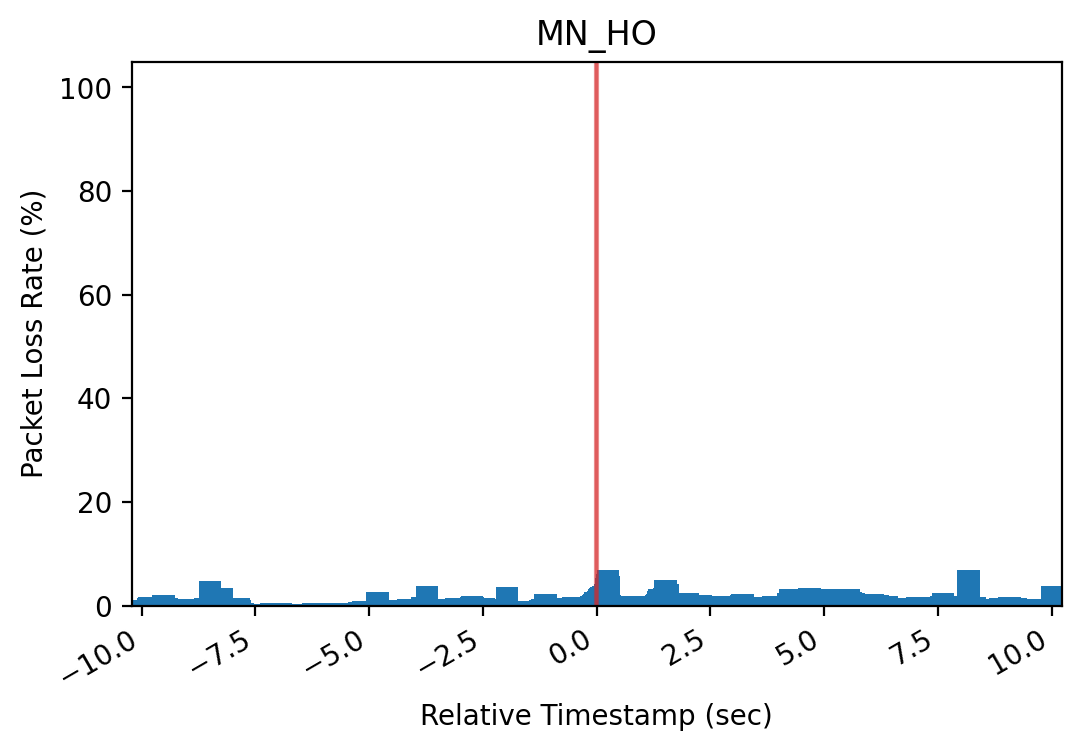

SN_HO
Avg Duration: 0.014631635 seconds
HO Count: 1088


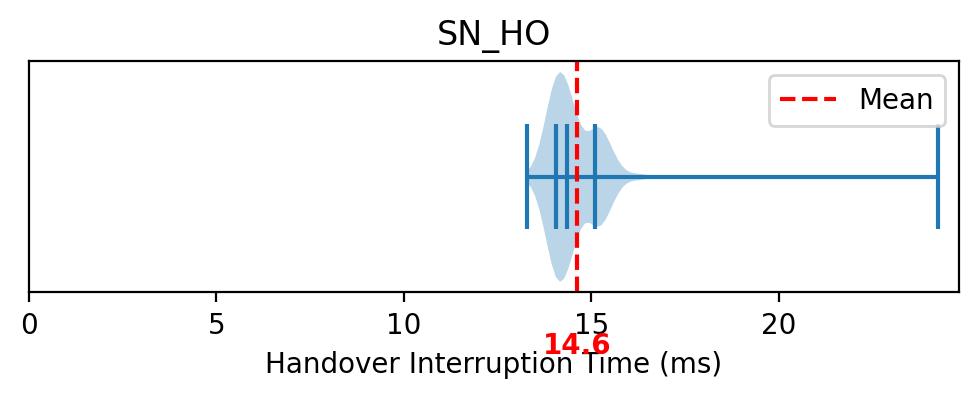

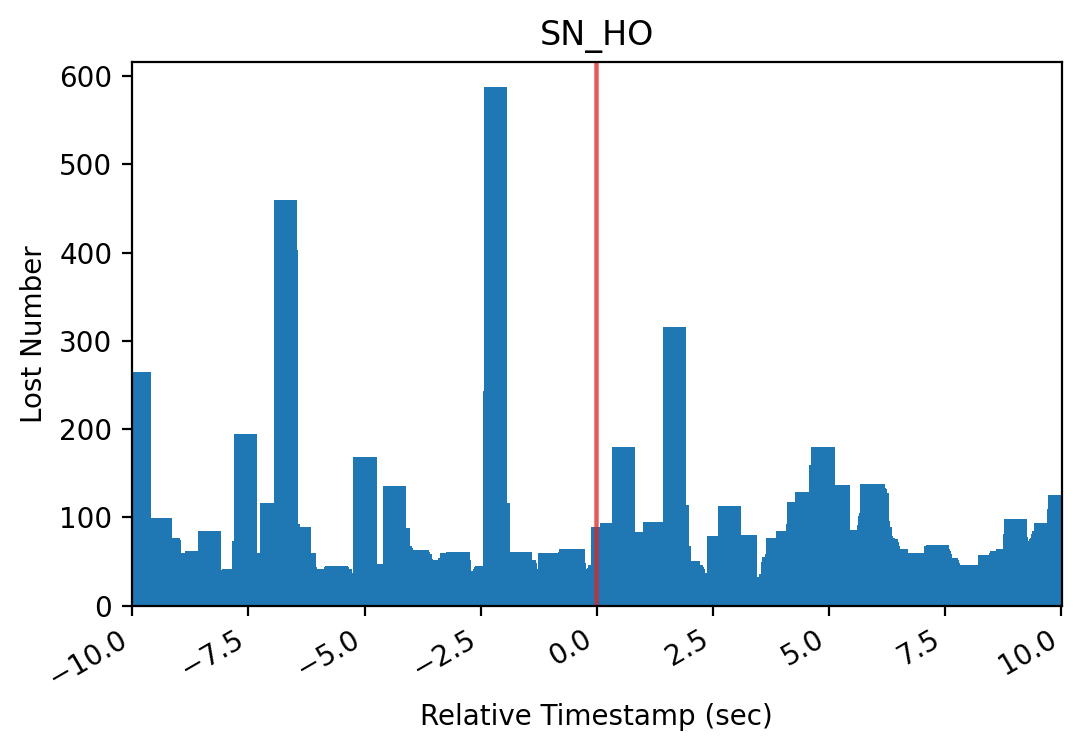

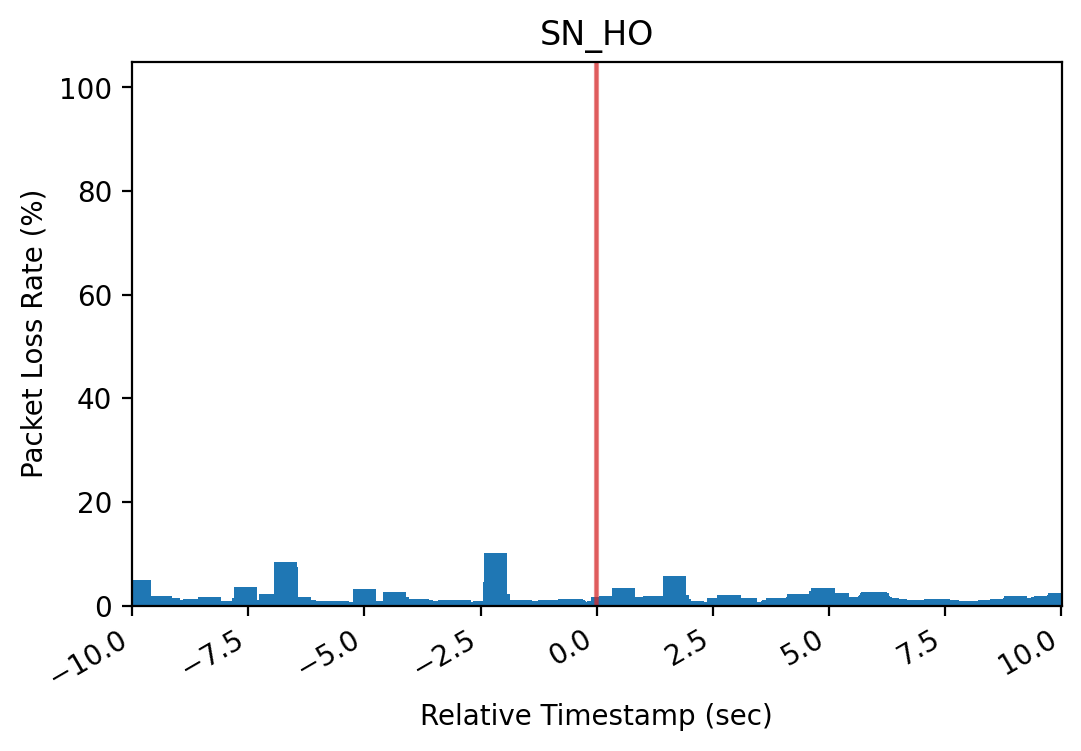

SN_Rel
Avg Duration: 0.02582325 seconds
HO Count: 8


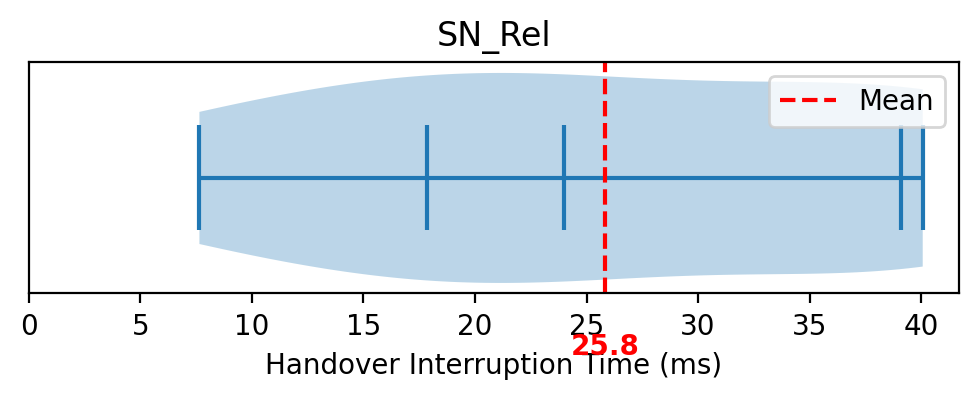

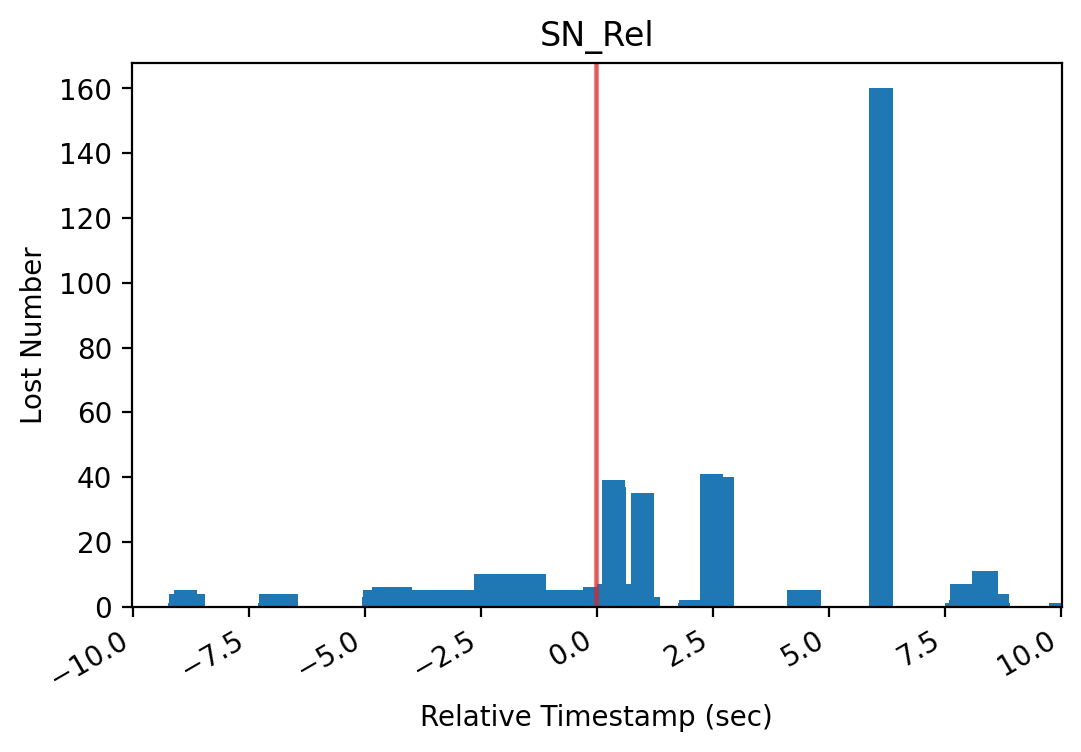

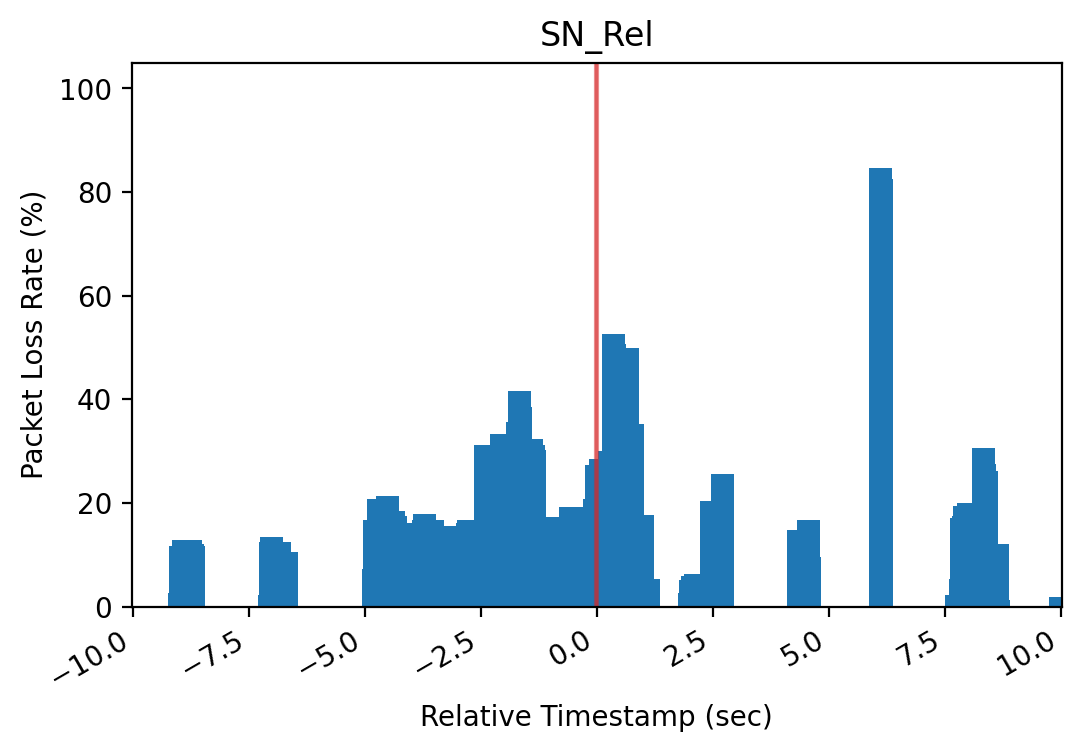

SN_Setup
Avg Duration: 0.028006215 seconds
HO Count: 278


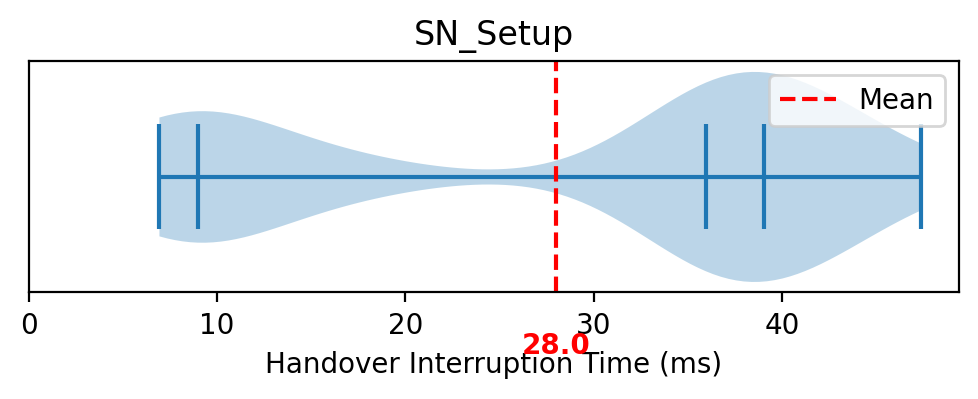

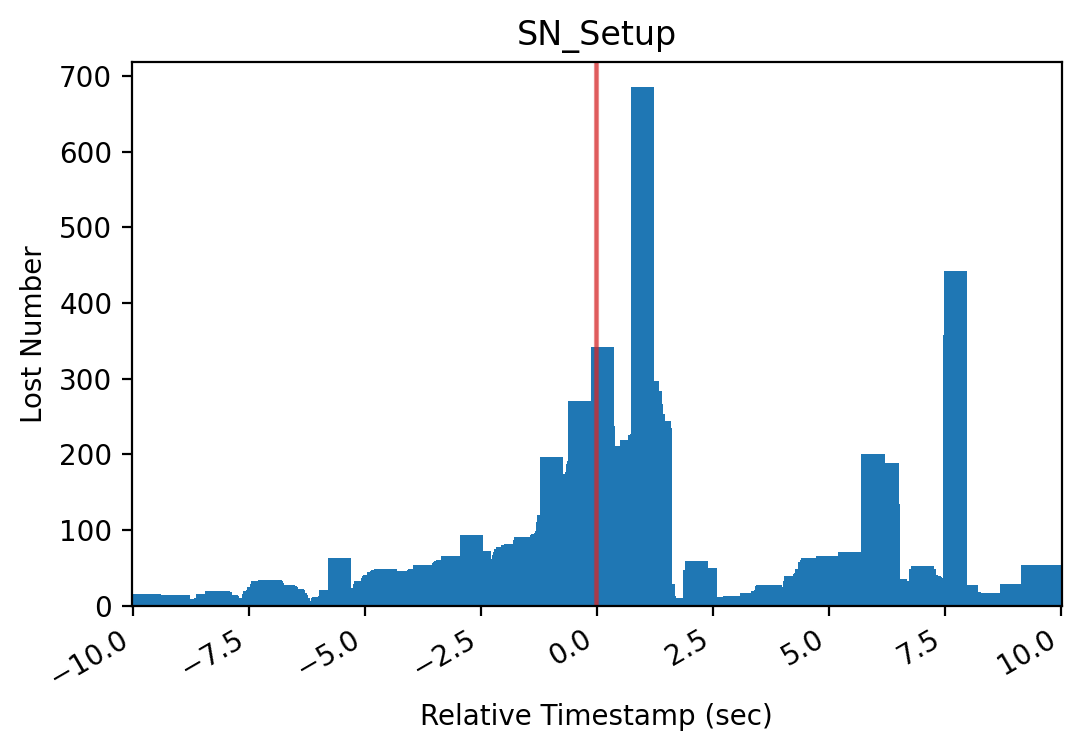

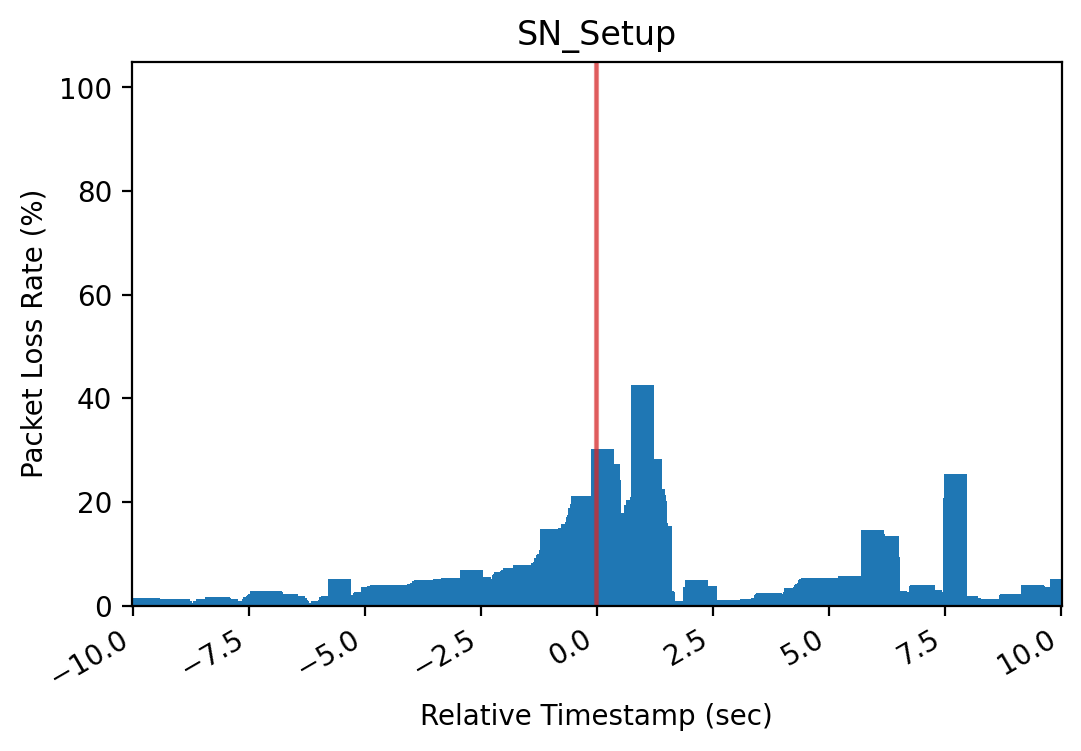

SN_Rel_MN_HO
Avg Duration: 0.016545204 seconds
HO Count: 416


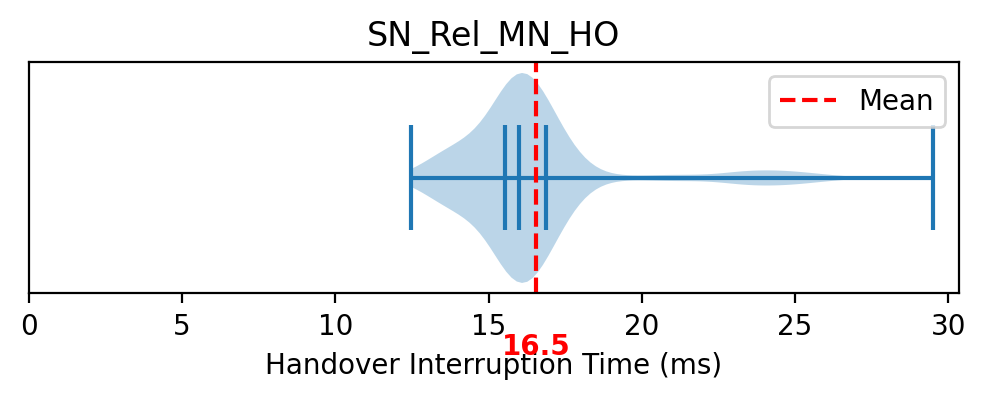

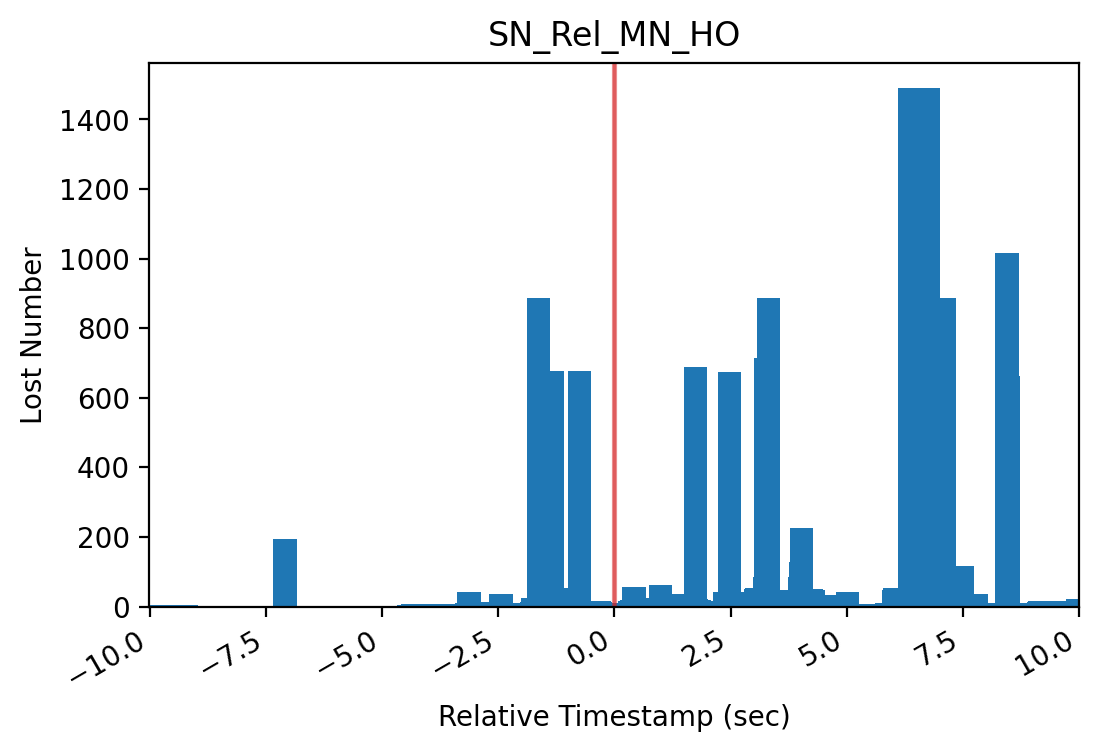

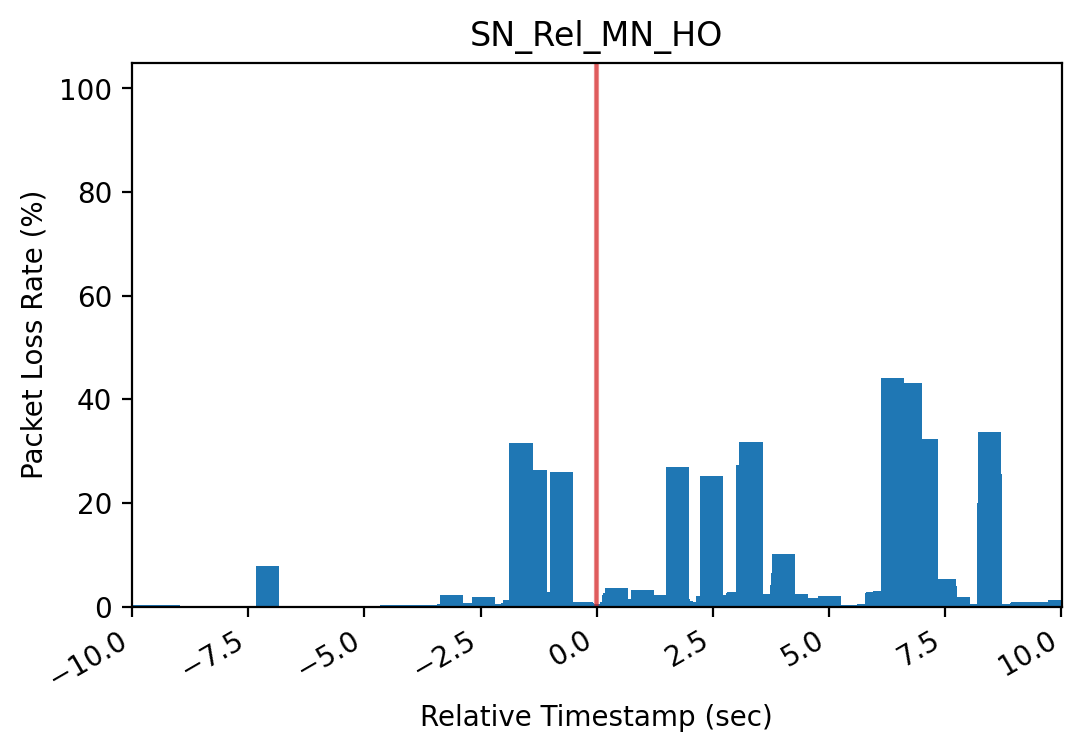

SCG_Failure_t310-Expiry (0)
Avg Duration: 0.0 seconds
HO Count: 3


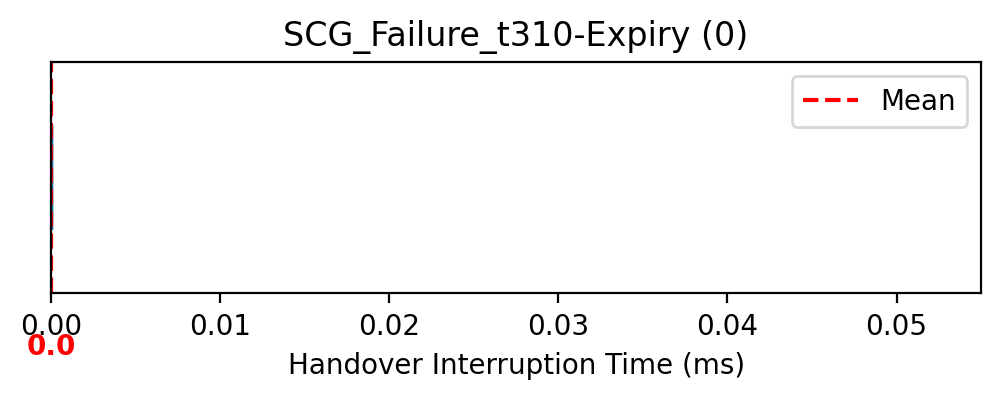

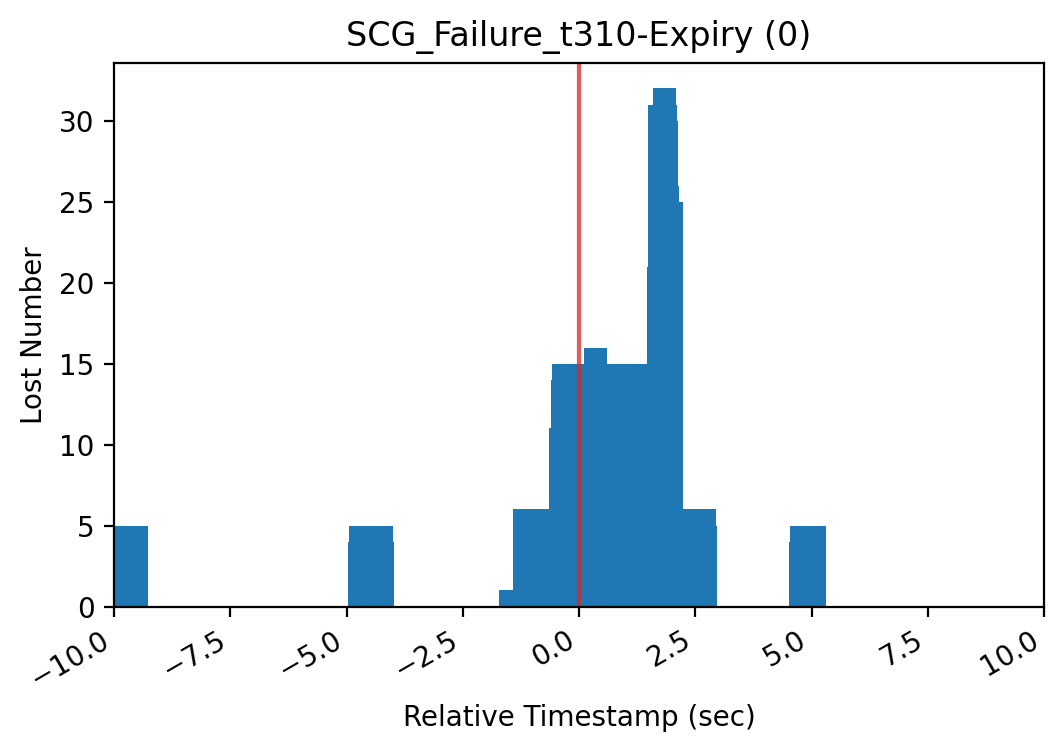

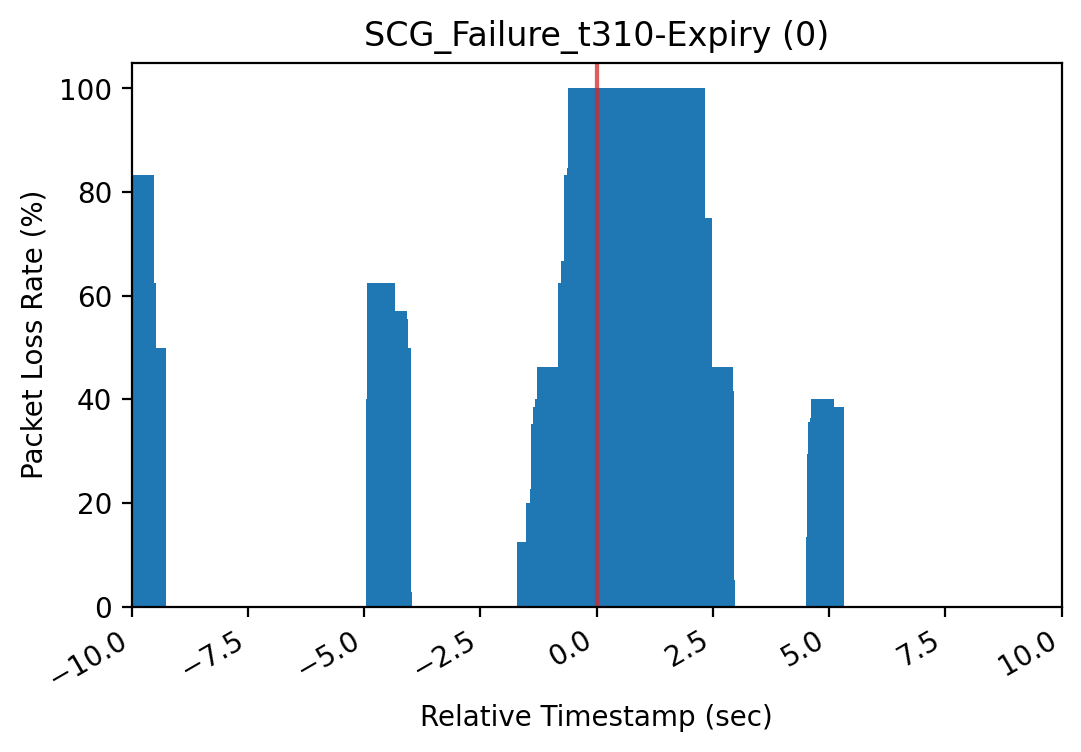

SCG_Failure_synchReconfigFailureSCG (3)
Avg Duration: 0.0 seconds
HO Count: 5


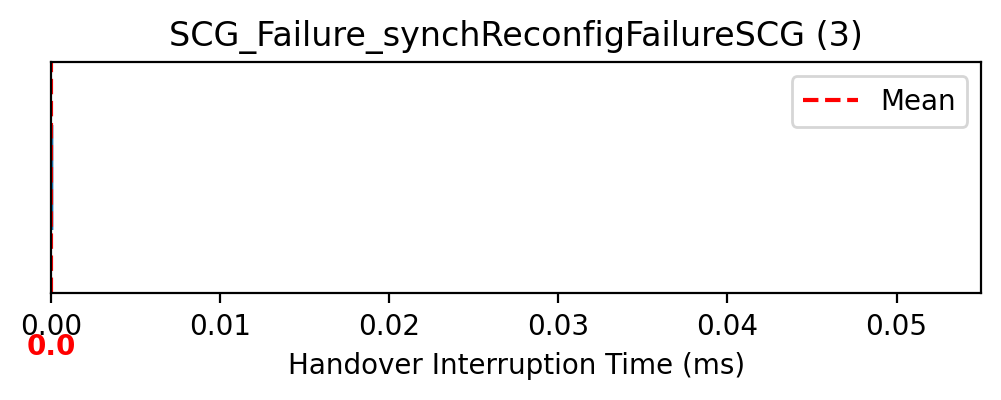

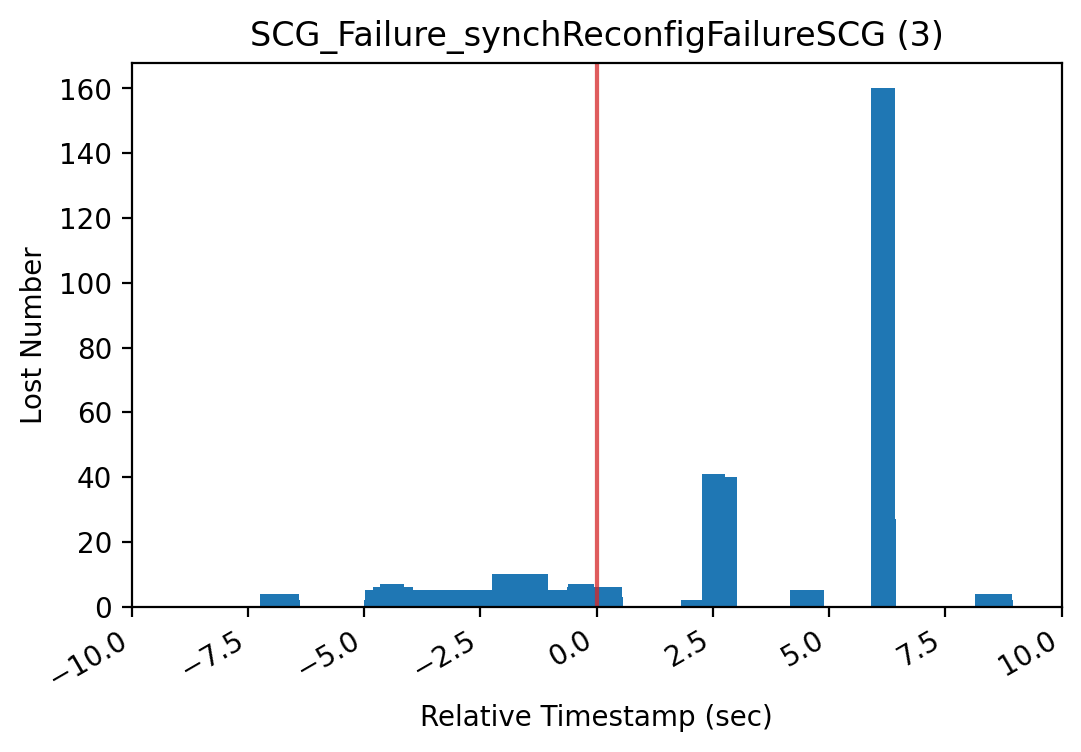

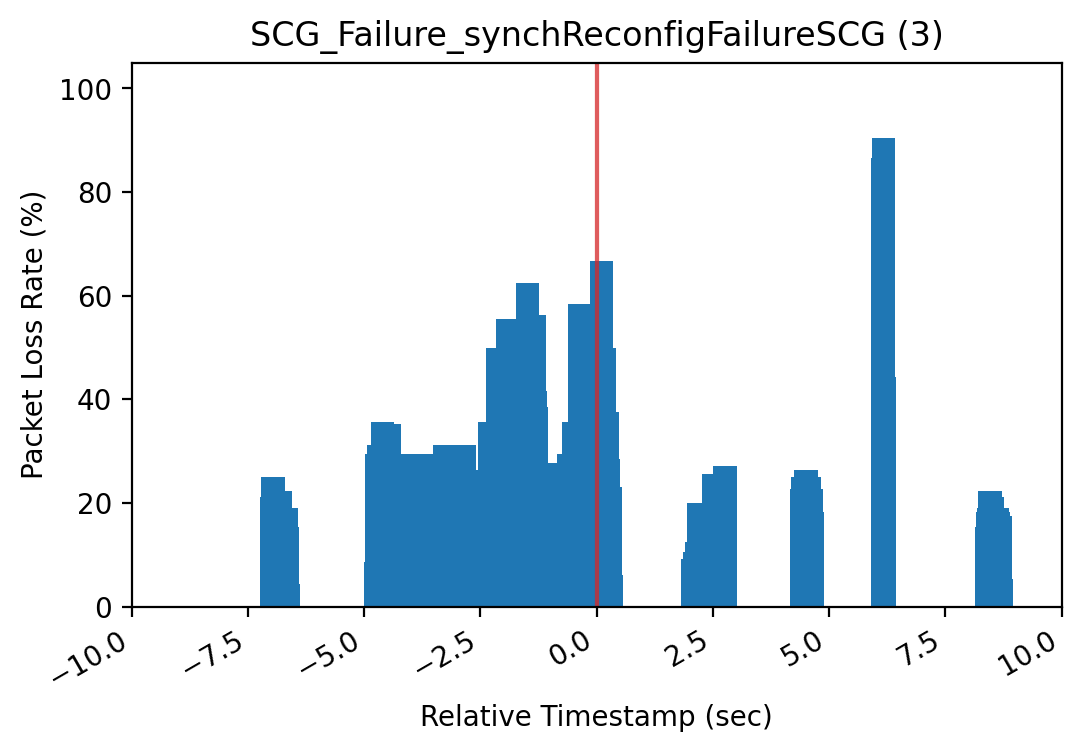

MCG_Failure_handoverFailure (1)
Avg Duration: 0.0821011 seconds
HO Count: 11


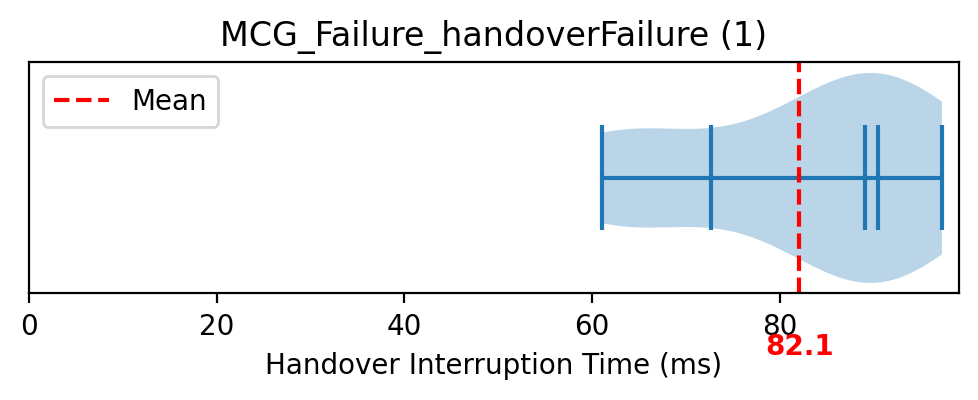

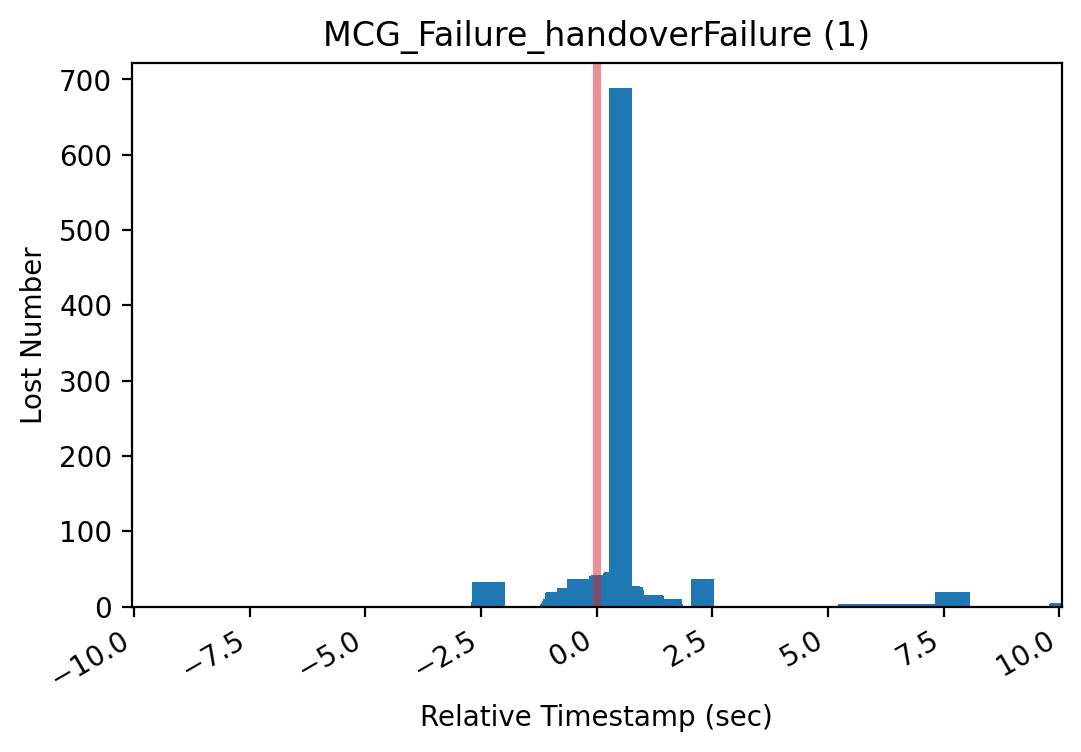

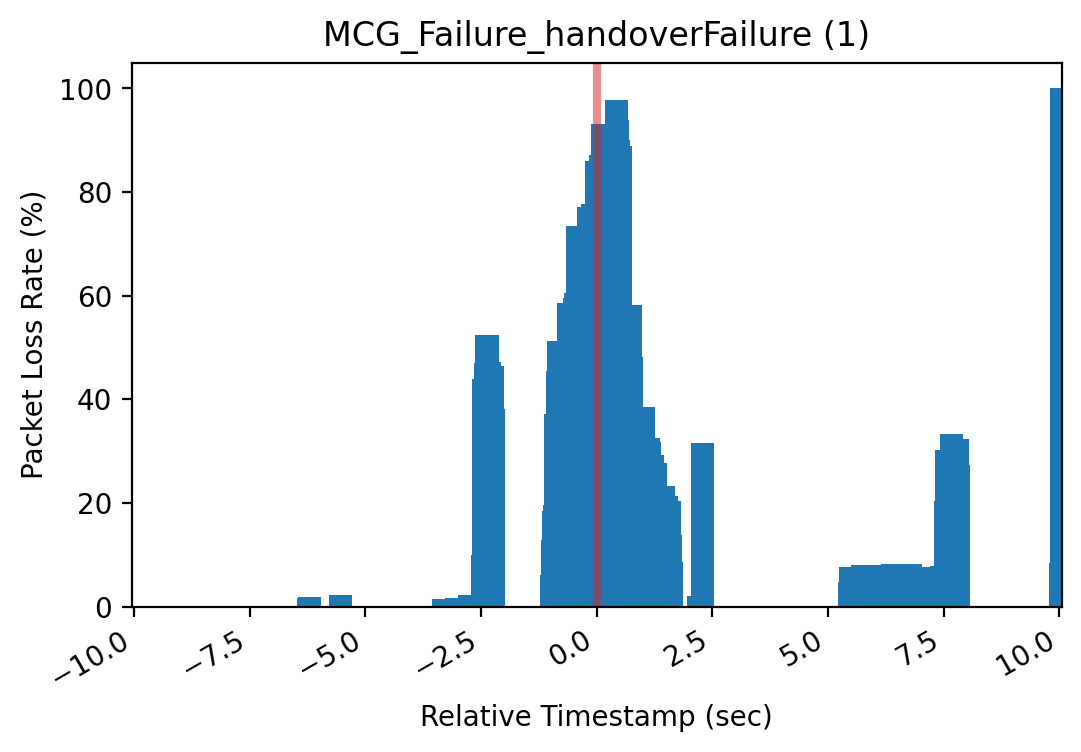

MCG_Failure_otherFailure (2)
Avg Duration: 0.07658415 seconds
HO Count: 117


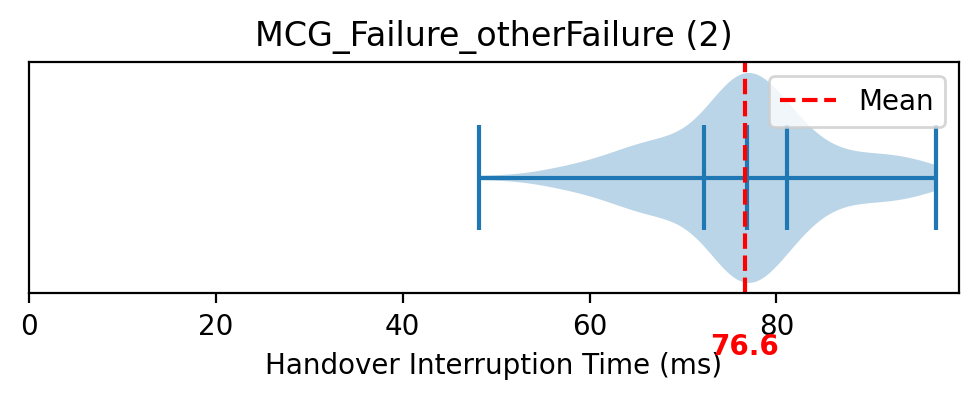

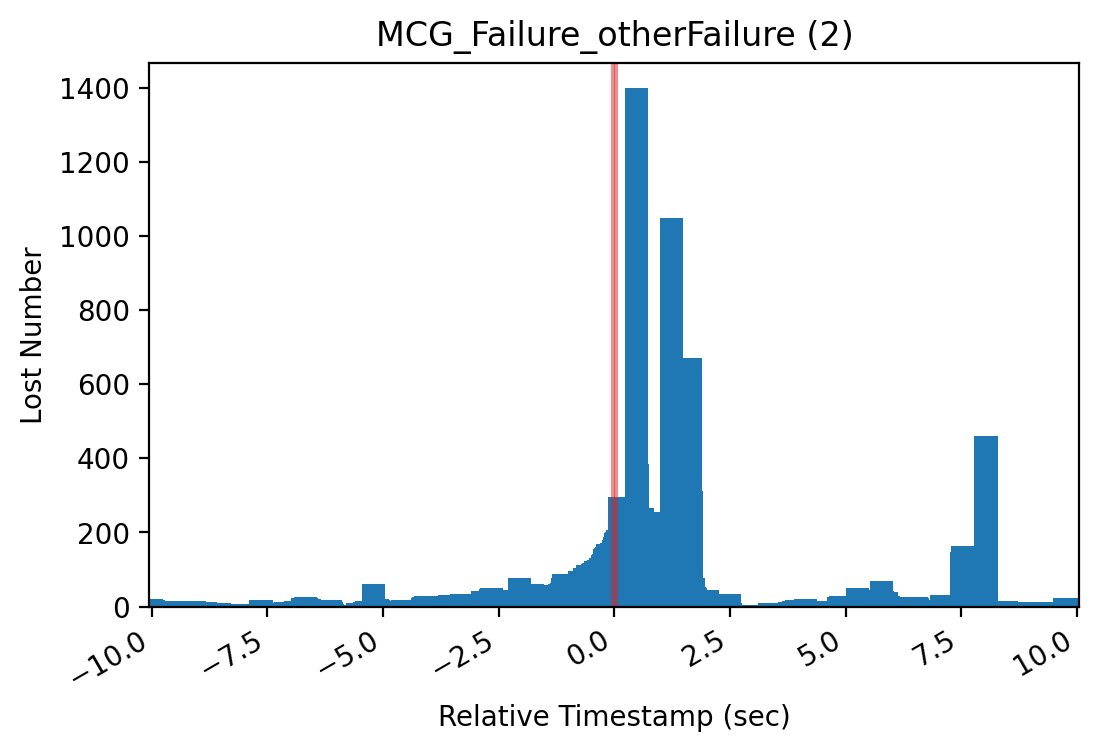

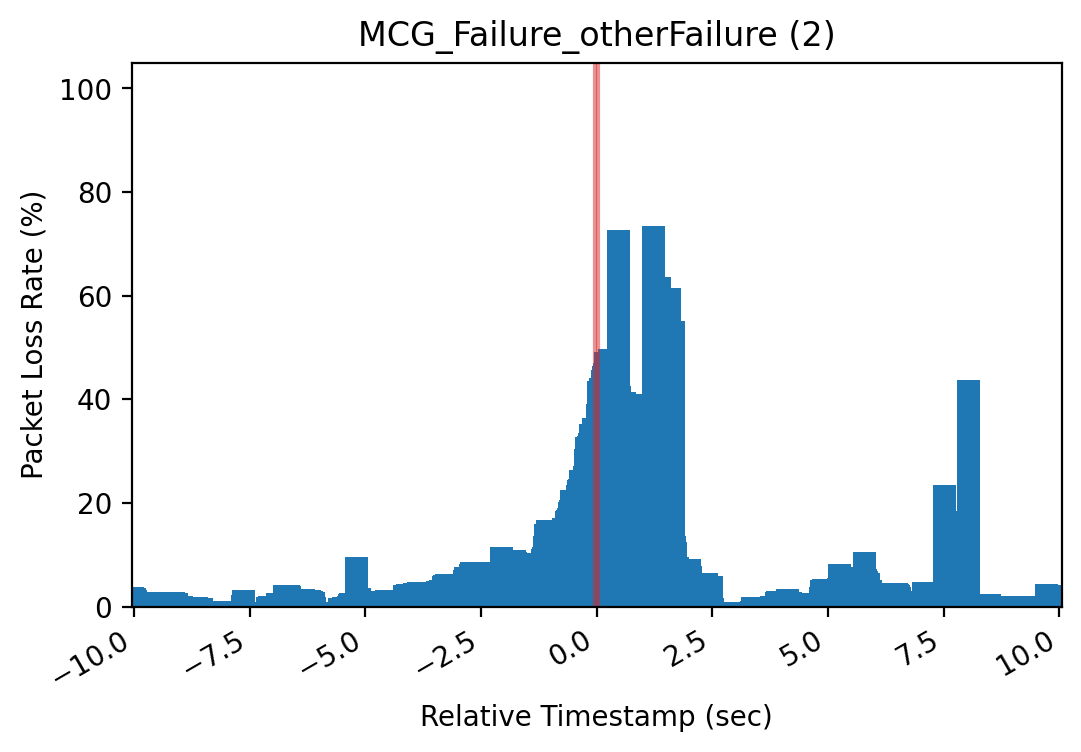

NAS_Recovery_otherFailure (2)
Avg Duration: 0.46772766 seconds
HO Count: 3


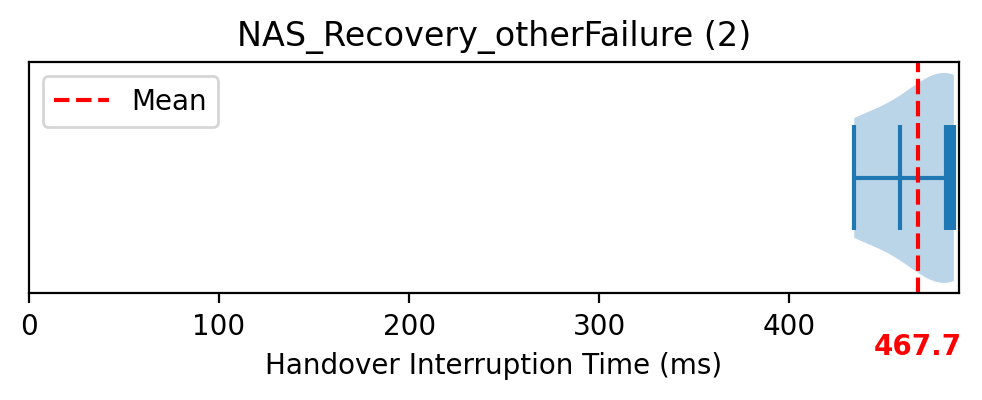

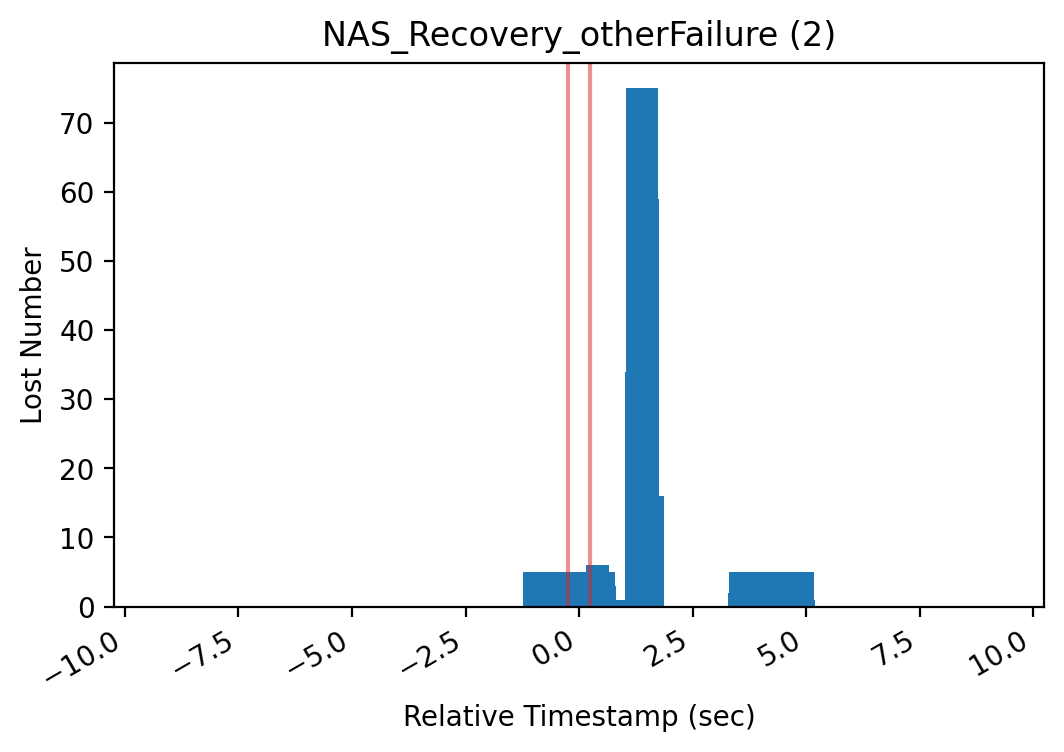

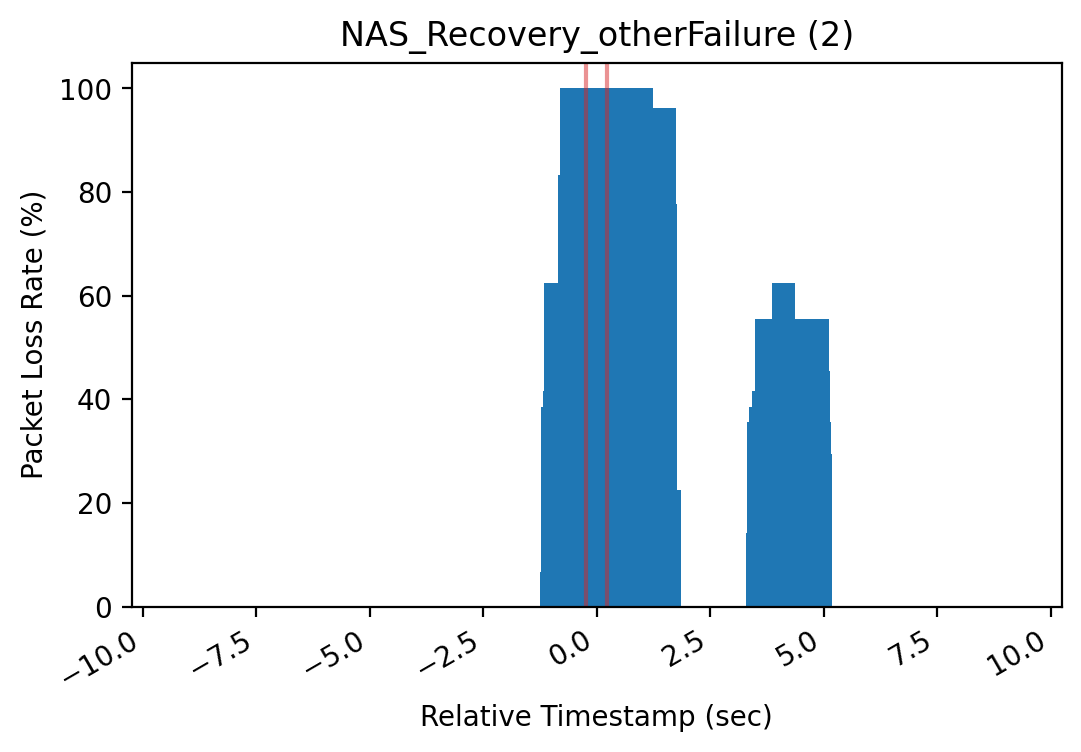

In [102]:
for tag in sorter:
    if len(D[tag]['intrs']) == 0:
        continue
    print('===================================')
    print(tag)
    table, intr = merge_profile(D[tag]['tables'], D[tag]['intrs'])
    print('Avg Duration:', intr, 'seconds')
    print('HO Count:', sum(D[tag]['count']))
    # display(table)
    plot_intrs(D[tag]['intrs'], tag)
    plot_profile(table, intr=intr, title=tag, mode='lost')
    plot_profile(table, intr=intr, title=tag, mode='plr')

### Payload Time

In [103]:
sorter = ['LTE_HO','MN_HO','SN_HO','MNSN_HO','SN_Rel','SN_Setup','SN_Rel_MN_HO','SN_Setup_MN_HO',
          'SCG_Failure_t310-Expiry (0)','SCG_Failure_randomAccessProblem (1)','SCG_Failure_rlc-MaxNumRetx (2)','SCG_Failure_synchReconfigFailureSCG (3)',
          'SCG_Failure_scg-ReconfigFailure (4)','SCG_Failure_srb3-IntegrityFailure (5)','SCG_Failure_other-r16 (6)',
          'MCG_Failure_reconfigurationFailure (0)','MCG_Failure_handoverFailure (1)','MCG_Failure_otherFailure (2)',
          'NAS_Recovery_reconfigurationFailure (0)','NAS_Recovery_handoverFailure (1)','NAS_Recovery_otherFailure (2)']

D = {}
for tag in sorter:
    D[tag] = {'tables': [], 'intrs': [], 'count': []}

for (exp, traces), devices, schemes in zip(exps.items(), _devices, _schemes):
    for trace in traces:
        for j, (dev, schm) in enumerate(zip(devices, schemes)):
            ## read downlink
            data = os.path.join(datadir, exp, dev, trace, 'data', 'udp_dnlk_loss_latency.csv')
            print(data, os.path.isfile(data))
            df_dl = pd.read_csv(data)
            df_dl = set_data(df_dl)
            ## read handover
            path = os.path.join(datadir, exp, dev, trace, 'data')
            data = os.path.join(path, [s for s in os.listdir(path) if s.startswith('diag_log_') and s.endswith('_rrc.csv')][0])
            print(data, os.path.isfile(data))
            df_ho = pd.read_csv(data)
            df_ho, _, _ = mi_parse_ho(df_ho, tz=8)
            df_ho['ho_type0'] = df_ho['ho_type'].astype('string')
            df_ho.loc[df_ho['cause'].notna(), 'ho_type0'] = df_ho['ho_type'].astype('string') + '_' + df_ho['cause'].astype('string')
            df_ho['ho_type0'] = df_ho['ho_type0'].astype('category')
            ## start processing
            for tag in sorter:
                # print('===================================')
                # print(tag)
                df = df_ho.query('ho_type0 == @tag').copy().reset_index(drop=True)
                tables = []
                intrs = []
                if not df.empty:
                    cname = ' '.join(df.at[0, 'ho_type'].split('_')) + ': ' + df.at[0, 'cause'] if pd.notna(df.at[0, 'cause']) else ' '.join(df.at[0, 'ho_type'].split('_'))
                    for i, row in df.iterrows():
                        start, end = df.at[i, 'start'], df.at[i, 'end']
                        intr = df.at[i, 'intr'] if pd.notna(df.at[i, 'intr']) else 0
                        table, intv = setup_profile(df_dl, start, end, mode='pyl', sec=10)
                        # print(intr)
                        # display(table)
                        tables.append(table)
                        intrs.append(intr)
                    table, intr = merge_profile(tables, intrs)
                    # print('Avg Duration:', intr, 'seconds')
                    # display(table)
                    # plot_profile(table, intr=intr, title=cname, mode='lost')
                    # plot_profile(table, intr=intr, title=cname, mode='plr')
                else:
                    table = pd.DataFrame(columns=['cat_id','tx_count','lost','PLR'])
                    table['cat_id'] = table['cat_id'].astype('float32')
                    table['tx_count'] = table['tx_count'].astype('Int32')
                    table['lost'] = table['lost'].astype('Int32')
                    table['PLR'] = table['PLR'].astype('float32')
                    intr = 0
                # print('HO Count:', len(df))
                D[tag]['tables'].append(table)
                D[tag]['intrs'] = [*D[tag]['intrs'], *intrs]
                D[tag]['count'].append(len(df))

/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#01/data/udp_dnlk_loss_latency.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#01/data/diag_log_qc00_2023-03-16_19-23-29_rrc.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc02/#01/data/udp_dnlk_loss_latency.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc02/#01/data/diag_log_qc02_2023-03-16_19-23-29_rrc.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc03/#01/data/udp_dnlk_loss_latency.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc03/#01/data/diag_log_qc03_2023-03-16_19-23-29_rrc.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#02/data/udp_dnlk_loss_latency.csv True
/Users/jackbedford/Desktop/MOXA/Cod

LTE_HO
Avg Duration: 0.030064277 seconds
HO Count: 156


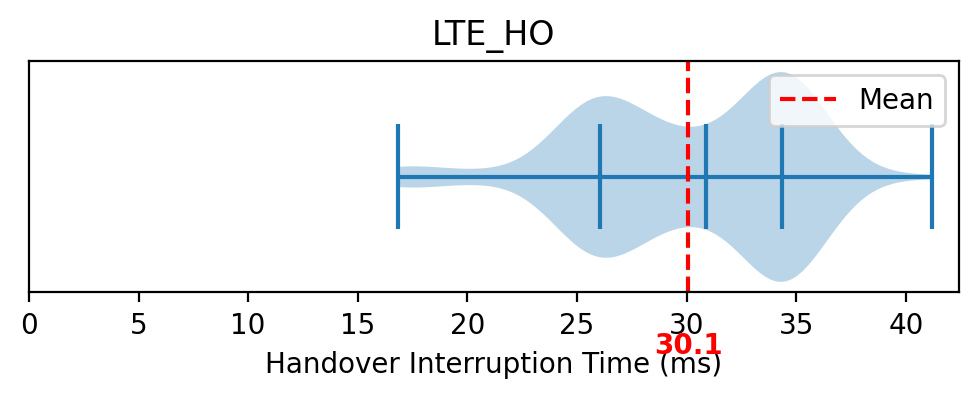

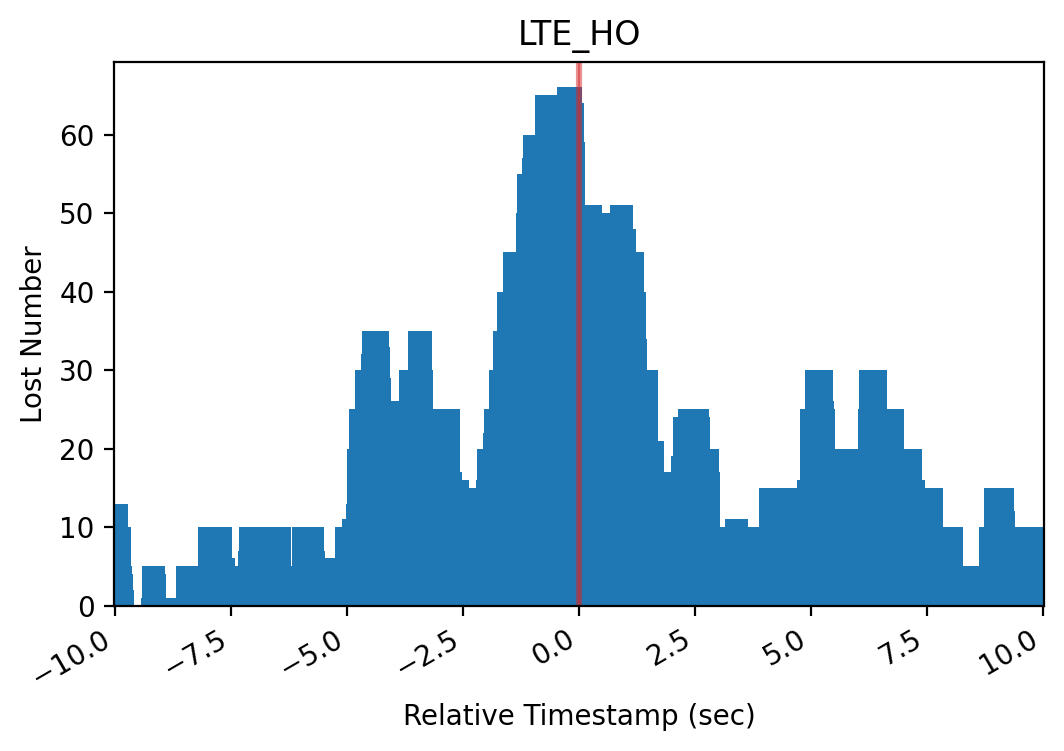

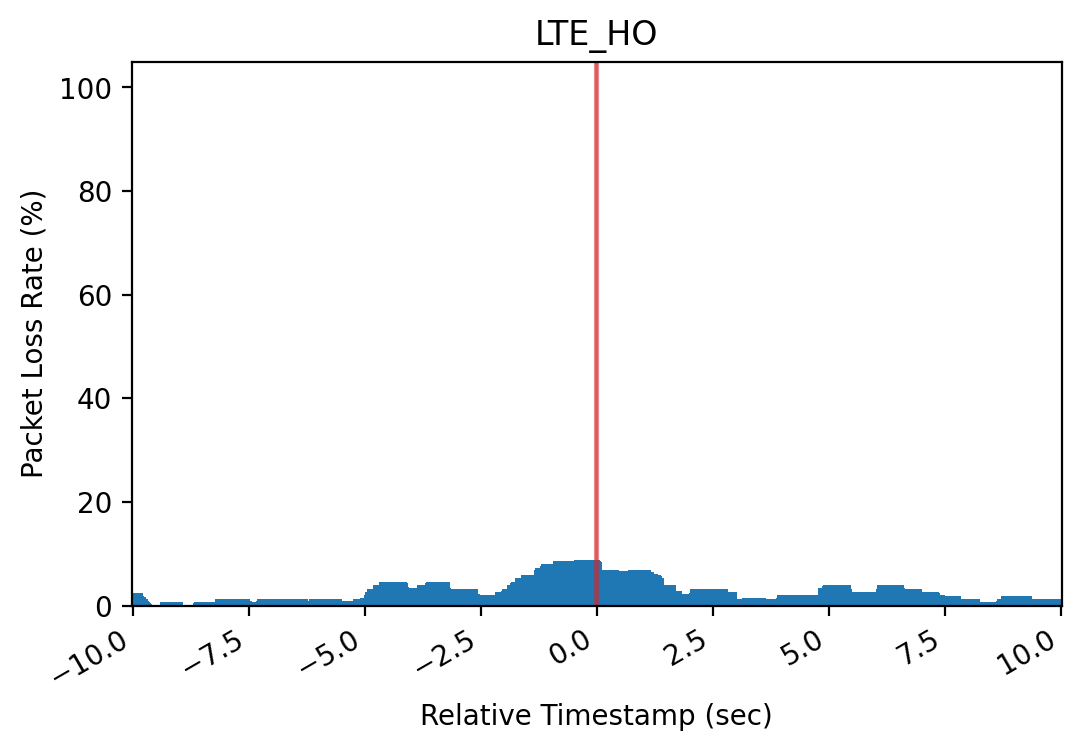

MN_HO
Avg Duration: 0.01831815 seconds
HO Count: 1031


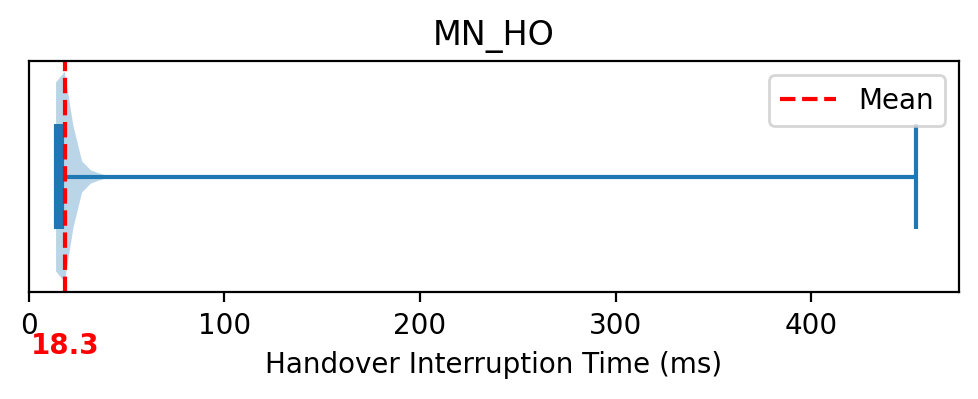

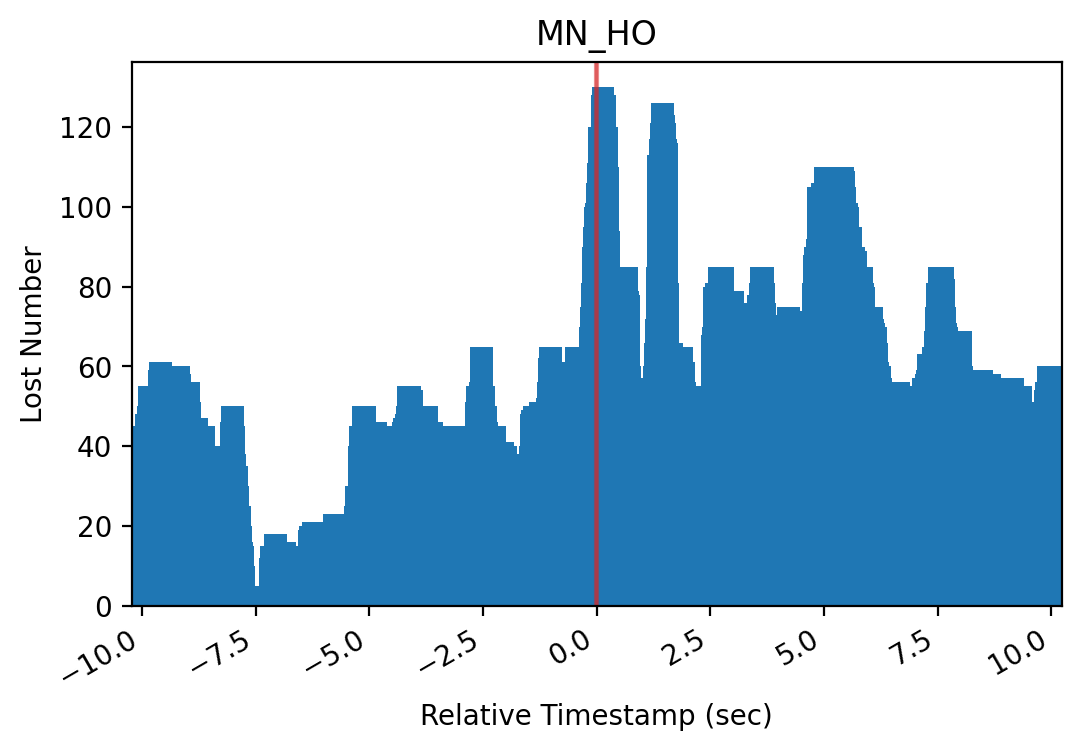

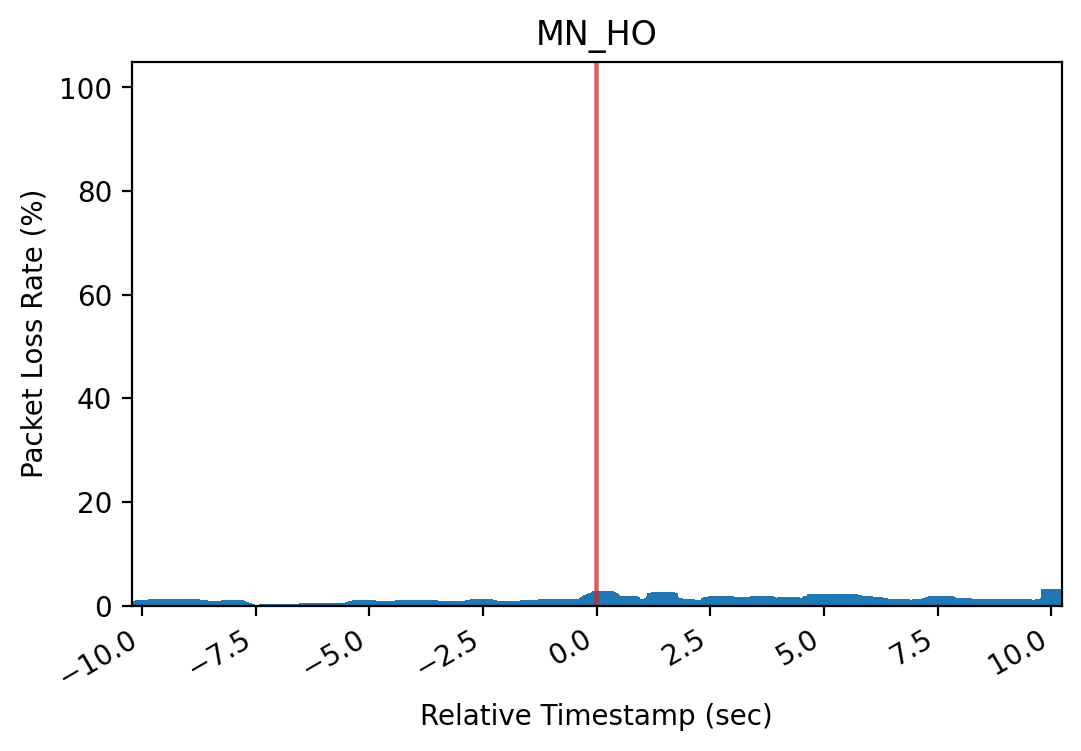

SN_HO
Avg Duration: 0.014631635 seconds
HO Count: 1088


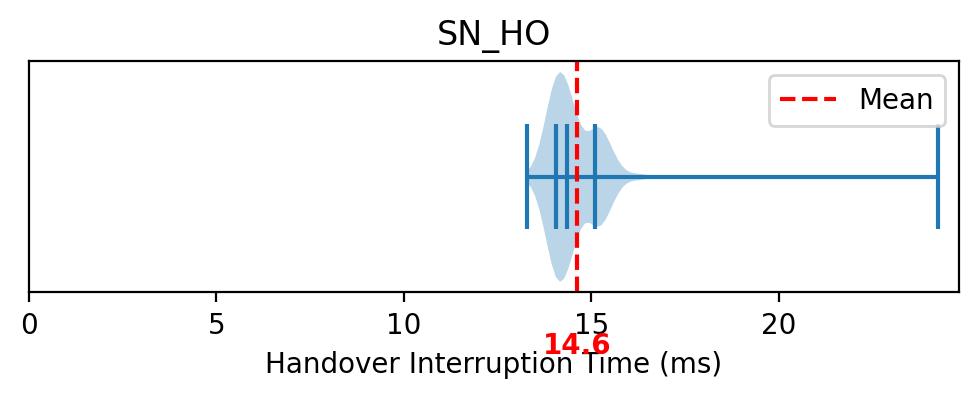

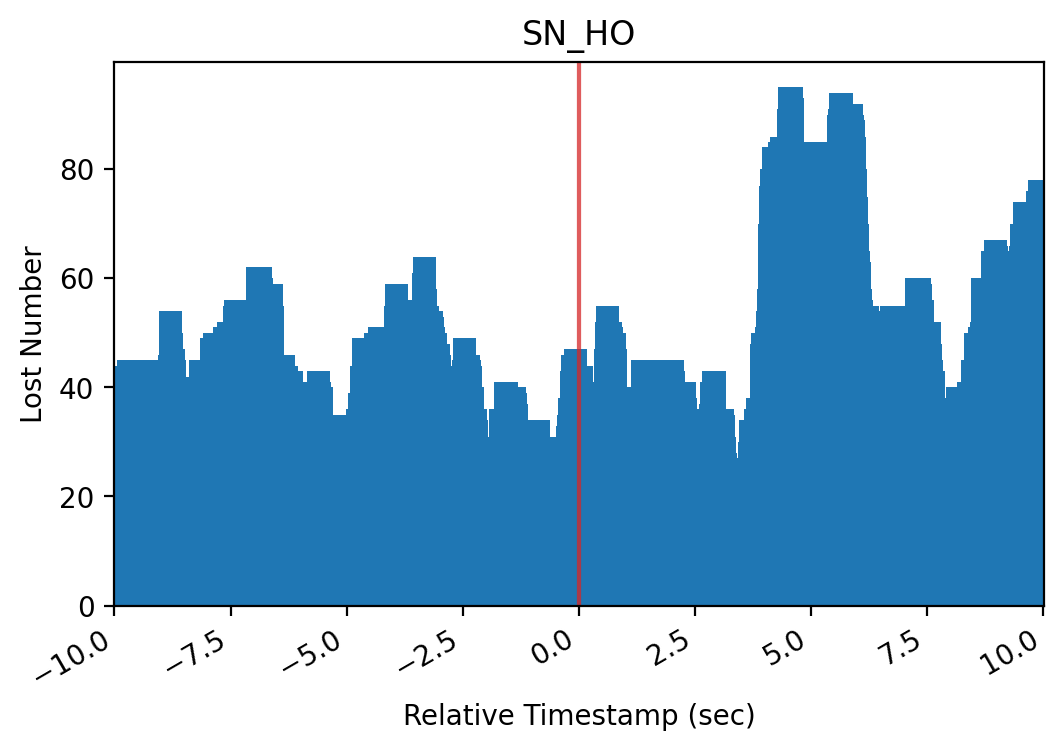

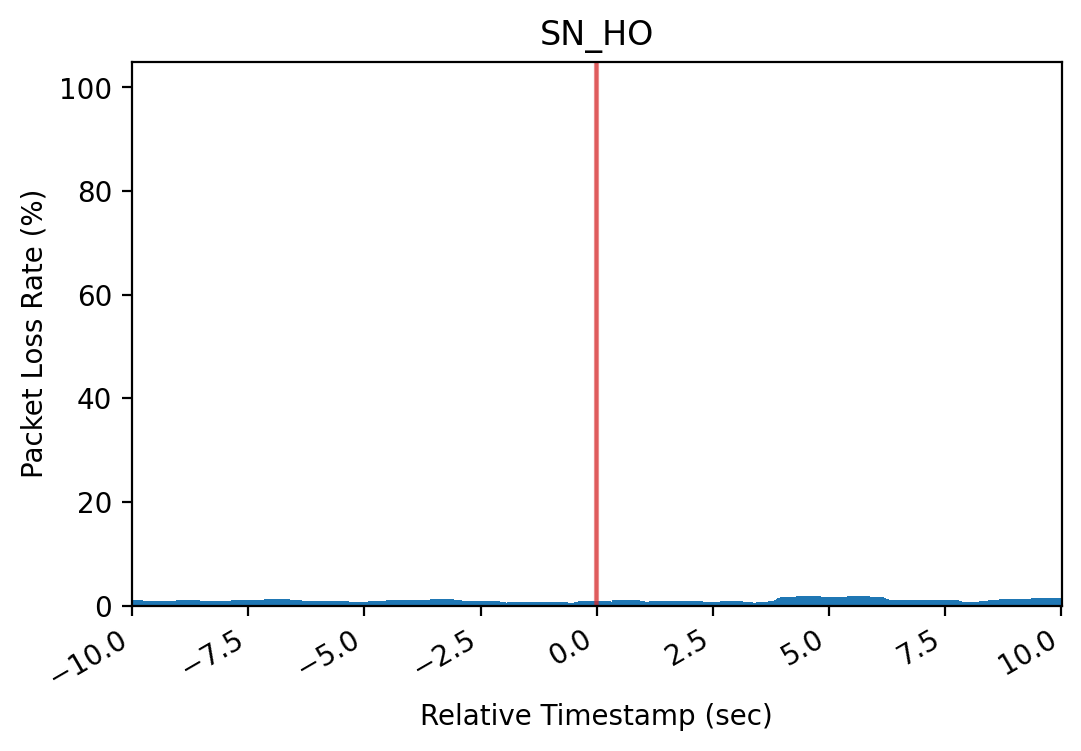

SN_Rel
Avg Duration: 0.02582325 seconds
HO Count: 8


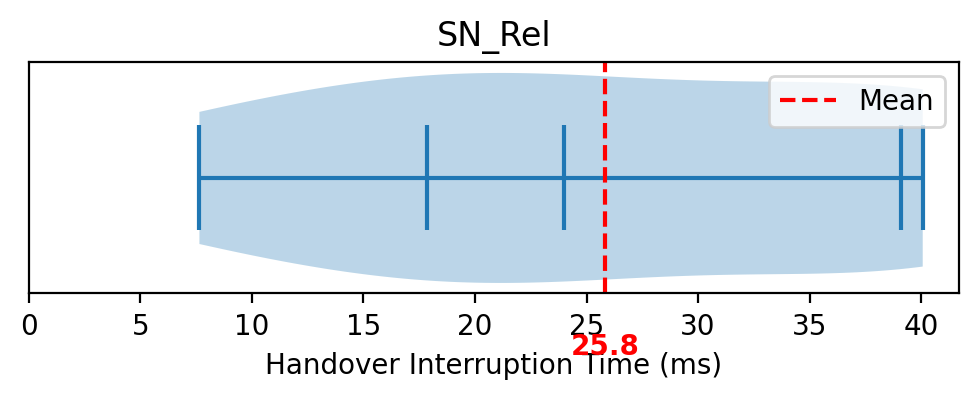

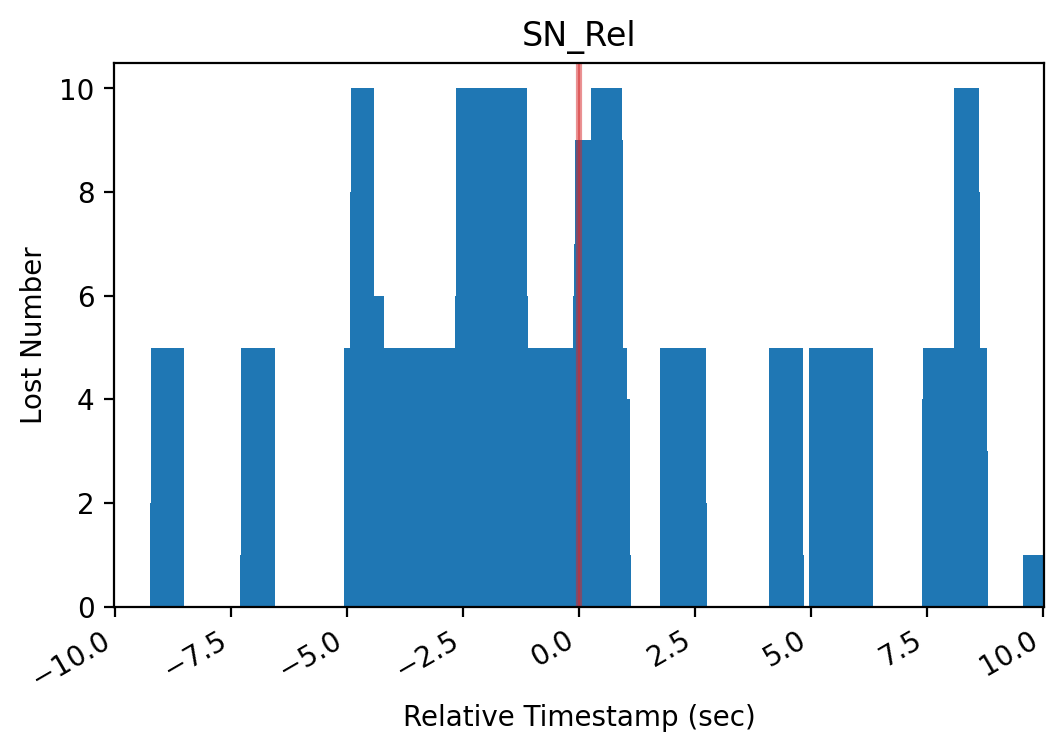

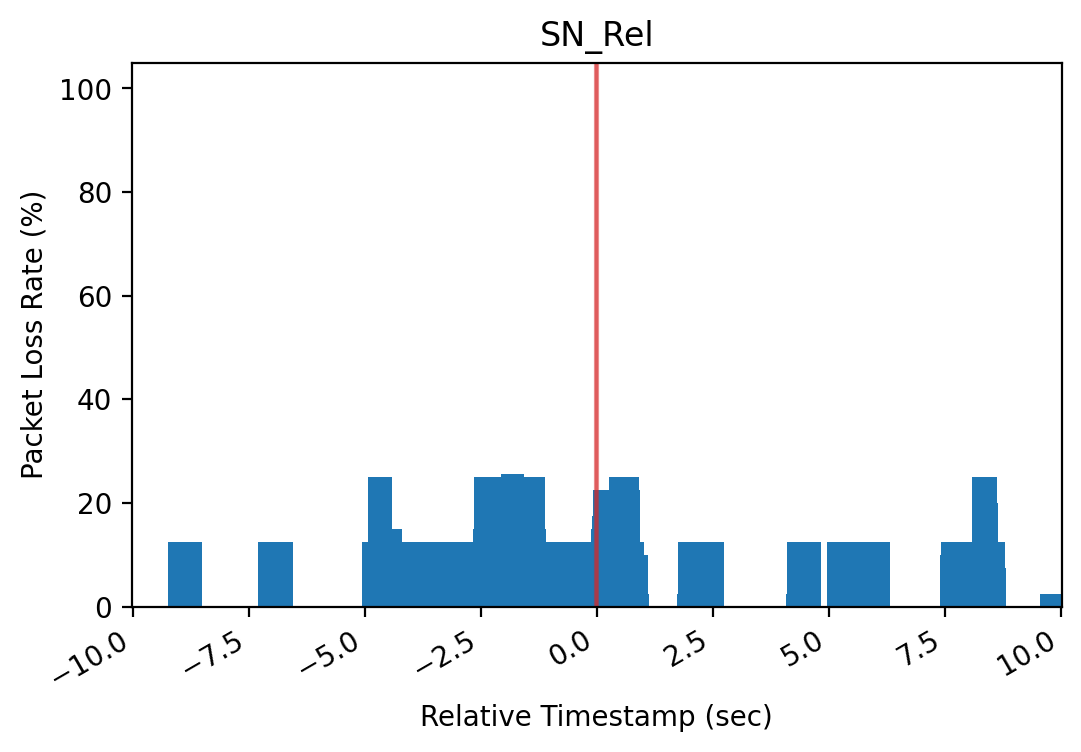

SN_Setup
Avg Duration: 0.028006215 seconds
HO Count: 278


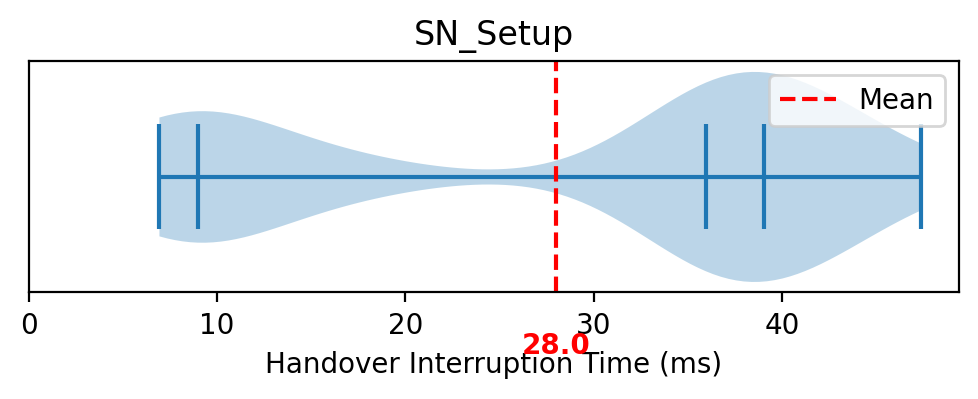

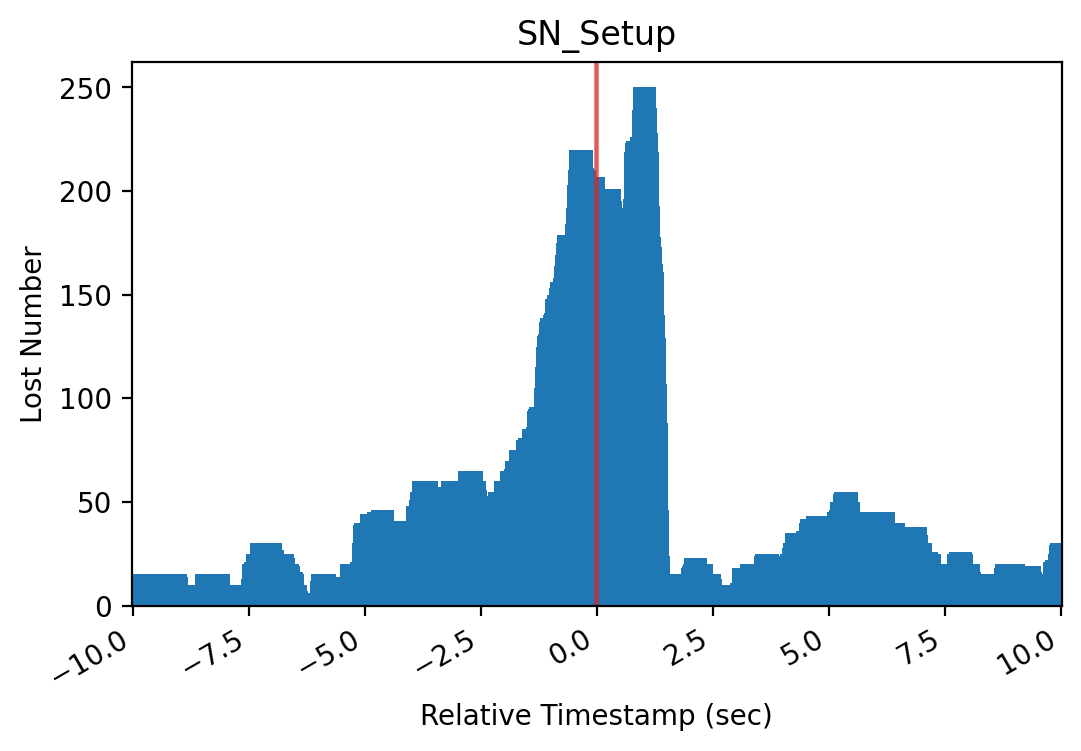

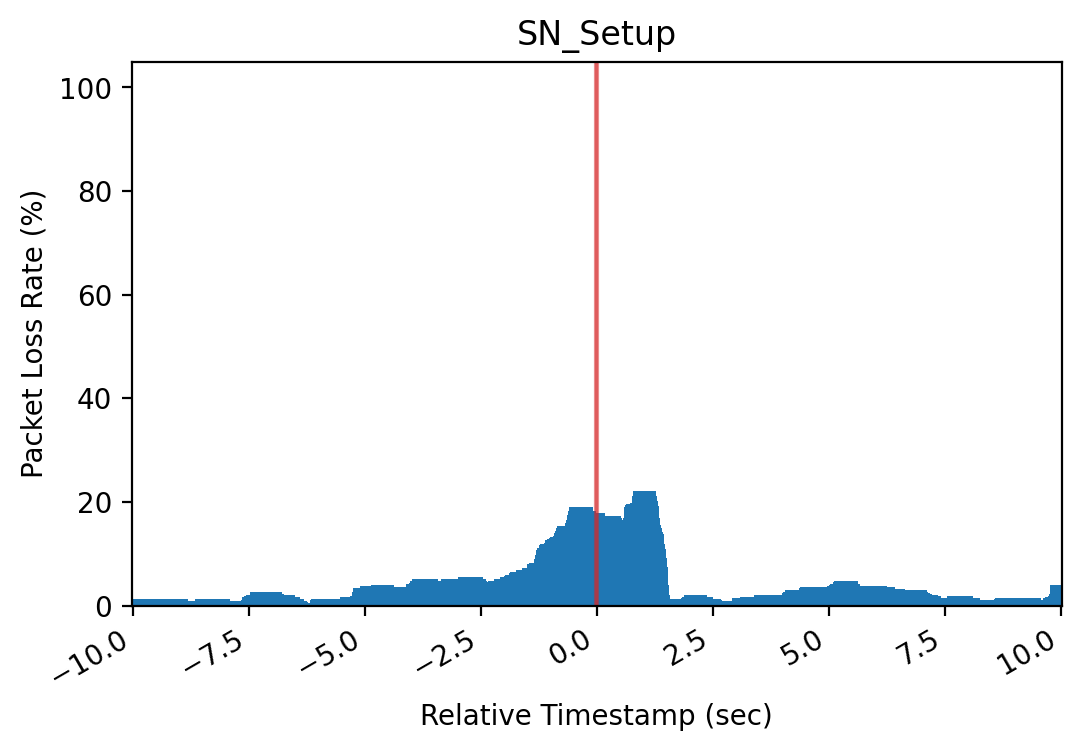

SN_Rel_MN_HO
Avg Duration: 0.016545204 seconds
HO Count: 416


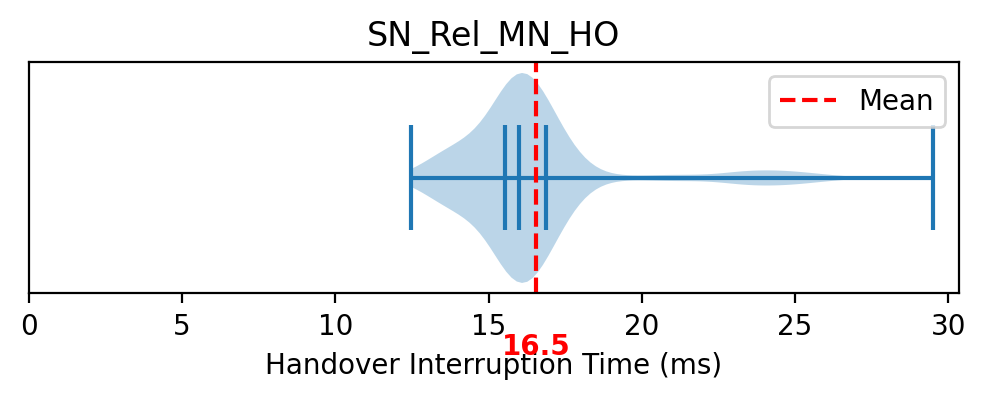

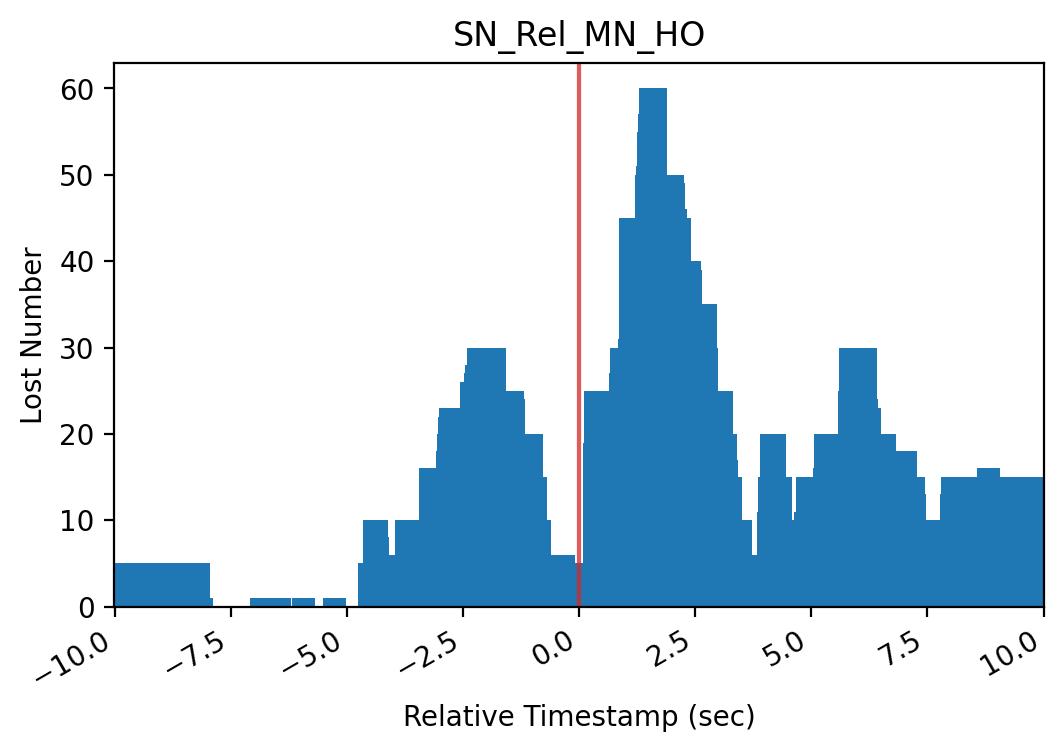

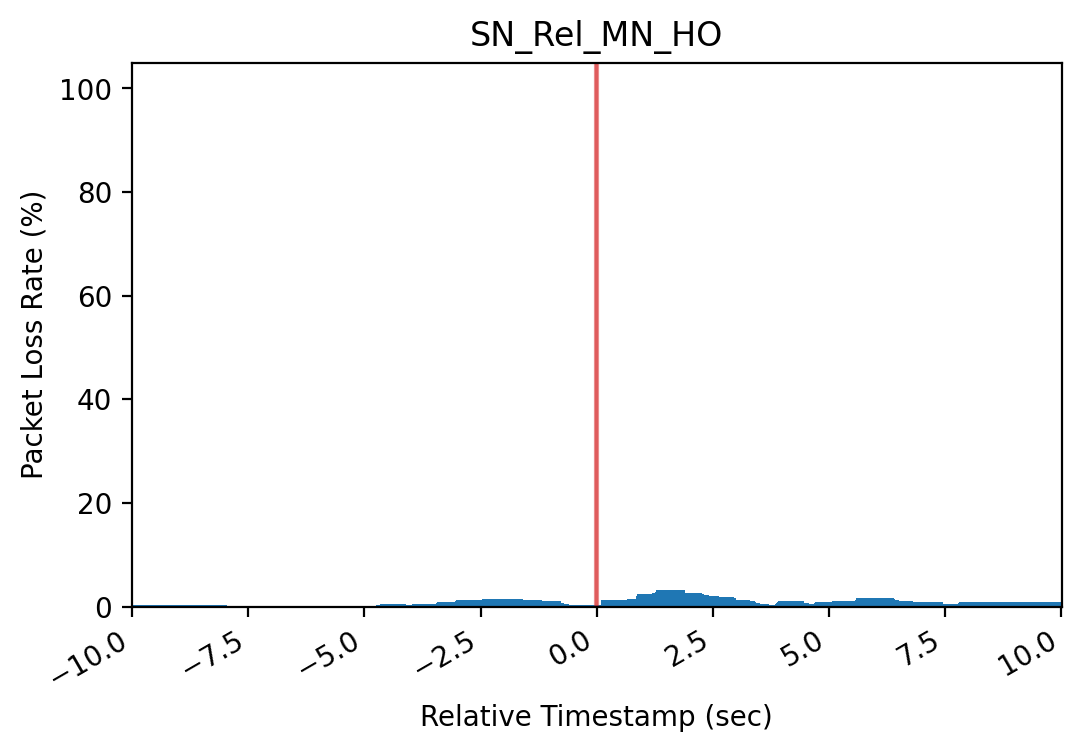

SCG_Failure_t310-Expiry (0)
Avg Duration: 0.0 seconds
HO Count: 3


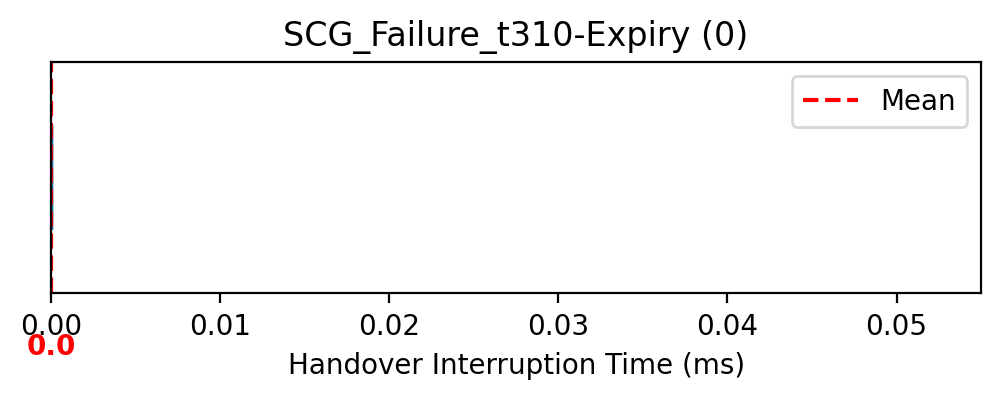

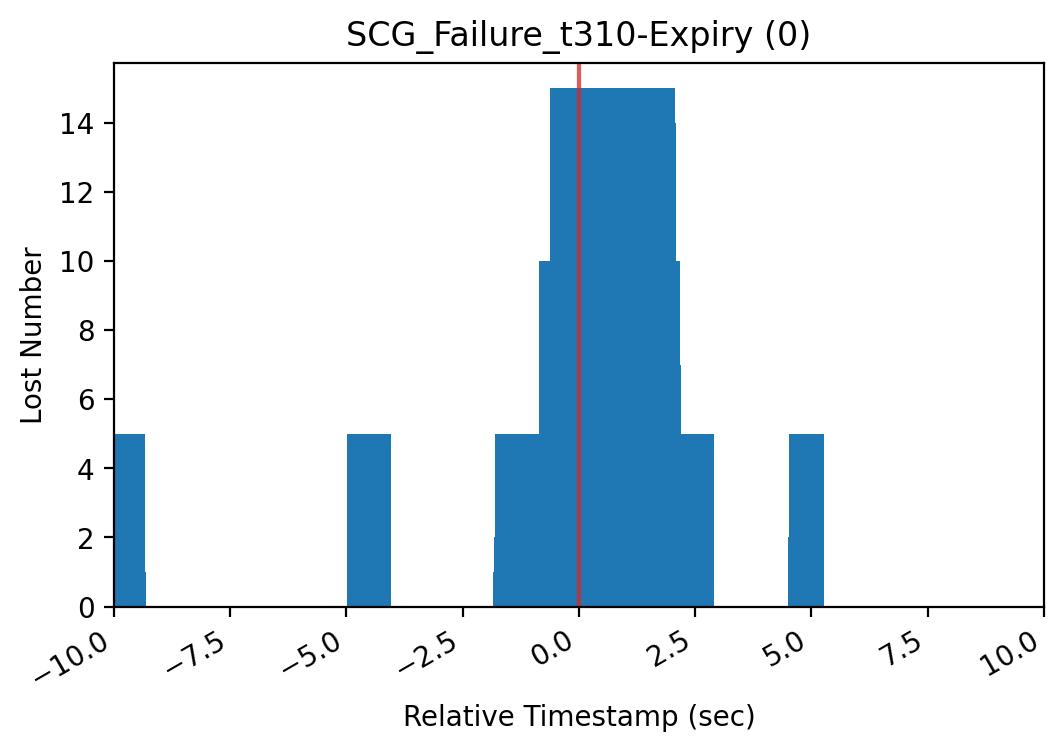

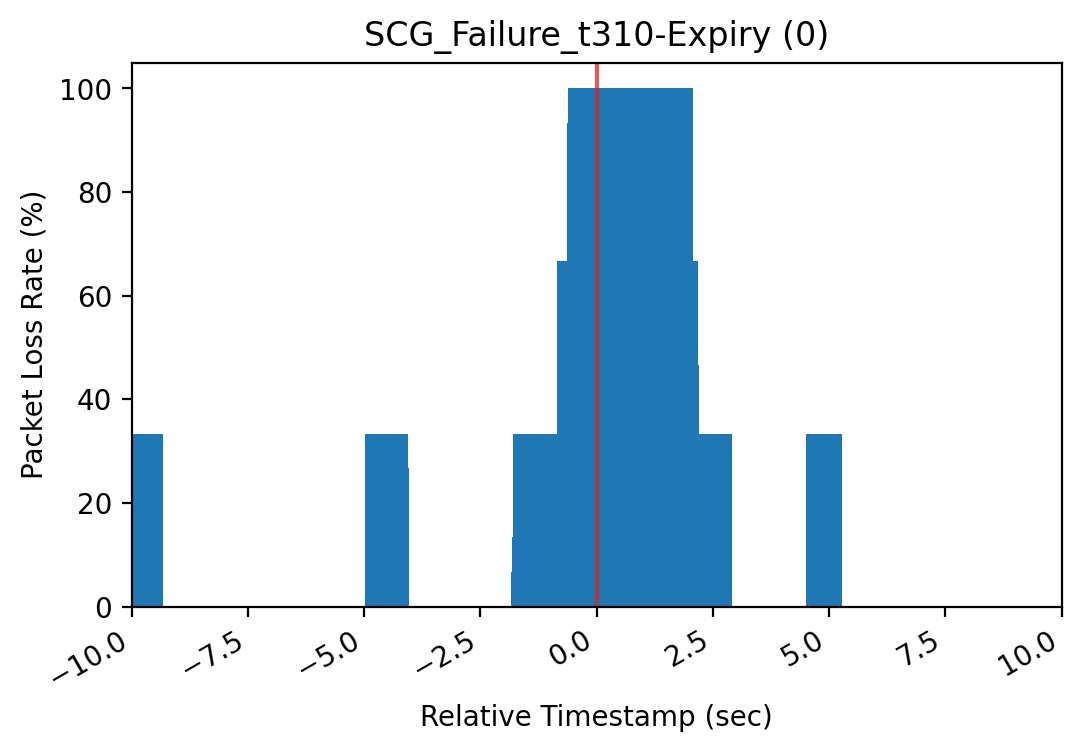

SCG_Failure_synchReconfigFailureSCG (3)
Avg Duration: 0.0 seconds
HO Count: 5


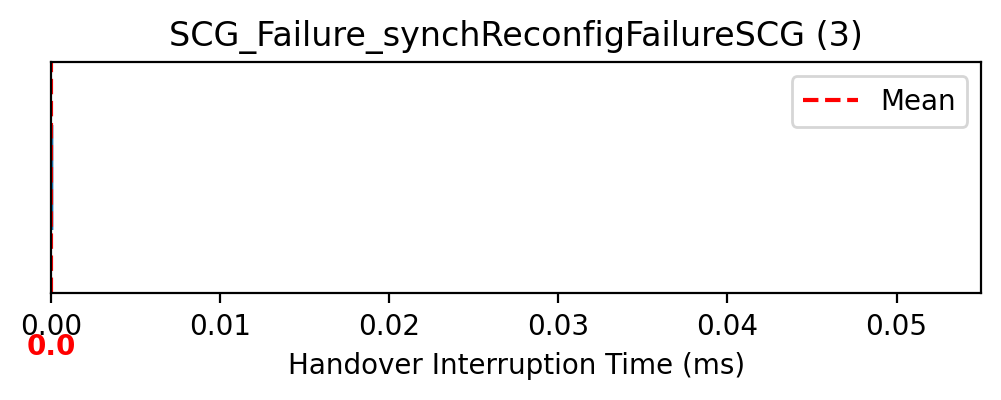

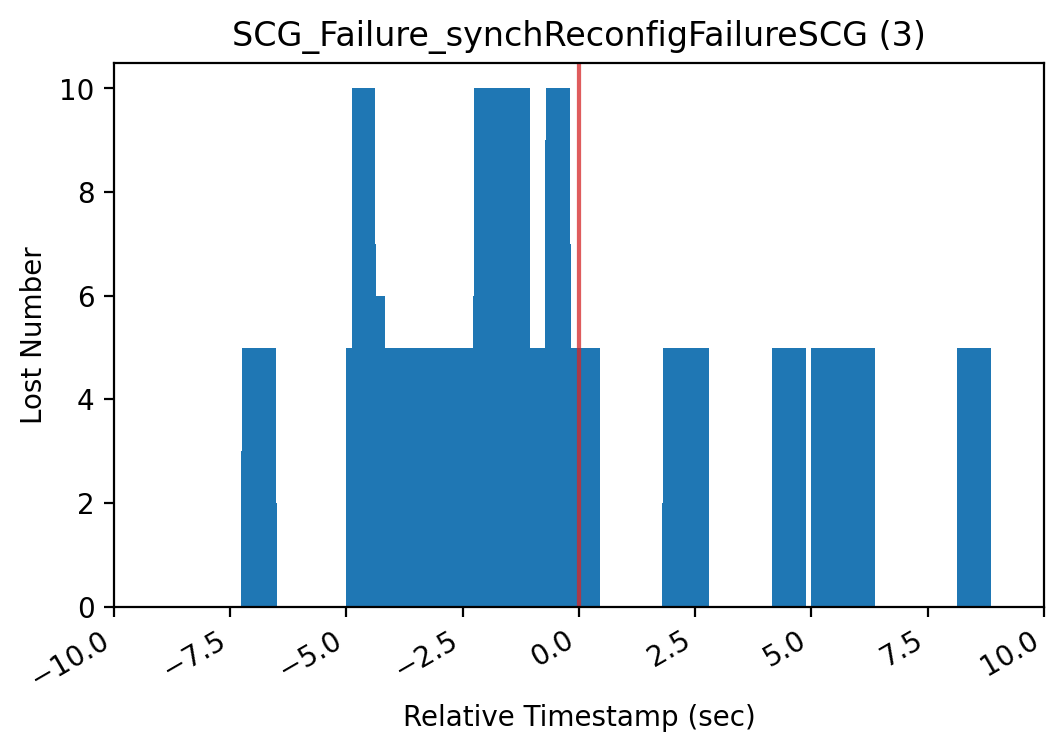

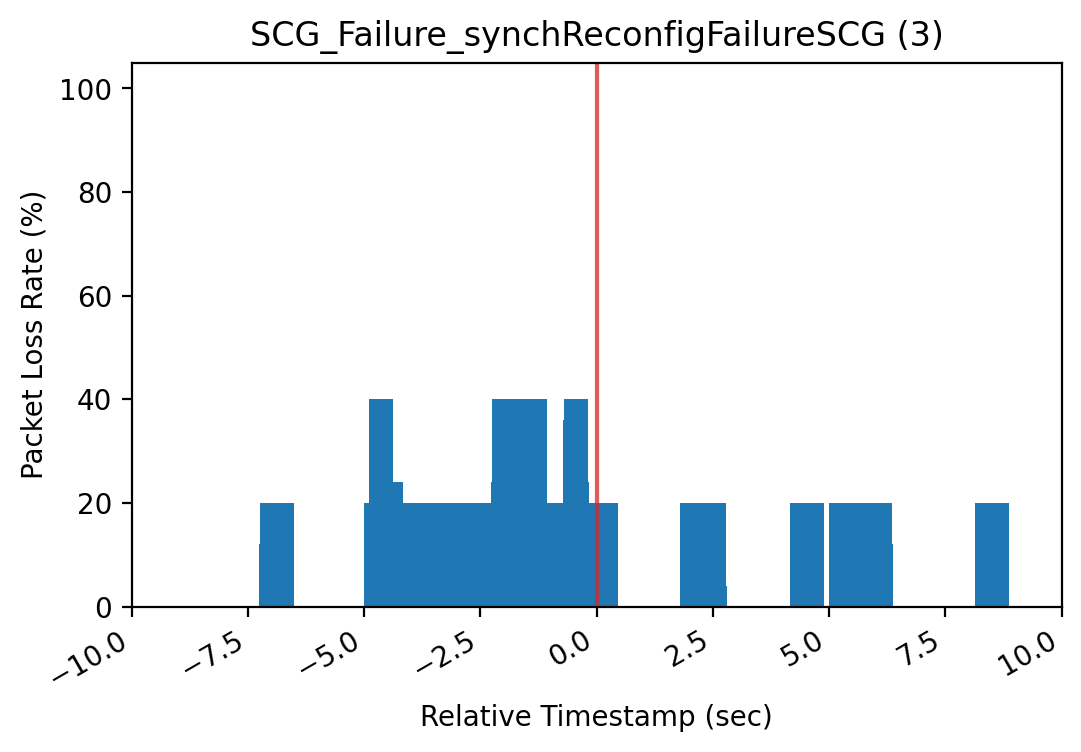

MCG_Failure_handoverFailure (1)
Avg Duration: 0.0821011 seconds
HO Count: 11


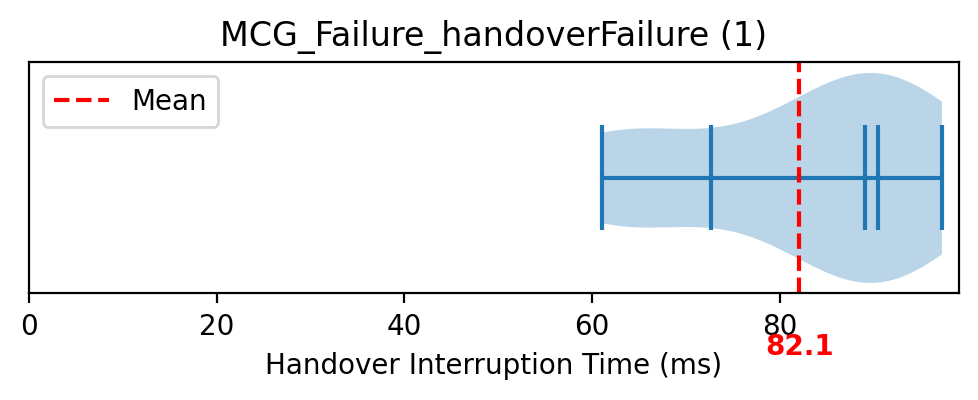

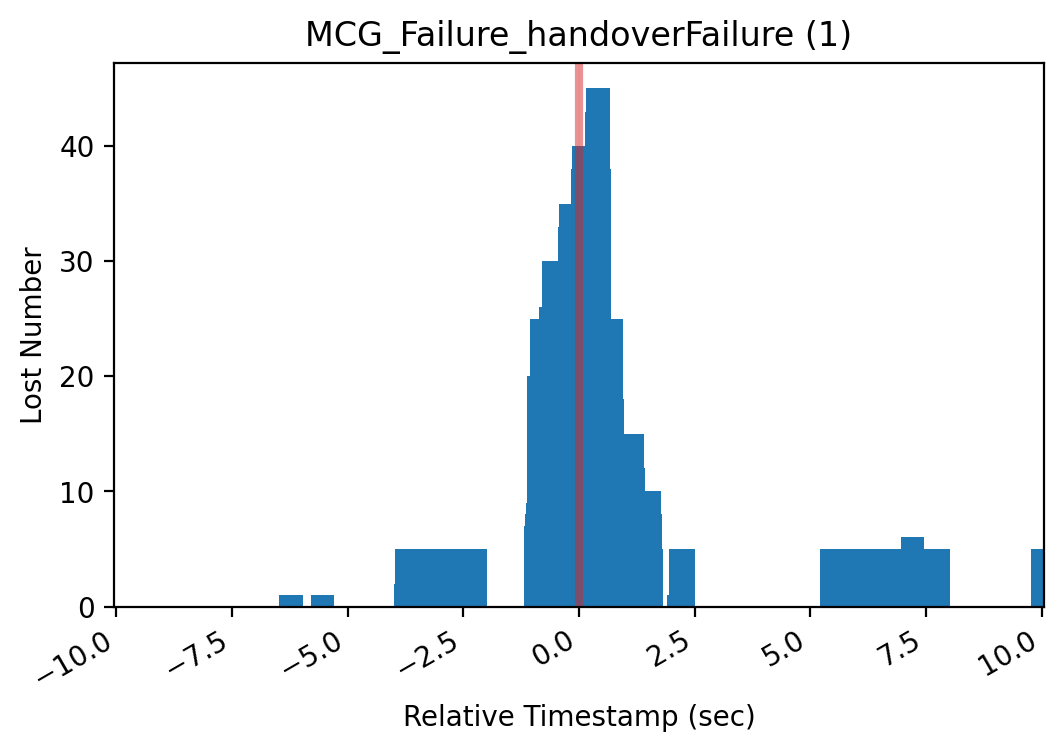

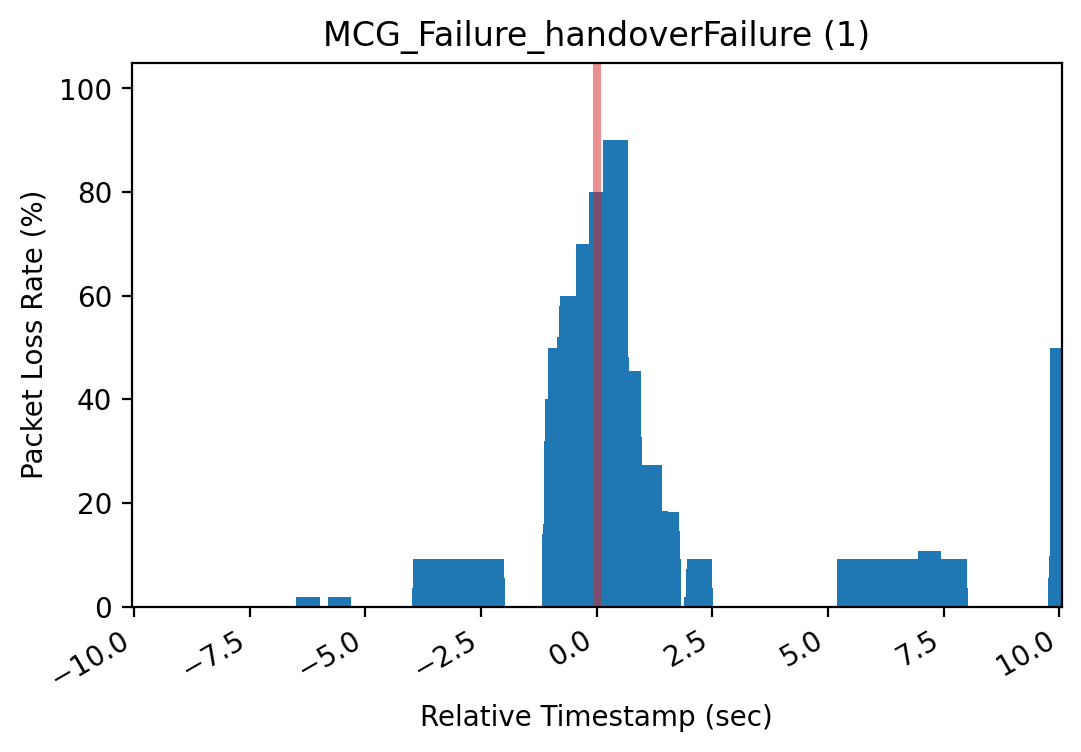

MCG_Failure_otherFailure (2)
Avg Duration: 0.07658415 seconds
HO Count: 117


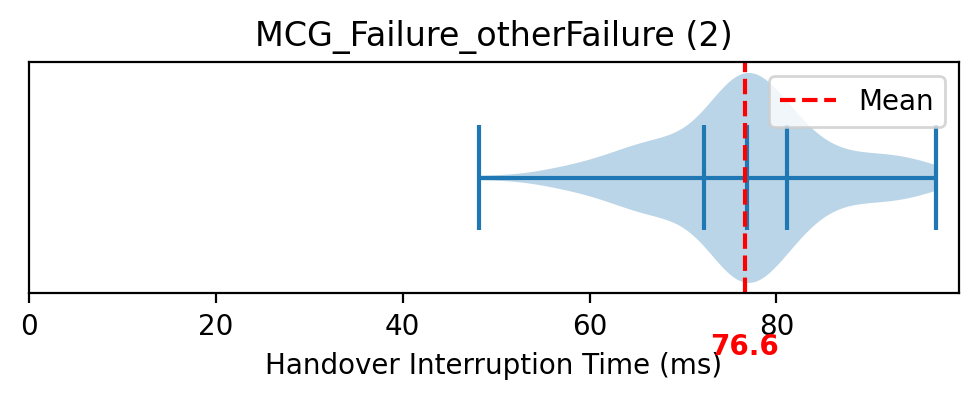

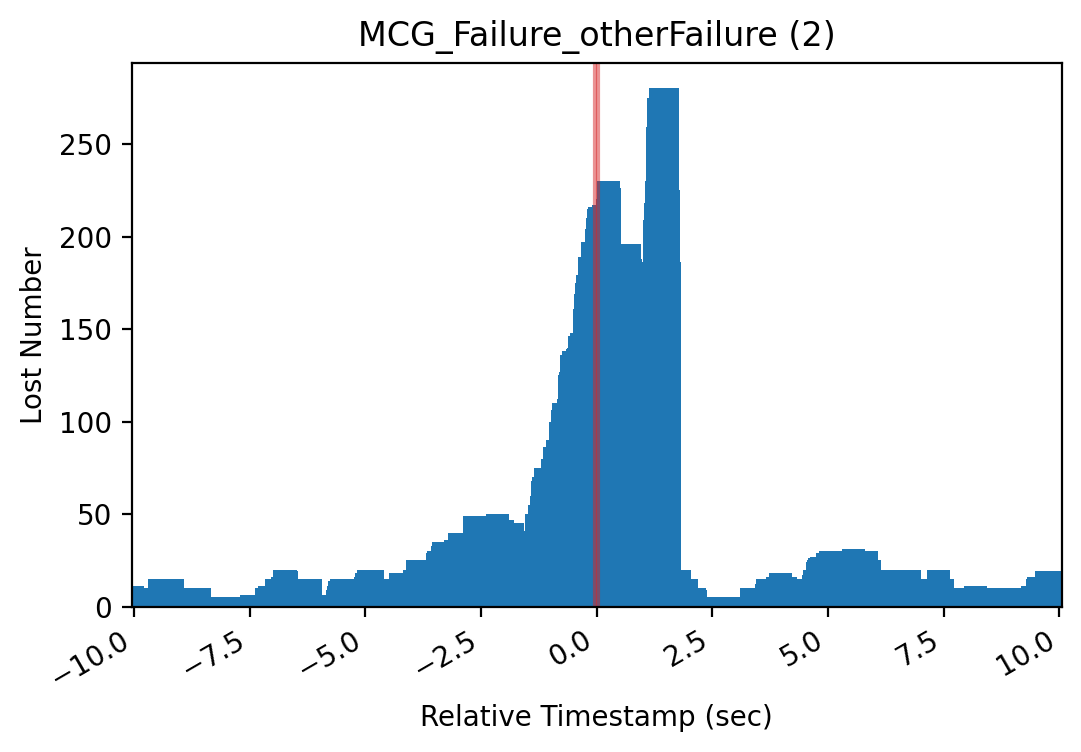

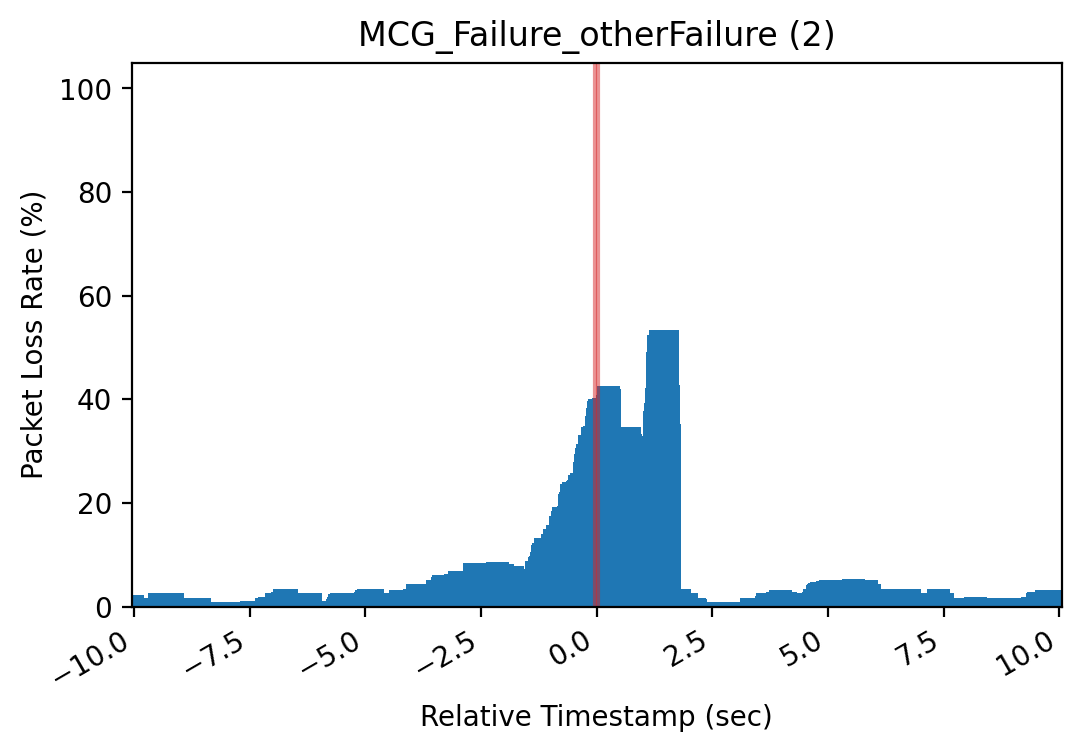

NAS_Recovery_otherFailure (2)
Avg Duration: 0.46772766 seconds
HO Count: 3


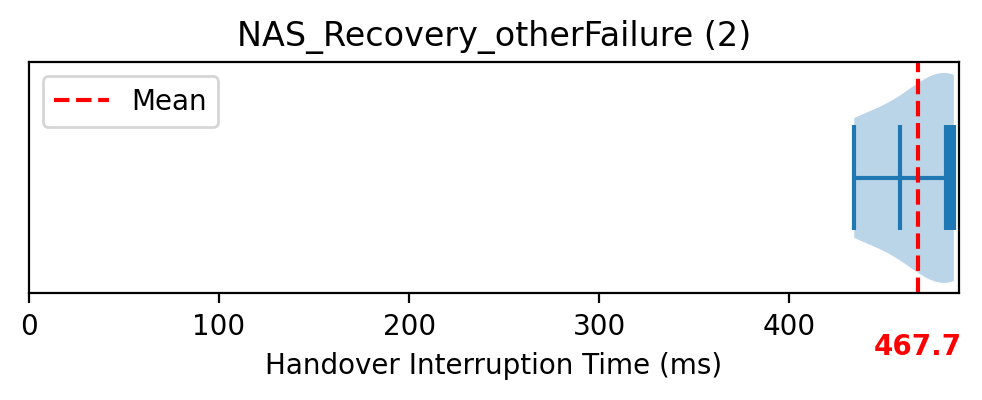

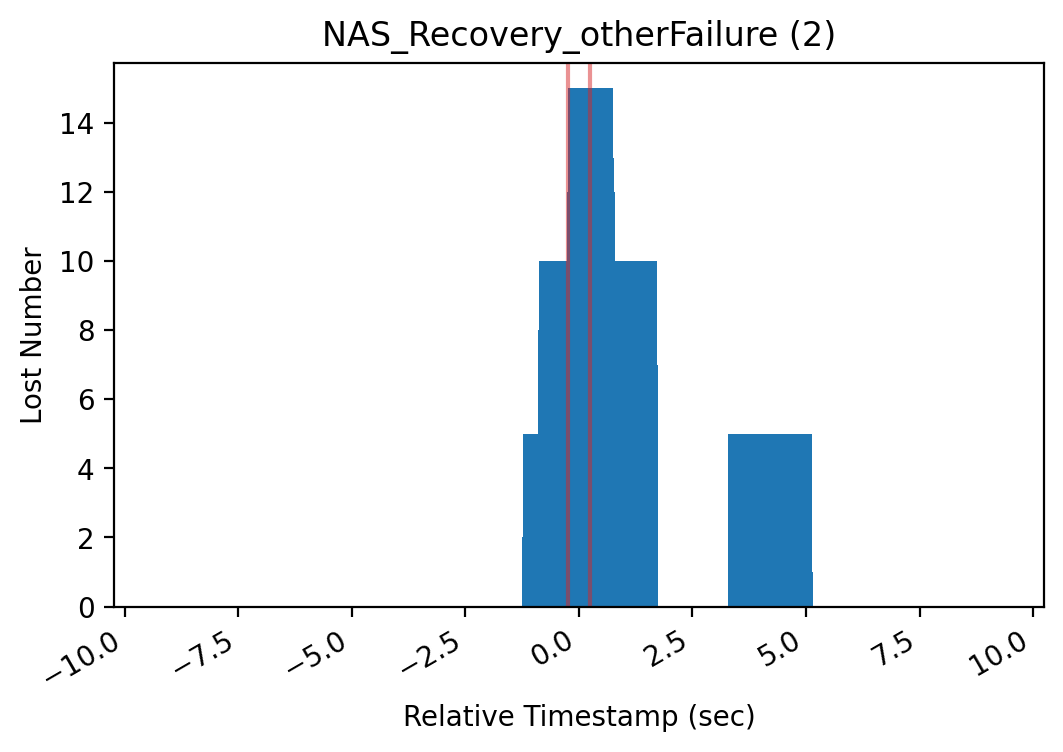

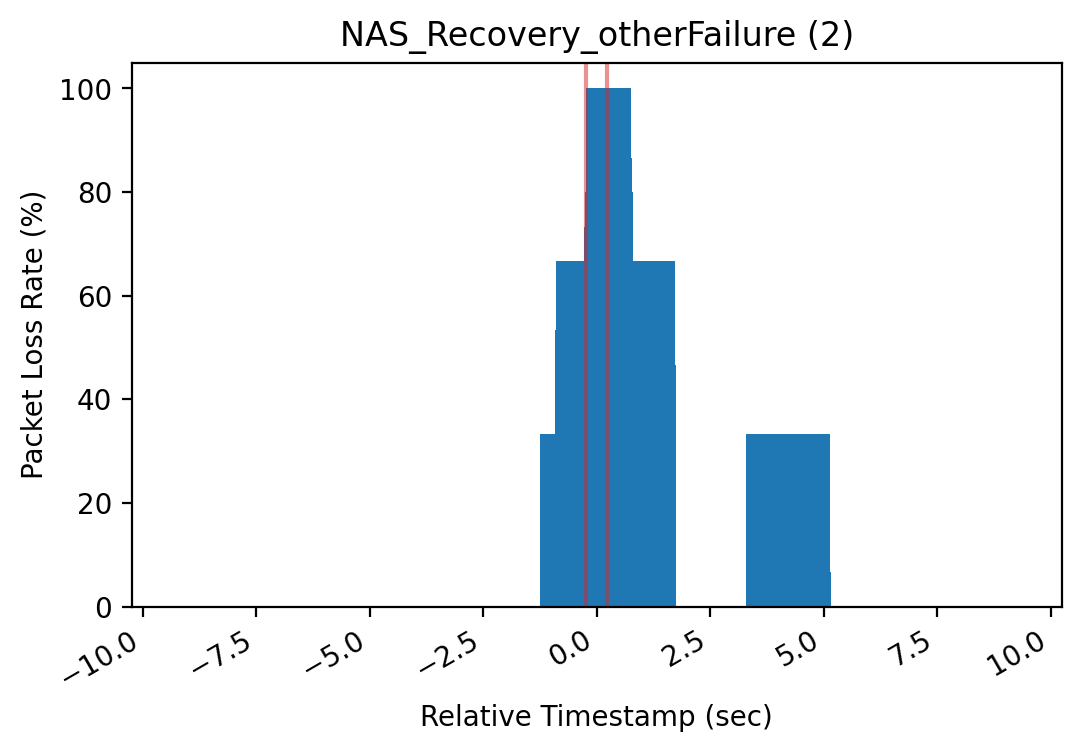

In [104]:
for tag in sorter:
    if len(D[tag]['intrs']) == 0:
        continue
    print('===================================')
    print(tag)
    table, intr = merge_profile(D[tag]['tables'], D[tag]['intrs'])
    print('Avg Duration:', intr, 'seconds')
    print('HO Count:', sum(D[tag]['count']))
    # display(table)
    plot_intrs(D[tag]['intrs'], tag)
    plot_profile(table, intr=intr, title=tag, mode='lost')
    plot_profile(table, intr=intr, title=tag, mode='plr')

## Uplink

### Read Data

In [105]:
datadir = "/Users/jackbedford/Desktop/MOXA/Code/data"
exps = {
    ## Uplink
    "2023-03-15/_Bandlock_Udp_B1_B3_B7_B8_RM500Q": [*['#{:02d}'.format(i+1) for i in range(1, 4)], '#06'],
    "2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q": ['#{:02d}'.format(i+1) for i in range(12)],
    "2023-04-01/_Bandlock_Udp_B1_B3_B7_B8_RM500Q": ['#{:02d}'.format(i+1) for i in range(6)],
    "2023-04-01/_Bandlock_Udp_All_LTE_B1B3_B1B8_RM500Q": ['#{:02d}'.format(i+1) for i in range(4)],
    ## Downlink
    # "2023-03-16/_Bandlock_Udp_B1_B3_B7_B8_RM500Q": ['#{:02d}'.format(i+1) for i in range(16)],
    # "2023-04-01/_Bandlock_Udp_B1_B3_B7_B8_RM500Q": ['#{:02d}'.format(i+1) for i in range(6)],
    # "2023-04-01/_Bandlock_Udp_All_LTE_B1B3_B1B8_RM500Q": ['#{:02d}'.format(i+1) for i in range(4)],
}
_devices = [
    ['qc00','qc02','qc03'],
    ['qc00','qc02','qc03'],
    ['qc00','qc01','qc02','qc03'],
    ['qc00','qc01','qc02','qc03'],
]
_schemes = [
    ['B1','B7','B8'],
    ['B1','B7','B8'],
    ['B1','B3','B7','B8'],
    ['B1B3','B1B8','LTE','All'],
]

# dfs_ul = []
# for (exp, traces), devices, schemes in zip(exps.items(), _devices, _schemes):
#     for trace in traces:
#         for j, (dev, schm) in enumerate(zip(devices, schemes)):
#             data = os.path.join(datadir, exp, dev, trace, 'data', 'udp_uplk_loss_latency.csv')
#             print(data, os.path.isfile(data))
#             df = pd.read_csv(data)
#             df = set_data(df)
#             # dfs_ul.append(DF(data, df.copy()))
#             dfs_ul.append(DF(data, None))
# print(len(dfs_ul))

# dfs_ho = []
# for (exp, traces), devices, schemes in zip(exps.items(), _devices, _schemes):
#     for trace in traces:
#         for j, (dev, schm) in enumerate(zip(devices, schemes)):
#             path = os.path.join(datadir, exp, dev, trace, 'data')
#             data = os.path.join(path, [s for s in os.listdir(path) if s.startswith('diag_log_') and s.endswith('_rrc.csv')][0])
#             print(data, os.path.isfile(data))
#             df = pd.read_csv(data)
#             df, _, _ = mi_parse_ho(df, tz=8)
#             df['ho_type0'] = df['ho_type'].astype('string')
#             df.loc[df['cause'].notna(), 'ho_type0'] = df['ho_type'].astype('string') + '_' + df['cause'].astype('string')
#             df['ho_type0'] = df['ho_type0'].astype('category')
#             # dfs_ho.append(DF(data, df.copy()))
#             dfs_ho.append(DF(data, None))
# print(len(dfs_ho))

### Transmission Time

In [110]:
sorter = ['LTE_HO','MN_HO','SN_HO','MNSN_HO','SN_Rel','SN_Setup','SN_Rel_MN_HO','SN_Setup_MN_HO',
          'SCG_Failure_t310-Expiry (0)','SCG_Failure_randomAccessProblem (1)','SCG_Failure_rlc-MaxNumRetx (2)','SCG_Failure_synchReconfigFailureSCG (3)',
          'SCG_Failure_scg-ReconfigFailure (4)','SCG_Failure_srb3-IntegrityFailure (5)','SCG_Failure_other-r16 (6)',
          'MCG_Failure_reconfigurationFailure (0)','MCG_Failure_handoverFailure (1)','MCG_Failure_otherFailure (2)',
          'NAS_Recovery_reconfigurationFailure (0)','NAS_Recovery_handoverFailure (1)','NAS_Recovery_otherFailure (2)']

D = {}
for tag in sorter:
    D[tag] = {'tables': [], 'intrs': [], 'count': []}

for (exp, traces), devices, schemes in zip(exps.items(), _devices, _schemes):
    for trace in traces:
        for j, (dev, schm) in enumerate(zip(devices, schemes)):
            ## read downlink
            data = os.path.join(datadir, exp, dev, trace, 'data', 'udp_uplk_loss_latency.csv')
            print(data, os.path.isfile(data))
            df_ul = pd.read_csv(data)
            df_ul = set_data(df_ul)
            ## read handover
            path = os.path.join(datadir, exp, dev, trace, 'data')
            data = os.path.join(path, [s for s in os.listdir(path) if s.startswith('diag_log_') and s.endswith('_rrc.csv')][0])
            print(data, os.path.isfile(data))
            df_ho = pd.read_csv(data)
            df_ho, _, _ = mi_parse_ho(df_ho, tz=8)
            df_ho['ho_type0'] = df_ho['ho_type'].astype('string')
            df_ho.loc[df_ho['cause'].notna(), 'ho_type0'] = df_ho['ho_type'].astype('string') + '_' + df_ho['cause'].astype('string')
            df_ho['ho_type0'] = df_ho['ho_type0'].astype('category')
            ## start processing
            for tag in sorter:
                # print('===================================')
                # print(tag)
                df = df_ho.query('ho_type0 == @tag').copy().reset_index(drop=True)
                tables = []
                intrs = []
                if not df.empty:
                    cname = ' '.join(df.at[0, 'ho_type'].split('_')) + ': ' + df.at[0, 'cause'] if pd.notna(df.at[0, 'cause']) else ' '.join(df.at[0, 'ho_type'].split('_'))
                    for i, row in df.iterrows():
                        start, end = df.at[i, 'start'], df.at[i, 'end']
                        intr = df.at[i, 'intr'] if pd.notna(df.at[i, 'intr']) else 0
                        table, intv = setup_profile(df_ul, start, end, mode='ul', sec=10)
                        # print(intr)
                        # display(table)
                        tables.append(table)
                        intrs.append(intr)
                    table, intr = merge_profile(tables, intrs)
                    # print('Avg Duration:', intr, 'seconds')
                    # display(table)
                    # plot_profile(table, intr=intr, title=cname, mode='lost')
                    # plot_profile(table, intr=intr, title=cname, mode='plr')
                else:
                    table = pd.DataFrame(columns=['cat_id','tx_count','lost','PLR'])
                    table['cat_id'] = table['cat_id'].astype('float32')
                    table['tx_count'] = table['tx_count'].astype('Int32')
                    table['lost'] = table['lost'].astype('Int32')
                    table['PLR'] = table['PLR'].astype('float32')
                    intr = 0
                # print('HO Count:', len(df))
                D[tag]['tables'].append(table)
                D[tag]['intrs'] = [*D[tag]['intrs'], *intrs]
                D[tag]['count'].append(len(df))

/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-15/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#02/data/udp_uplk_loss_latency.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-15/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#02/data/diag_log_qc00_2023-03-15_15-15-41_rrc.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-15/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc02/#02/data/udp_uplk_loss_latency.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-15/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc02/#02/data/diag_log_qc02_2023-03-15_15-15-41_rrc.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-15/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc03/#02/data/udp_uplk_loss_latency.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-15/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc03/#02/data/diag_log_qc03_2023-03-15_15-15-41_rrc.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-15/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#03/data/udp_uplk_loss_latency.csv True
/Users/jackbedford/Desktop/MOXA/Cod

KeyboardInterrupt: 

LTE_HO
Avg Duration: 0.02985257 seconds
HO Count: 155


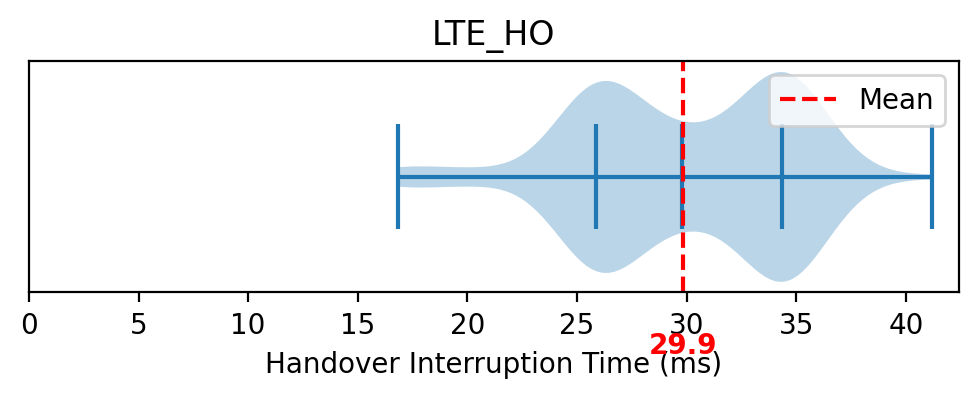

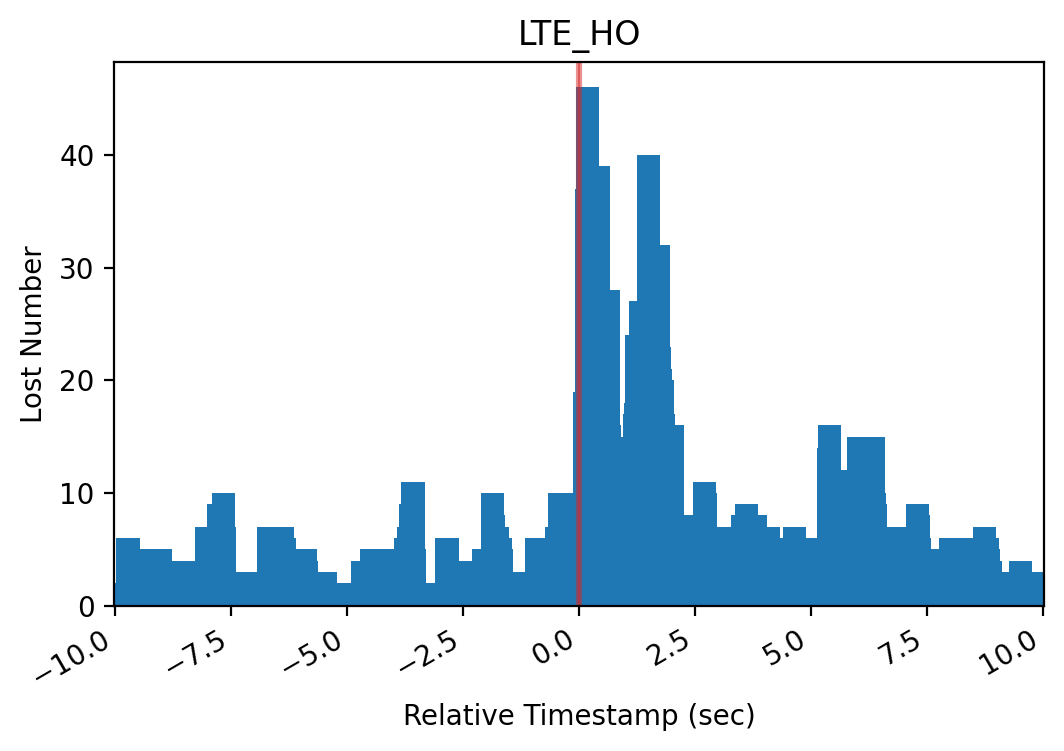

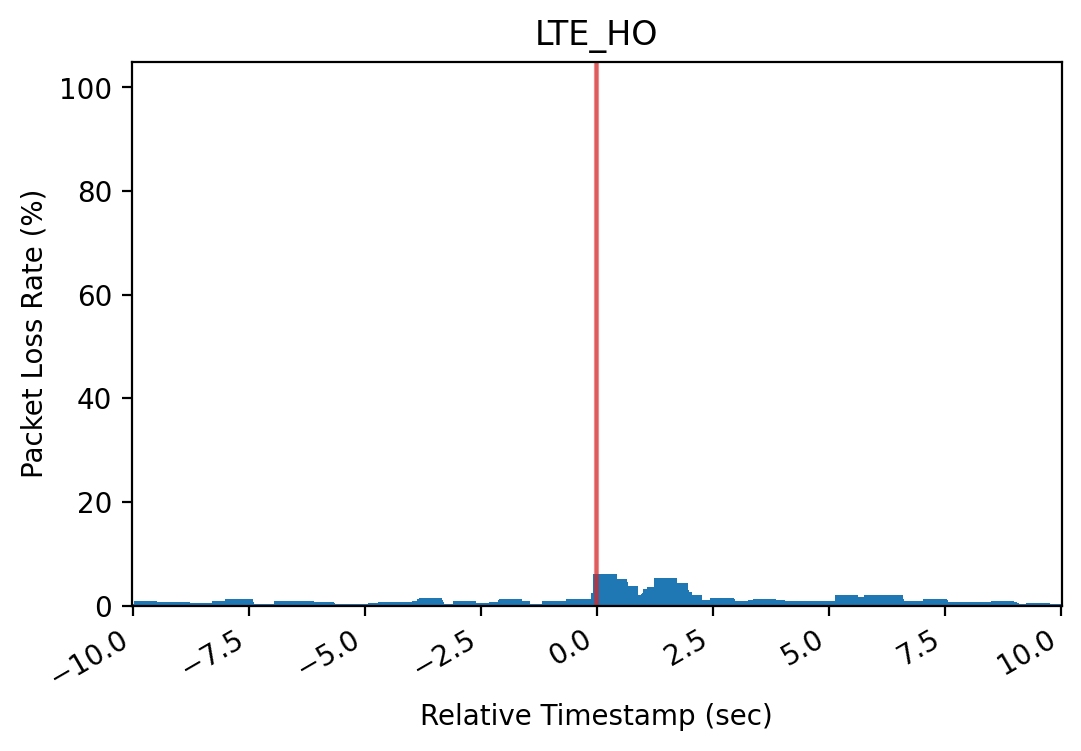

MN_HO
Avg Duration: 0.018692149 seconds
HO Count: 1033


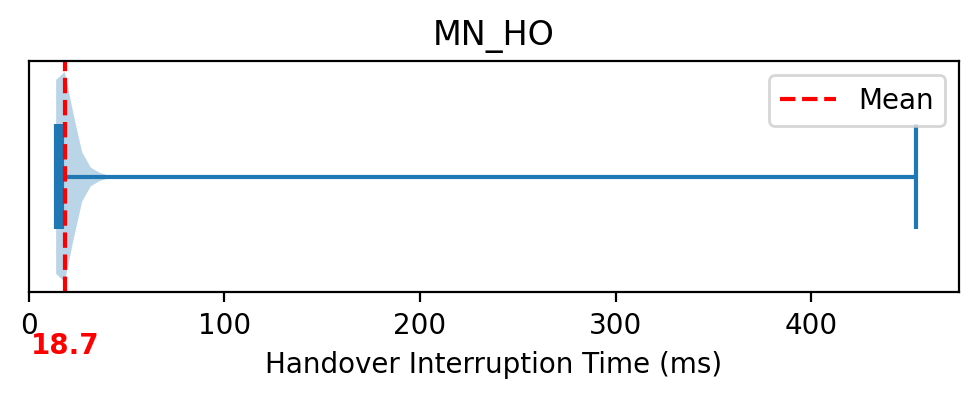

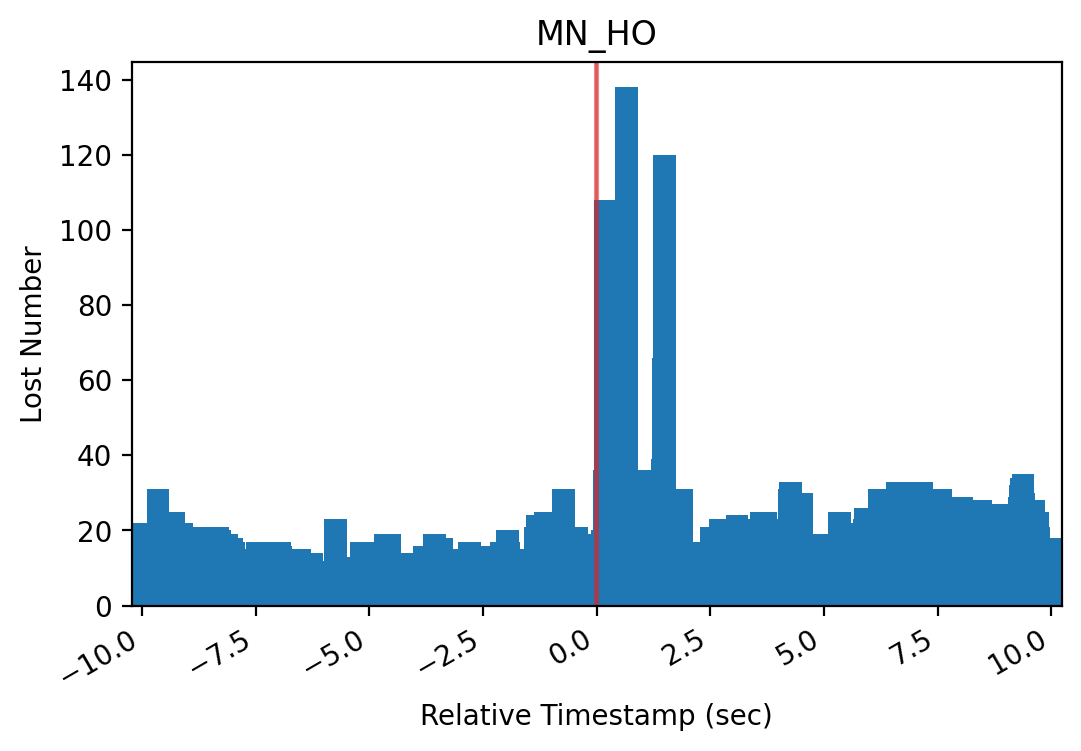

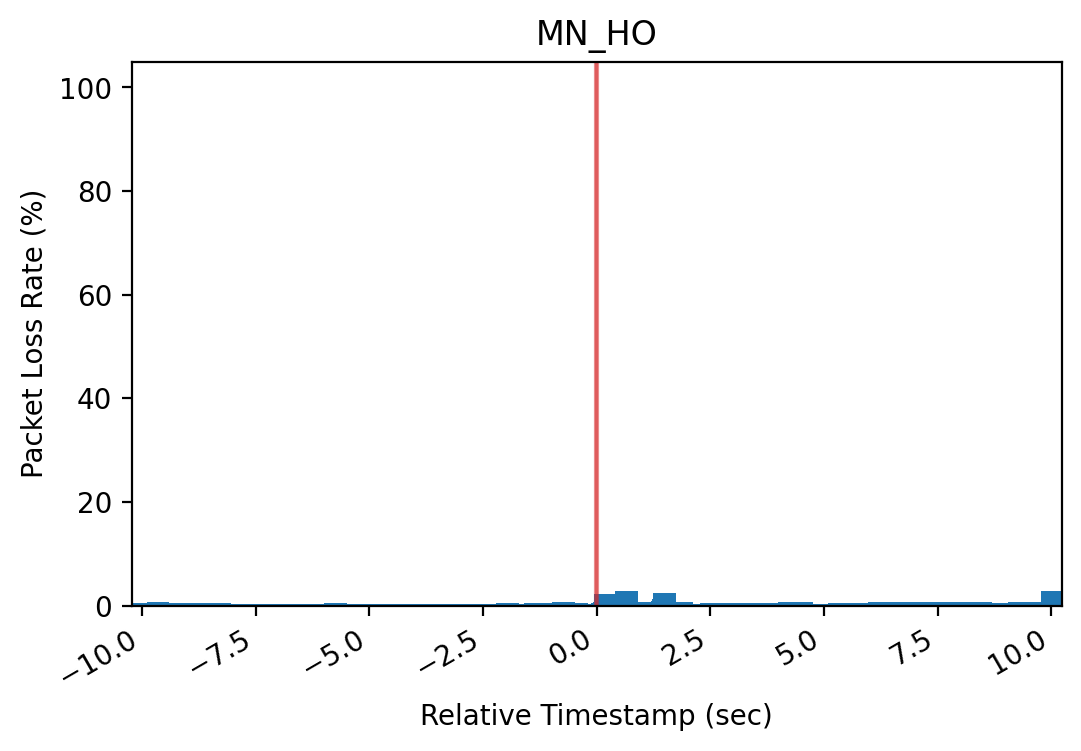

SN_HO
Avg Duration: 0.014638668 seconds
HO Count: 1091


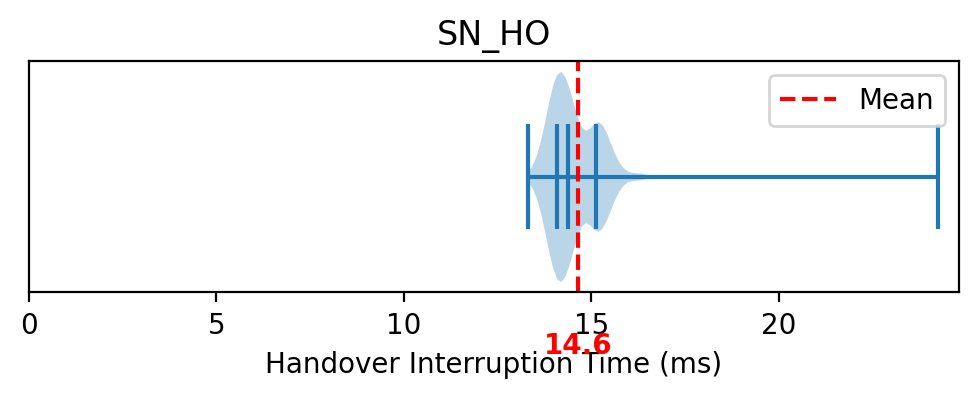

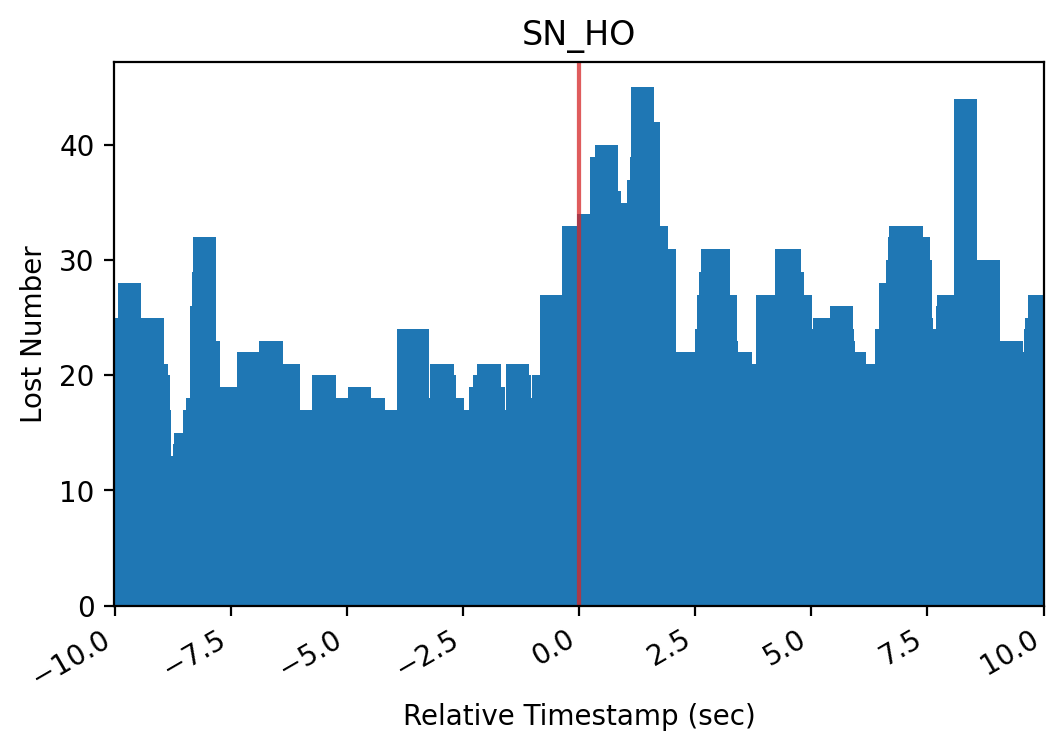

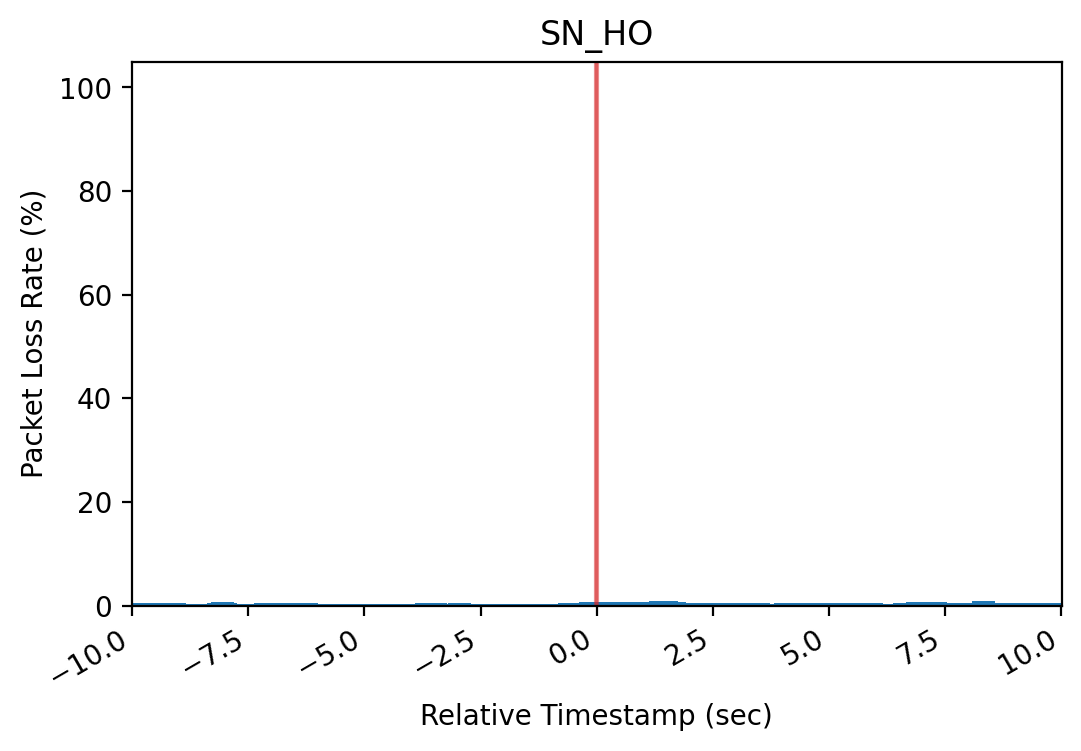

SN_Rel
Avg Duration: 0.022316417 seconds
HO Count: 12


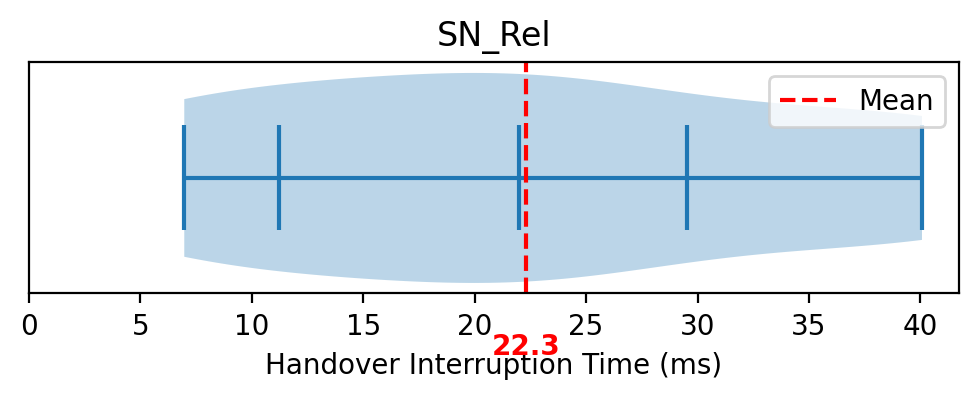

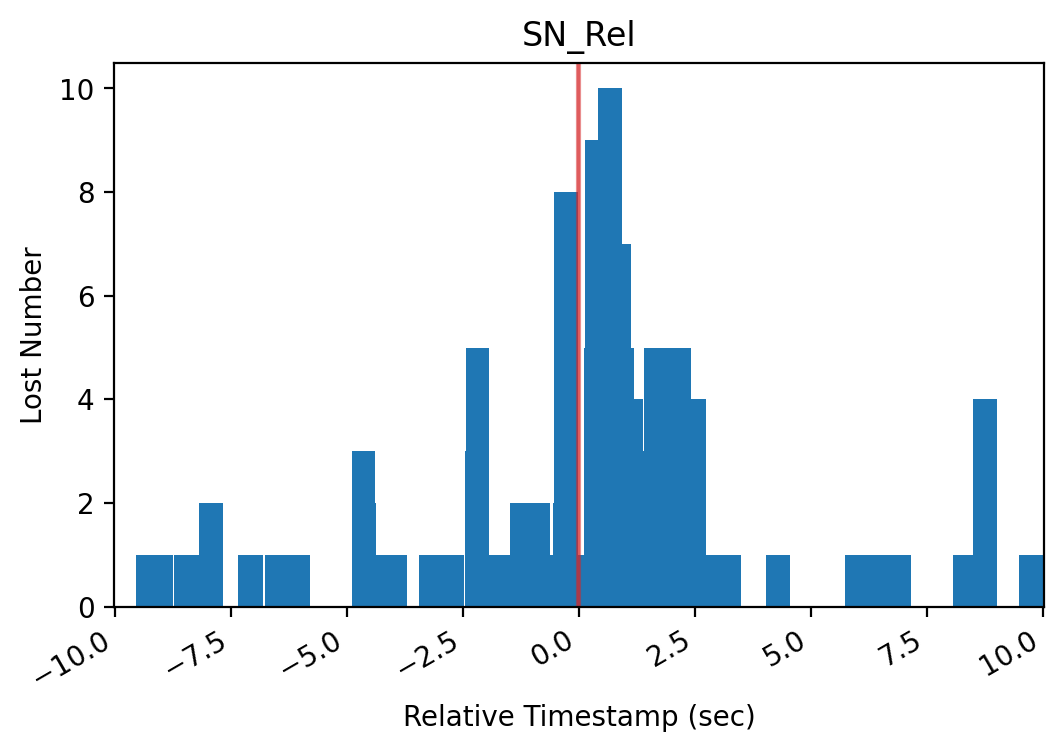

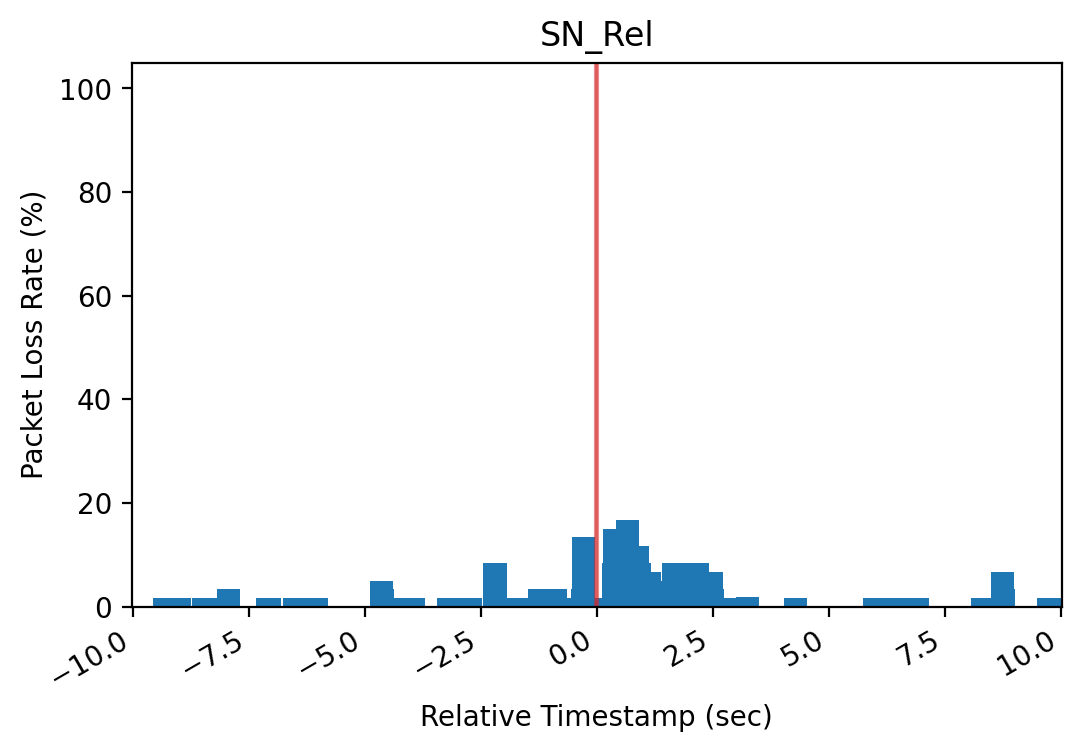

SN_Setup
Avg Duration: 0.02776141 seconds
HO Count: 284


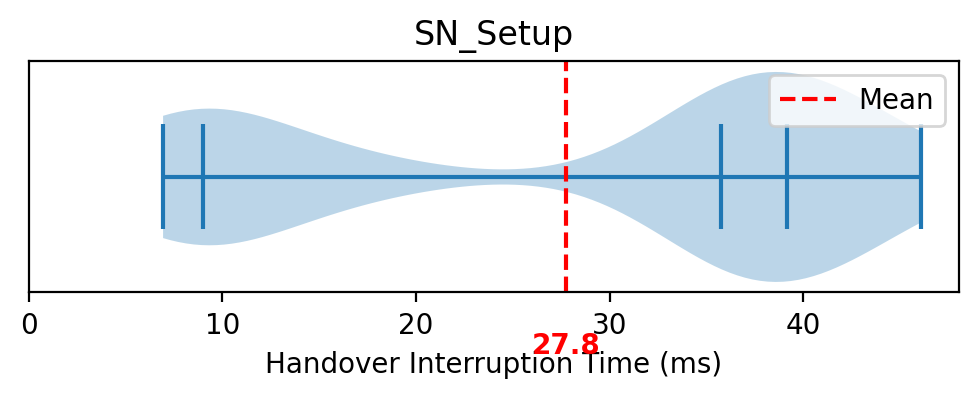

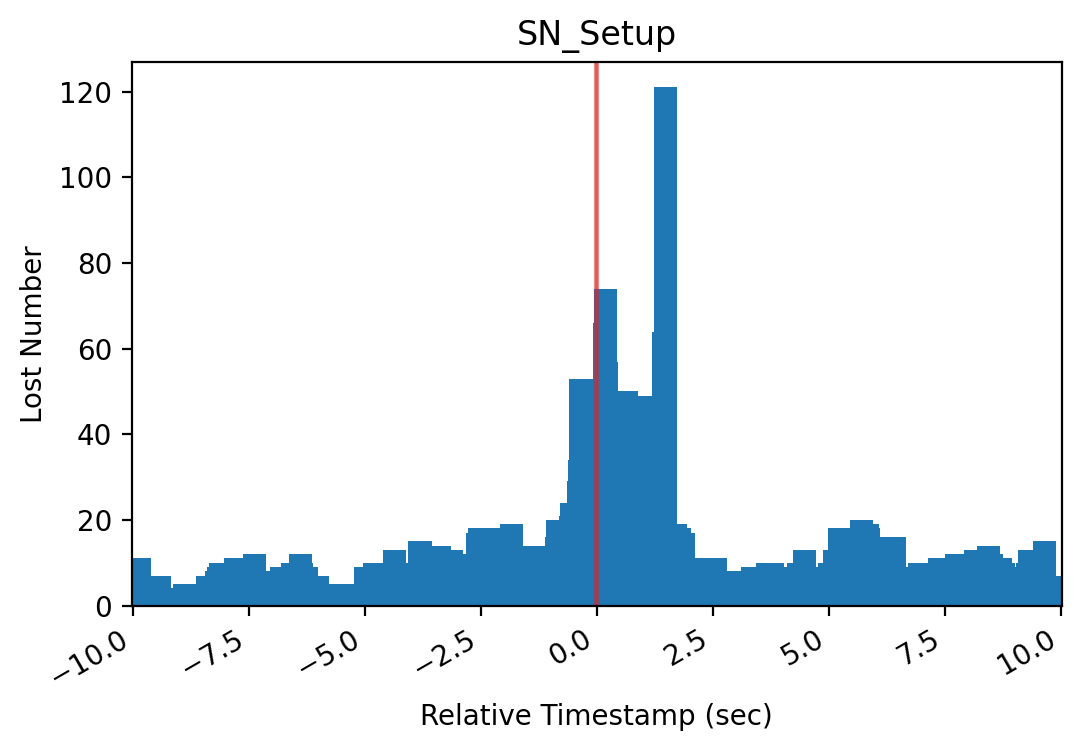

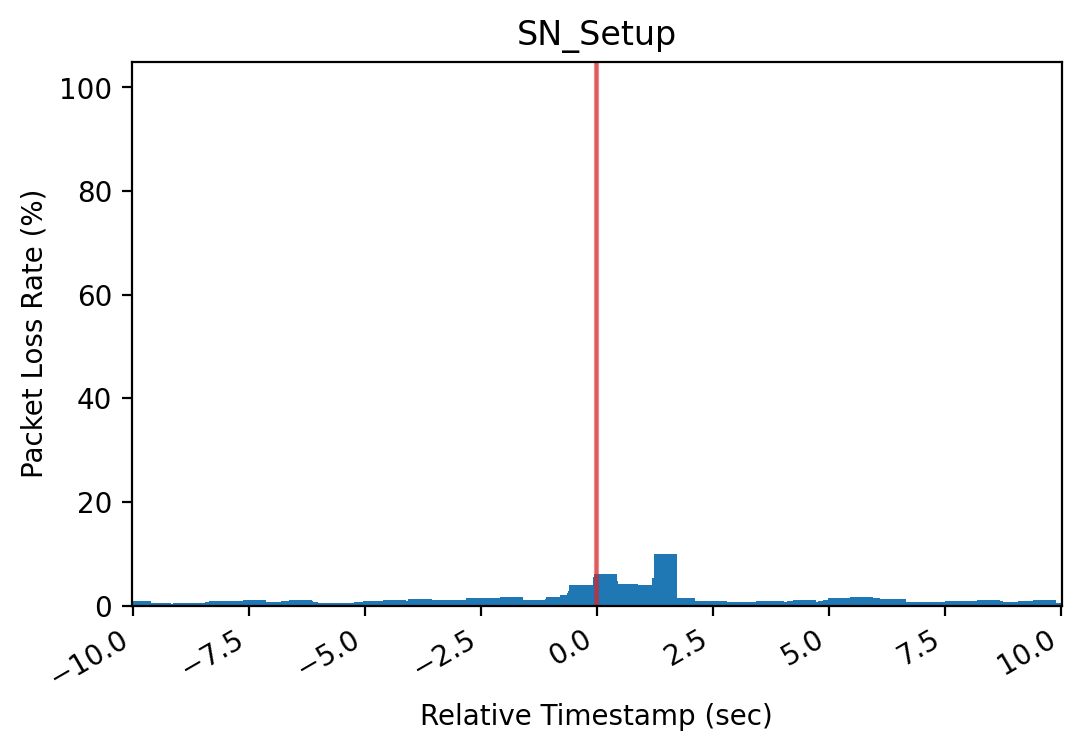

SN_Rel_MN_HO
Avg Duration: 0.01653786 seconds
HO Count: 405


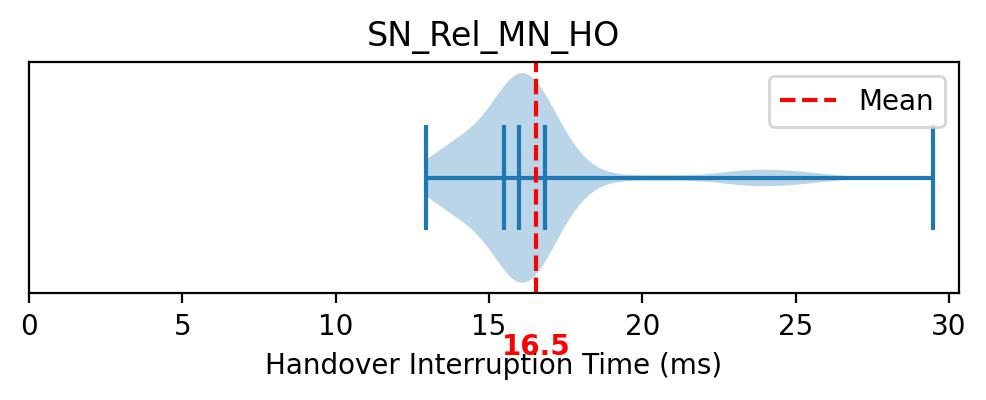

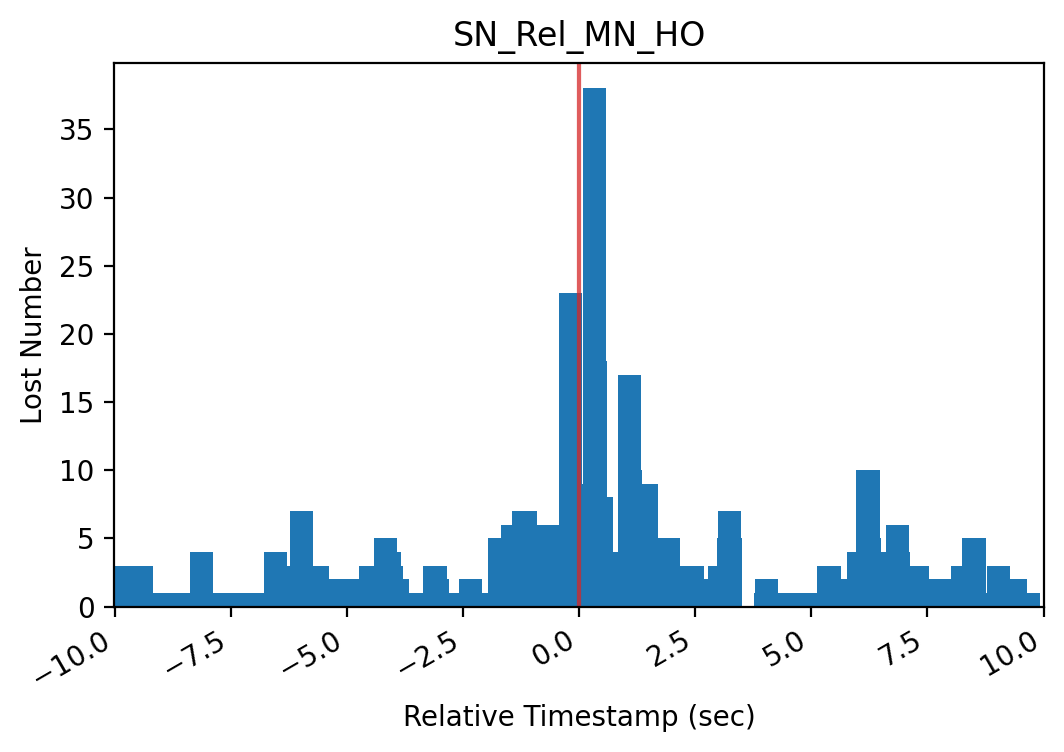

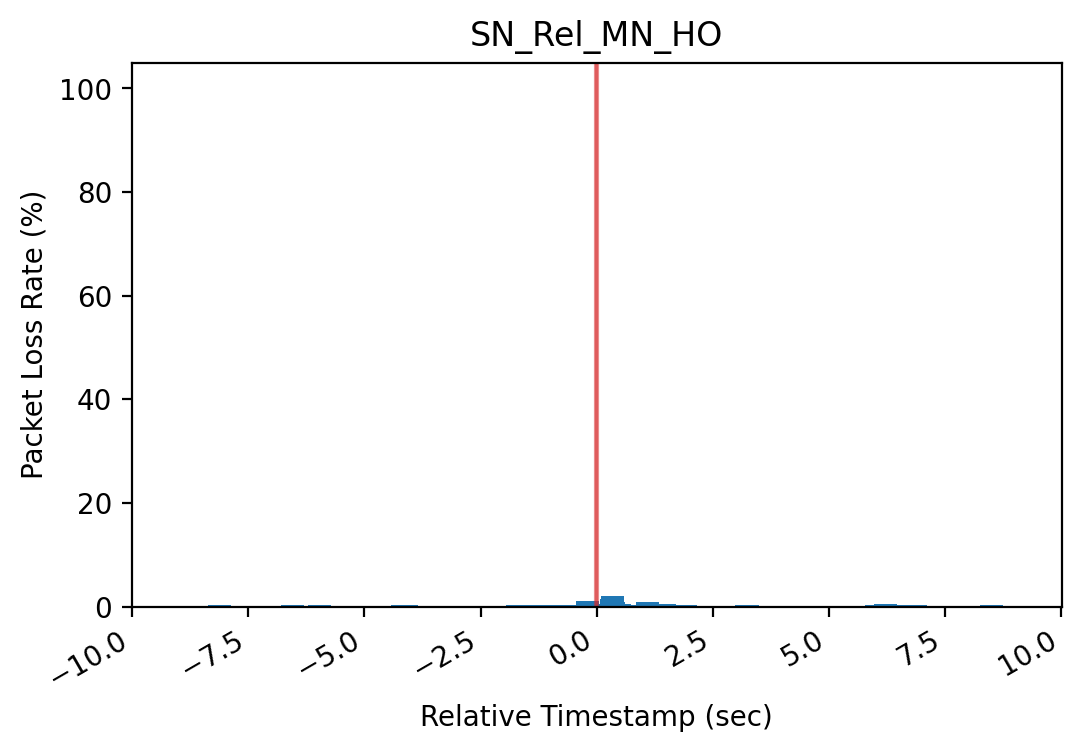

SCG_Failure_t310-Expiry (0)
Avg Duration: 0.0 seconds
HO Count: 3


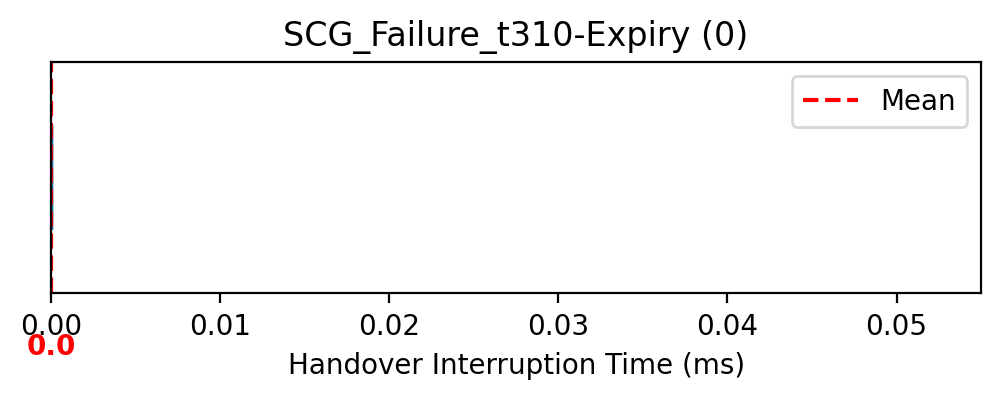

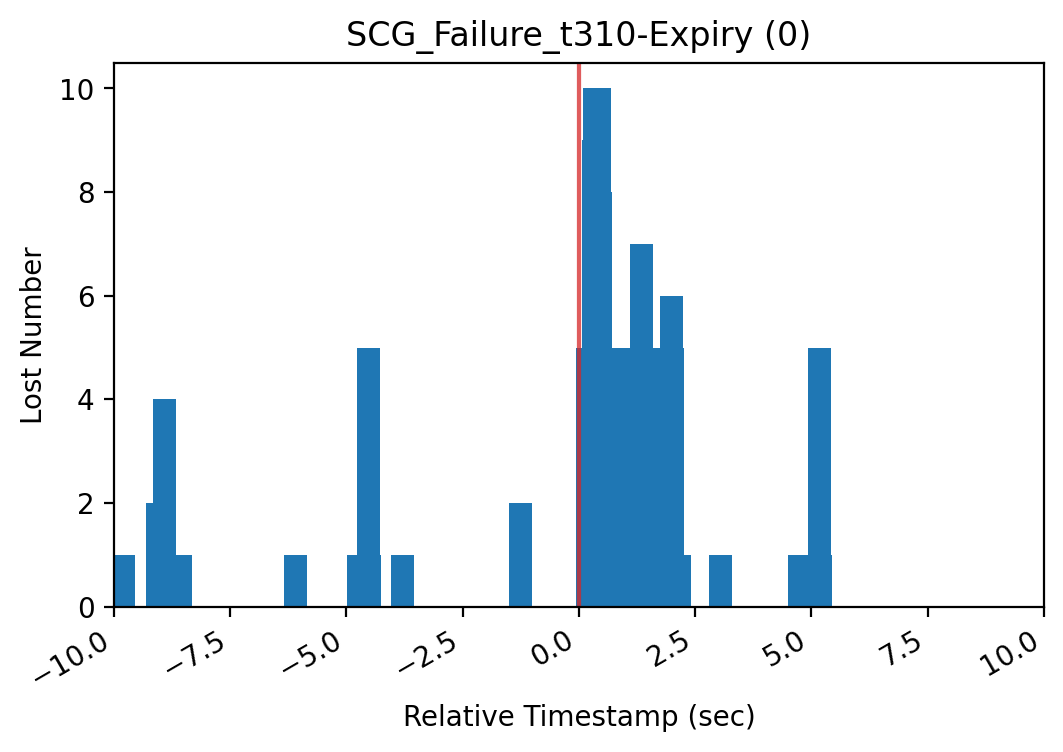

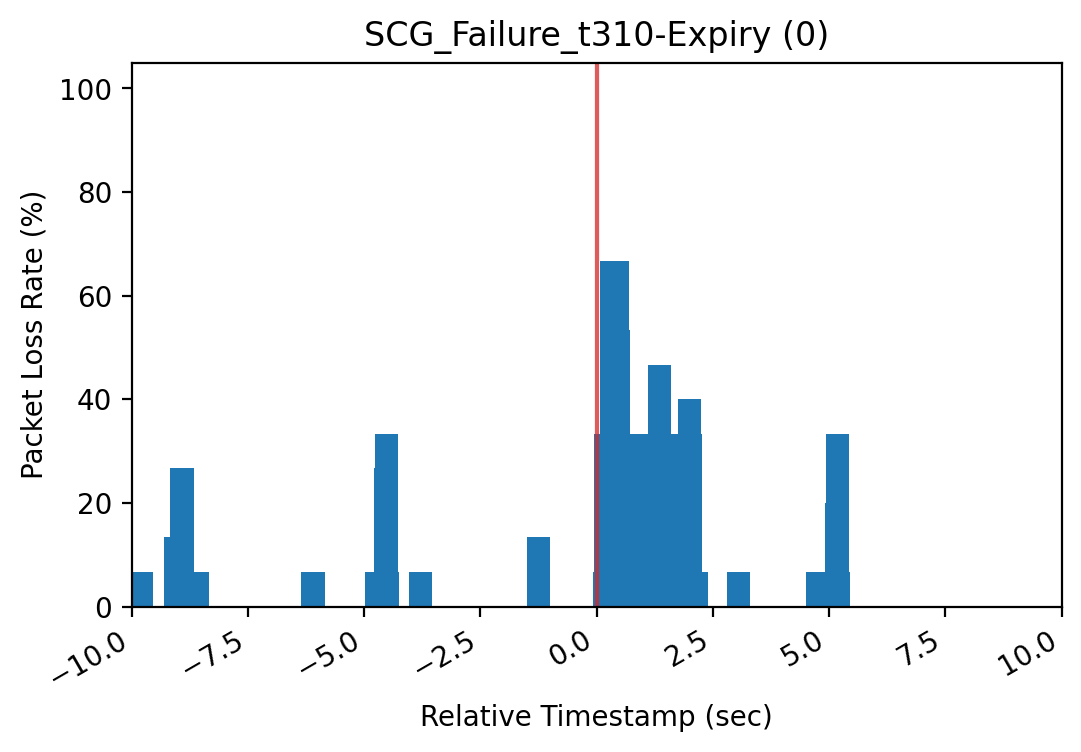

SCG_Failure_synchReconfigFailureSCG (3)
Avg Duration: 0.0 seconds
HO Count: 8


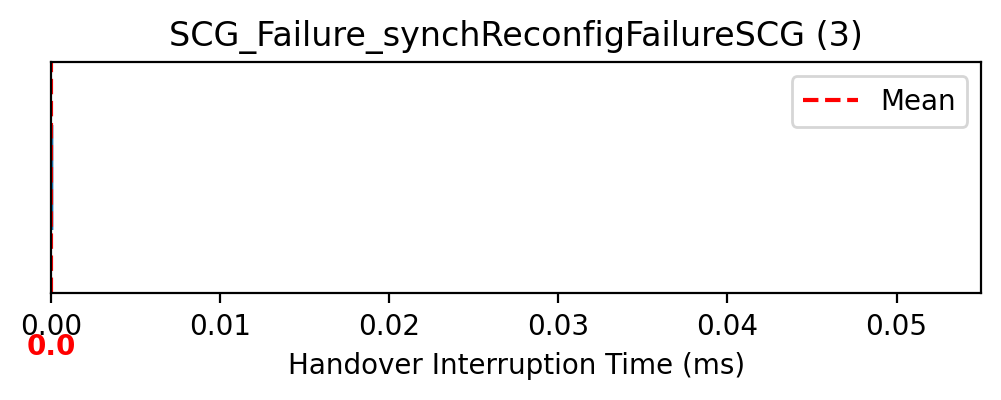

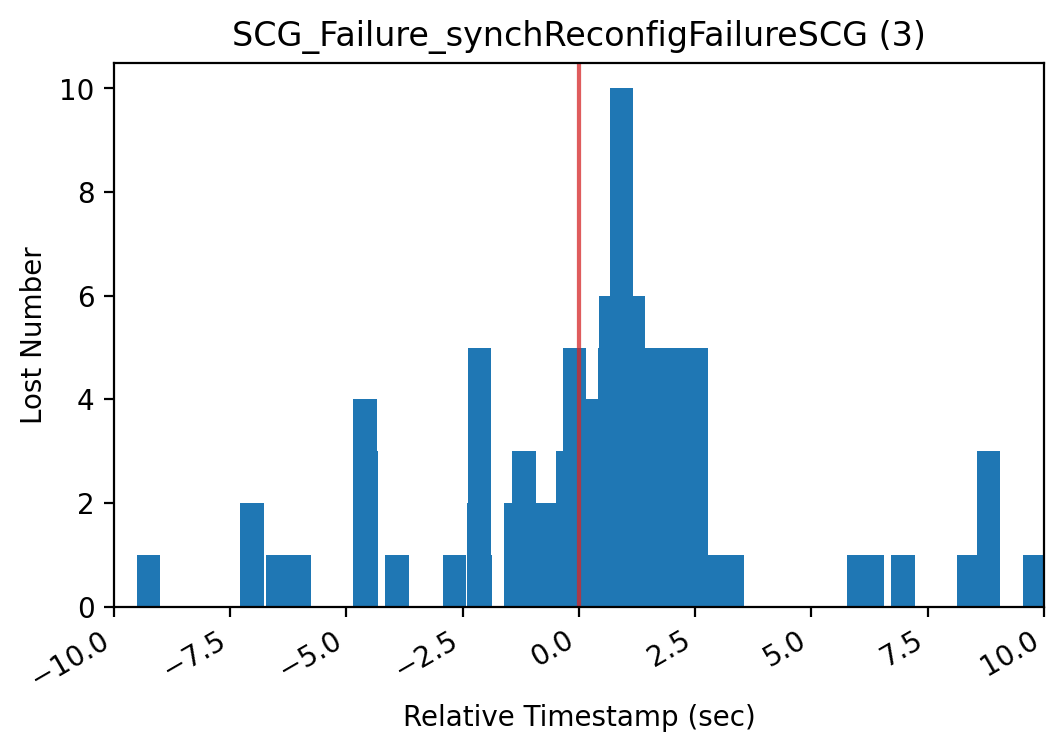

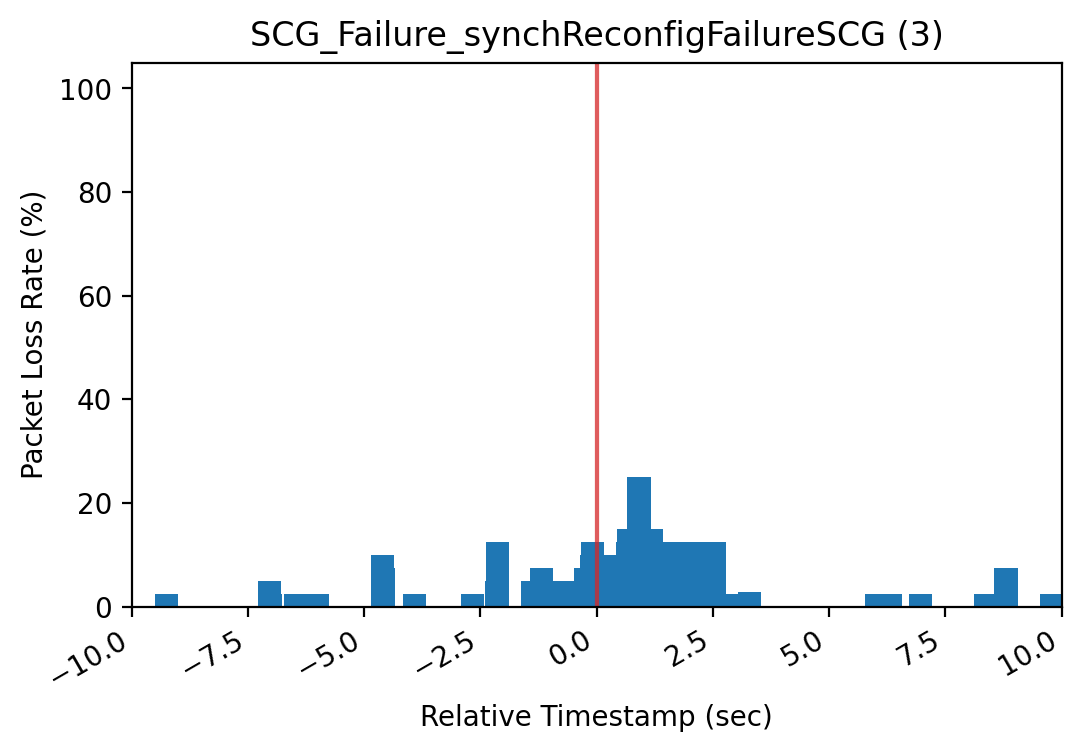

MCG_Failure_handoverFailure (1)
Avg Duration: 0.0808181 seconds
HO Count: 11


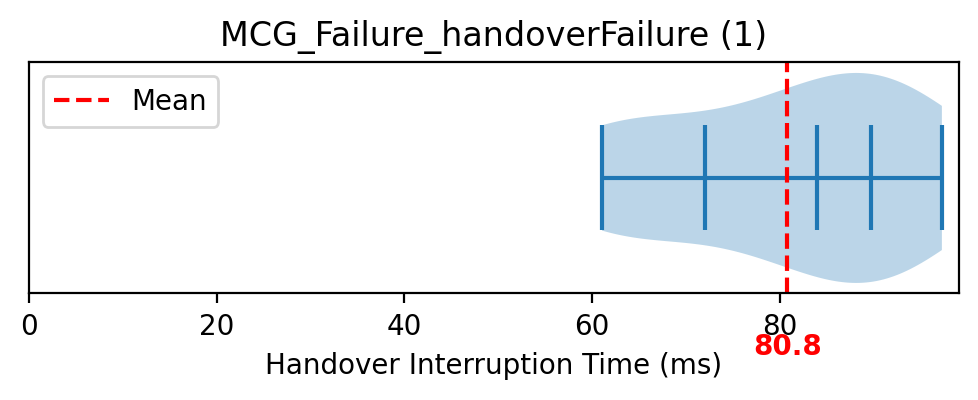

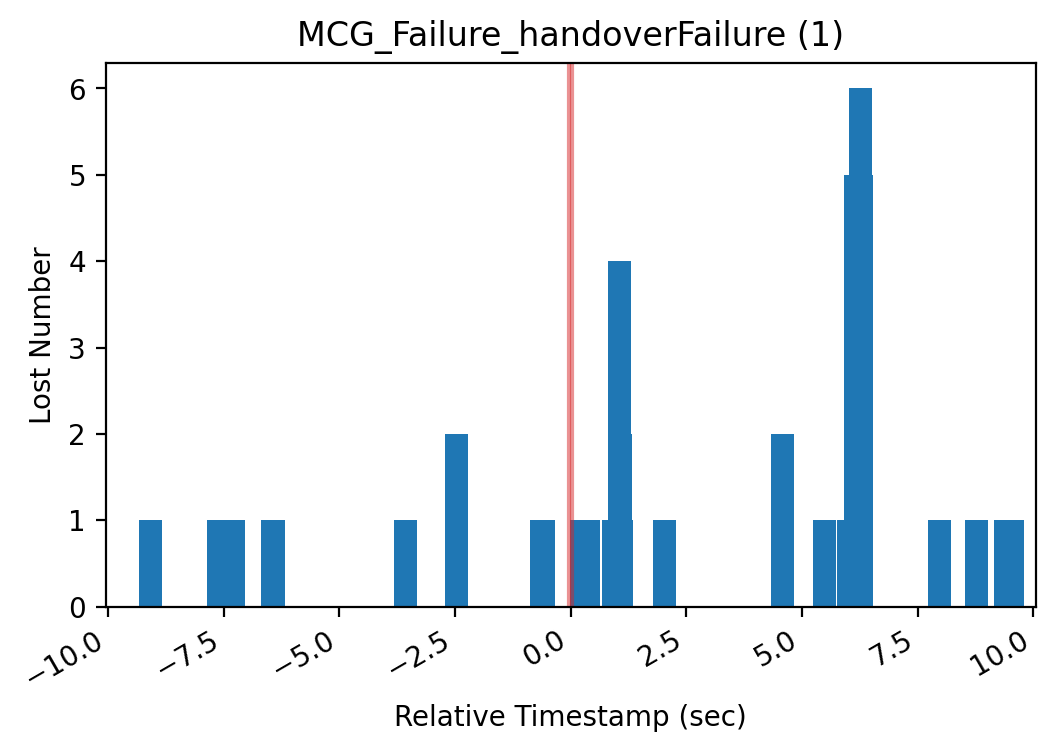

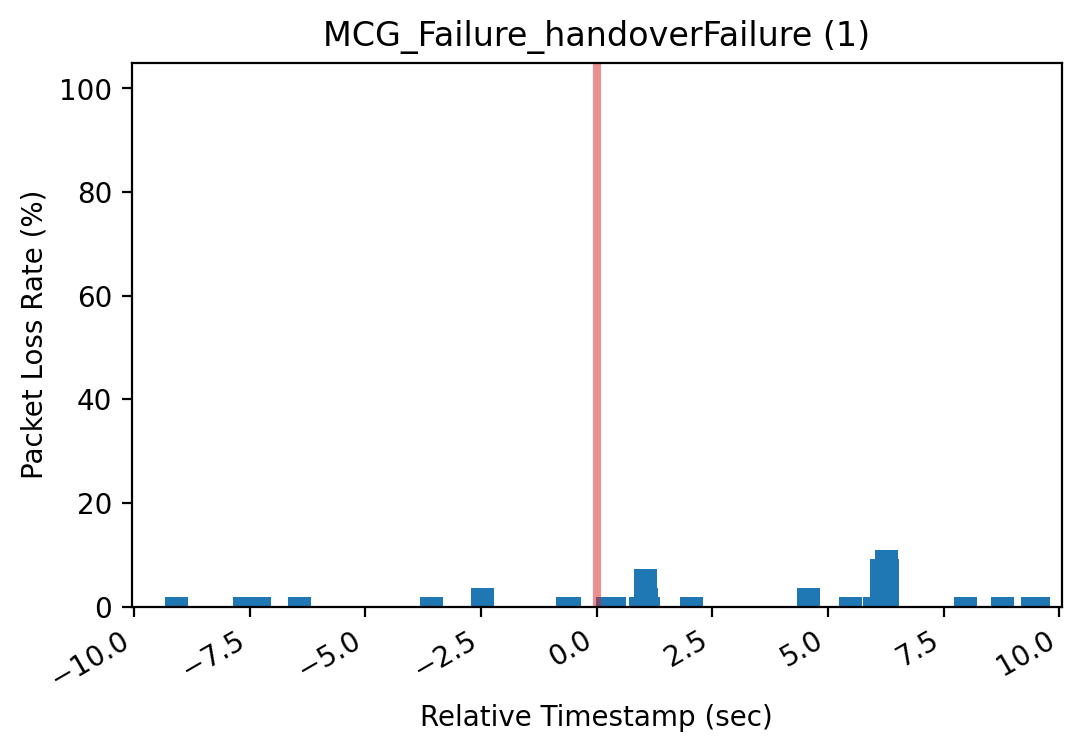

MCG_Failure_otherFailure (2)
Avg Duration: 0.07740378 seconds
HO Count: 118


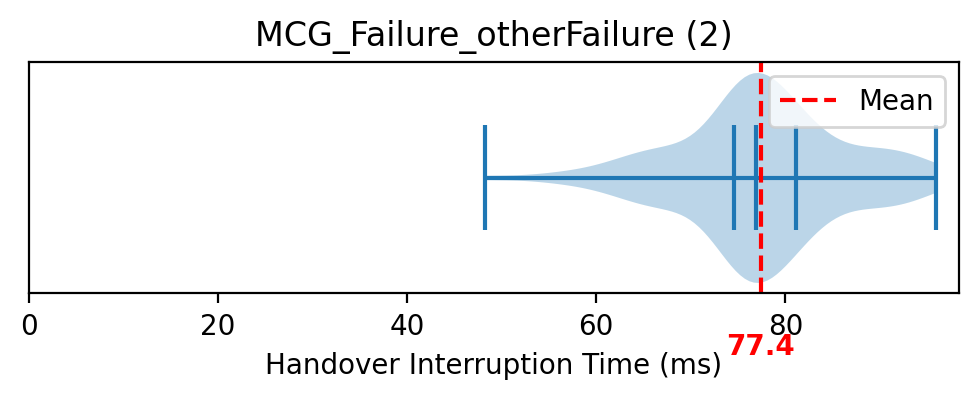

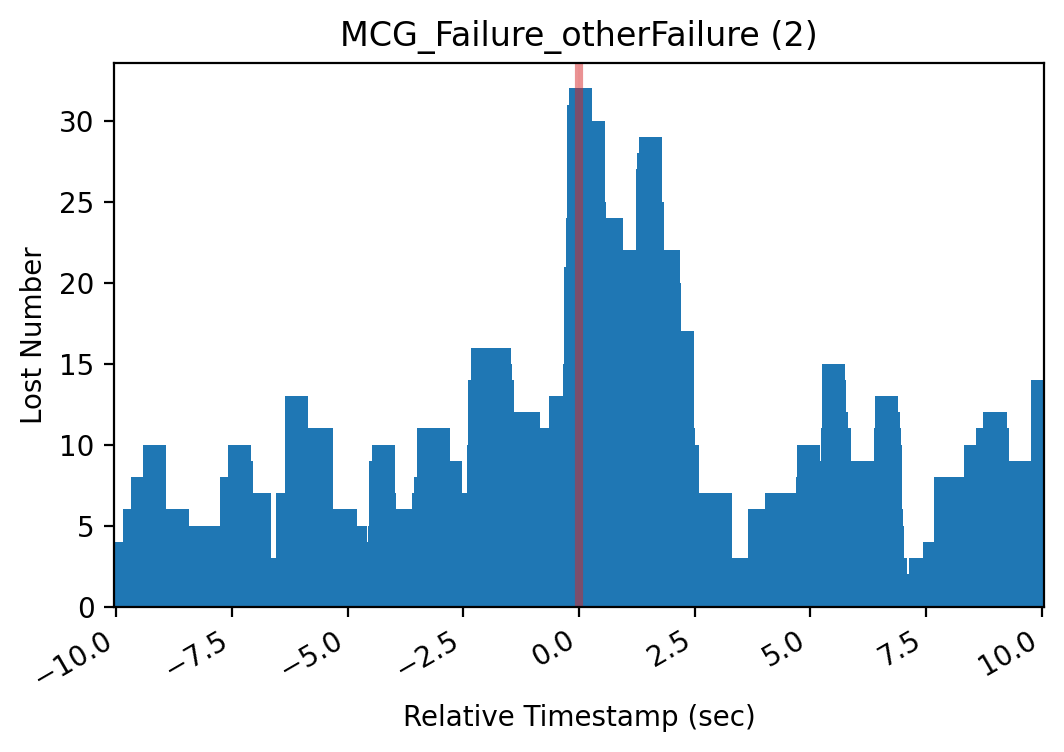

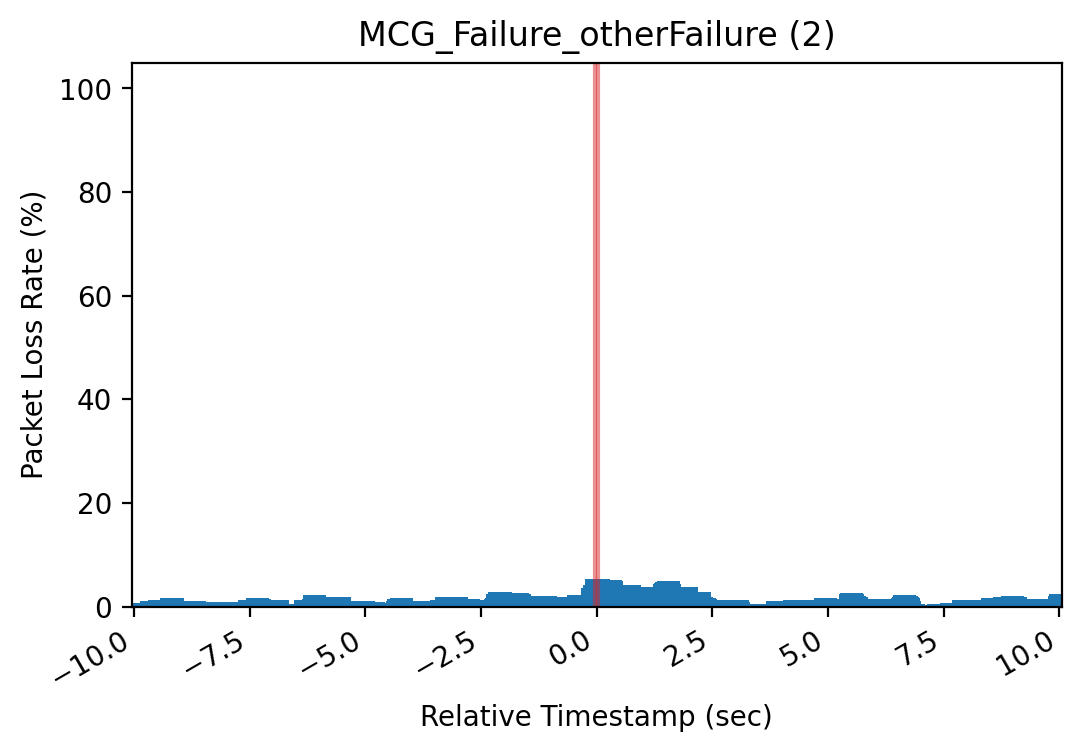

NAS_Recovery_otherFailure (2)
Avg Duration: 0.46772766 seconds
HO Count: 3


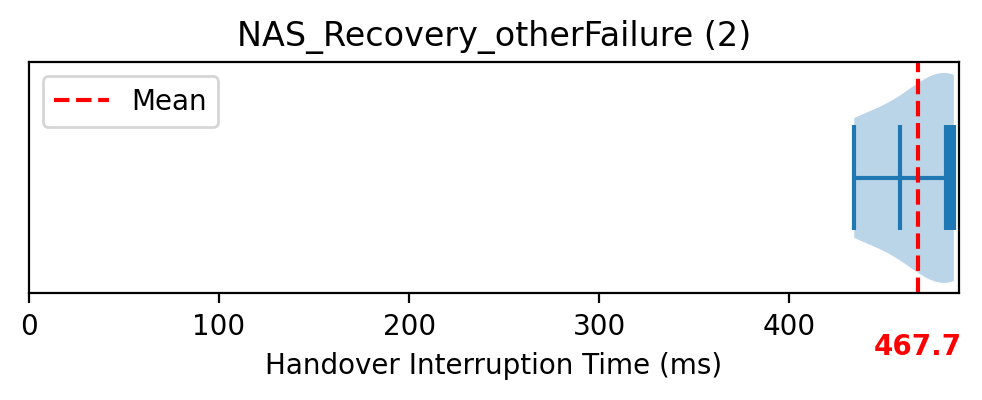

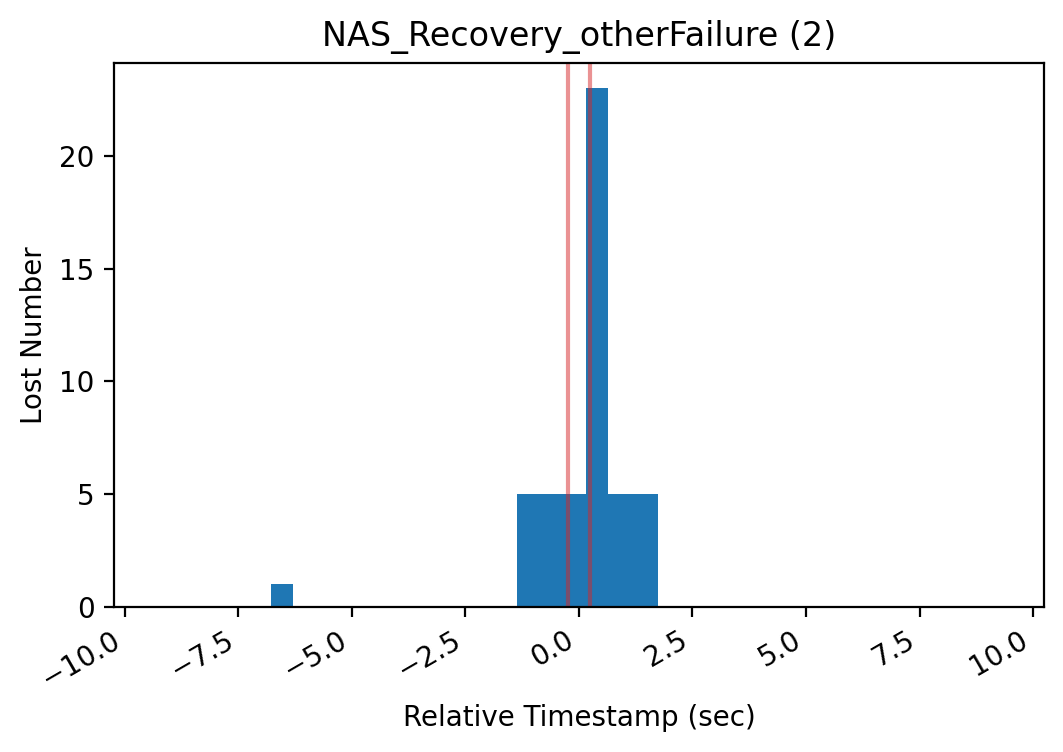

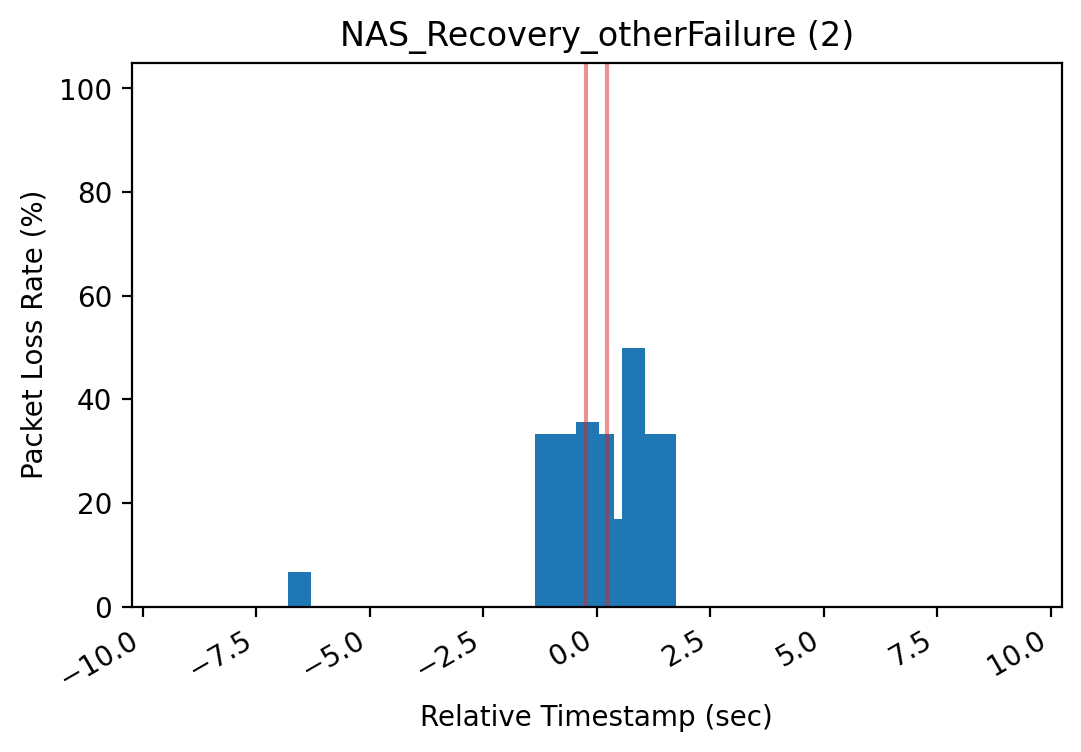

In [ ]:
for tag in sorter:
    if len(D[tag]['intrs']) == 0:
        continue
    print('===================================')
    print(tag)
    table, intr = merge_profile(D[tag]['tables'], D[tag]['intrs'])
    print('Avg Duration:', intr, 'seconds')
    print('HO Count:', sum(D[tag]['count']))
    # display(table)
    plot_intrs(D[tag]['intrs'], tag)
    plot_profile(table, intr=intr, title=tag, mode='lost')
    plot_profile(table, intr=intr, title=tag, mode='plr')

### Payload Time

In [108]:
sorter = ['LTE_HO','MN_HO','SN_HO','MNSN_HO','SN_Rel','SN_Setup','SN_Rel_MN_HO','SN_Setup_MN_HO',
          'SCG_Failure_t310-Expiry (0)','SCG_Failure_randomAccessProblem (1)','SCG_Failure_rlc-MaxNumRetx (2)','SCG_Failure_synchReconfigFailureSCG (3)',
          'SCG_Failure_scg-ReconfigFailure (4)','SCG_Failure_srb3-IntegrityFailure (5)','SCG_Failure_other-r16 (6)',
          'MCG_Failure_reconfigurationFailure (0)','MCG_Failure_handoverFailure (1)','MCG_Failure_otherFailure (2)',
          'NAS_Recovery_reconfigurationFailure (0)','NAS_Recovery_handoverFailure (1)','NAS_Recovery_otherFailure (2)']

D = {}
for tag in sorter:
    D[tag] = {'tables': [], 'intrs': [], 'count': []}

for (exp, traces), devices, schemes in zip(exps.items(), _devices, _schemes):
    for trace in traces:
        for j, (dev, schm) in enumerate(zip(devices, schemes)):
            ## read downlink
            data = os.path.join(datadir, exp, dev, trace, 'data', 'udp_uplk_loss_latency.csv')
            print(data, os.path.isfile(data))
            df_ul = pd.read_csv(data)
            df_ul = set_data(df_ul)
            ## read handover
            path = os.path.join(datadir, exp, dev, trace, 'data')
            data = os.path.join(path, [s for s in os.listdir(path) if s.startswith('diag_log_') and s.endswith('_rrc.csv')][0])
            print(data, os.path.isfile(data))
            df_ho = pd.read_csv(data)
            df_ho, _, _ = mi_parse_ho(df_ho, tz=8)
            df_ho['ho_type0'] = df_ho['ho_type'].astype('string')
            df_ho.loc[df_ho['cause'].notna(), 'ho_type0'] = df_ho['ho_type'].astype('string') + '_' + df_ho['cause'].astype('string')
            df_ho['ho_type0'] = df_ho['ho_type0'].astype('category')
            ## start processing
            for tag in sorter:
                # print('===================================')
                # print(tag)
                df = df_ho.query('ho_type0 == @tag').copy().reset_index(drop=True)
                tables = []
                intrs = []
                if not df.empty:
                    cname = ' '.join(df.at[0, 'ho_type'].split('_')) + ': ' + df.at[0, 'cause'] if pd.notna(df.at[0, 'cause']) else ' '.join(df.at[0, 'ho_type'].split('_'))
                    for i, row in df.iterrows():
                        start, end = df.at[i, 'start'], df.at[i, 'end']
                        intr = df.at[i, 'intr'] if pd.notna(df.at[i, 'intr']) else 0
                        table, intv = setup_profile(df_ul, start, end, mode='pyl', sec=10)
                        # print(intr)
                        # display(table)
                        tables.append(table)
                        intrs.append(intr)
                    table, intr = merge_profile(tables, intrs)
                    # print('Avg Duration:', intr, 'seconds')
                    # display(table)
                    # plot_profile(table, intr=intr, title=cname, mode='lost')
                    # plot_profile(table, intr=intr, title=cname, mode='plr')
                else:
                    table = pd.DataFrame(columns=['cat_id','tx_count','lost','PLR'])
                    table['cat_id'] = table['cat_id'].astype('float32')
                    table['tx_count'] = table['tx_count'].astype('Int32')
                    table['lost'] = table['lost'].astype('Int32')
                    table['PLR'] = table['PLR'].astype('float32')
                    intr = 0
                # print('HO Count:', len(df))
                D[tag]['tables'].append(table)
                D[tag]['intrs'] = [*D[tag]['intrs'], *intrs]
                D[tag]['count'].append(len(df))

/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-15/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#02/data/udp_uplk_loss_latency.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-15/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#02/data/diag_log_qc00_2023-03-15_15-15-41_rrc.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-15/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc02/#02/data/udp_uplk_loss_latency.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-15/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc02/#02/data/diag_log_qc02_2023-03-15_15-15-41_rrc.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-15/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc03/#02/data/udp_uplk_loss_latency.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-15/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc03/#02/data/diag_log_qc03_2023-03-15_15-15-41_rrc.csv True
/Users/jackbedford/Desktop/MOXA/Code/data/2023-03-15/_Bandlock_Udp_B1_B3_B7_B8_RM500Q/qc00/#03/data/udp_uplk_loss_latency.csv True
/Users/jackbedford/Desktop/MOXA/Cod

LTE_HO
Avg Duration: 0.02985257 seconds
HO Count: 155


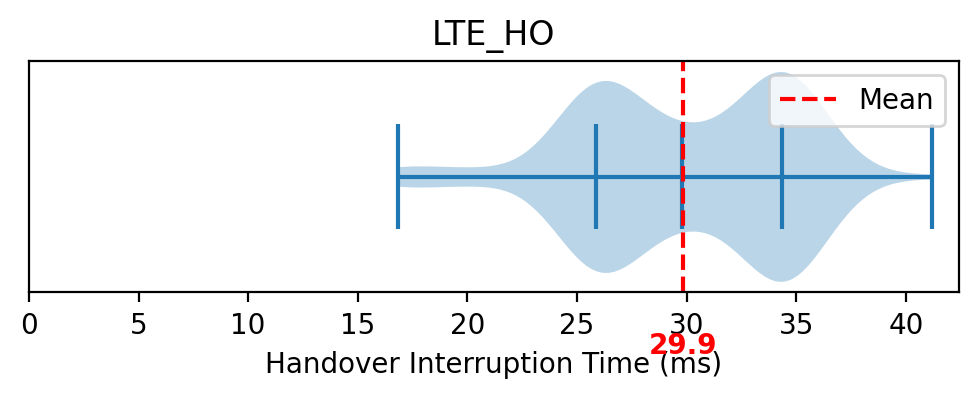

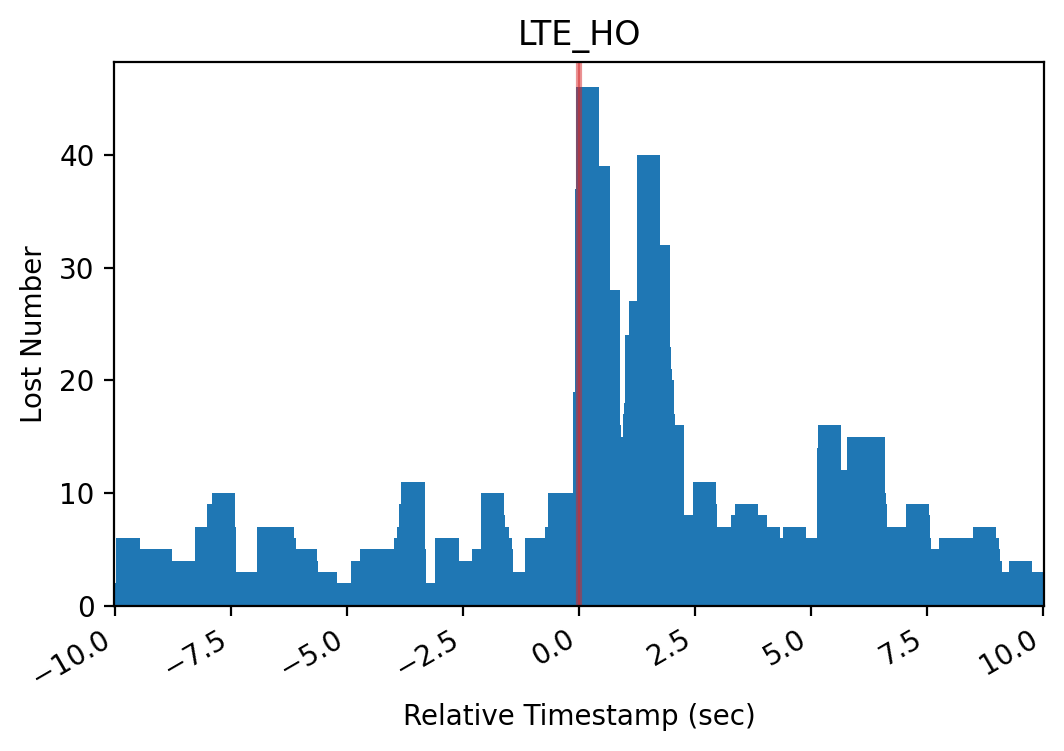

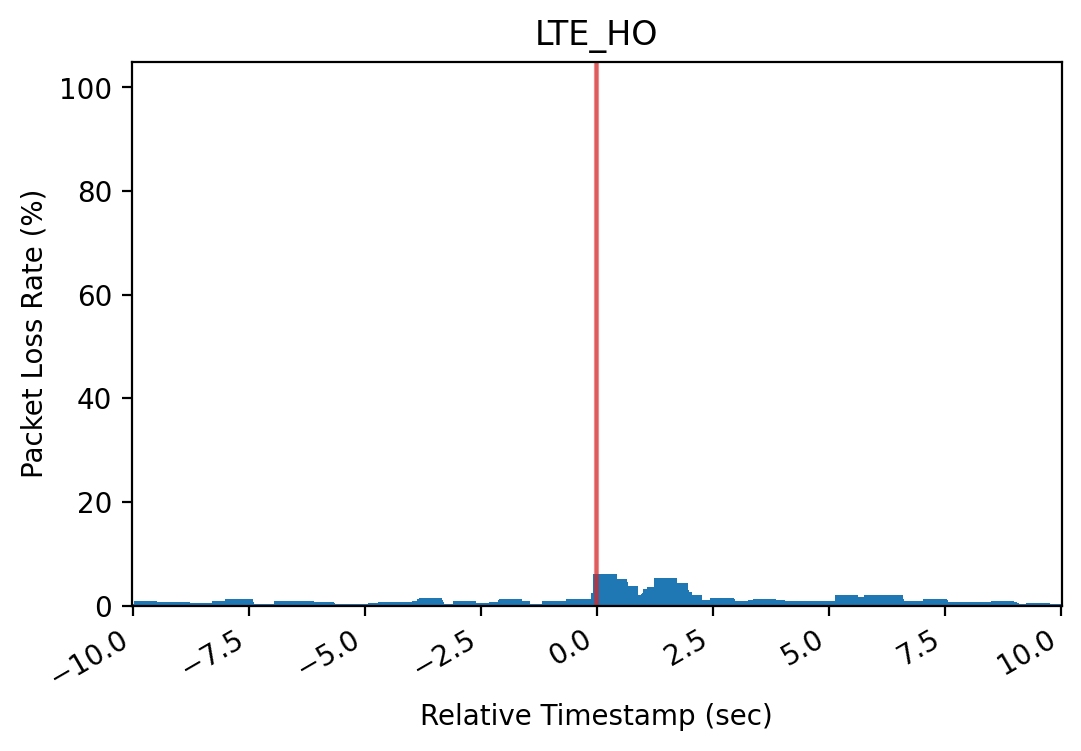

MN_HO
Avg Duration: 0.018692149 seconds
HO Count: 1033


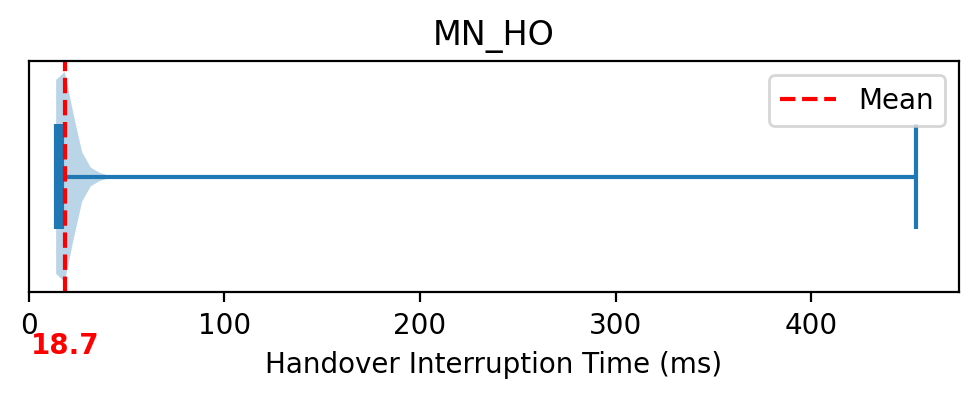

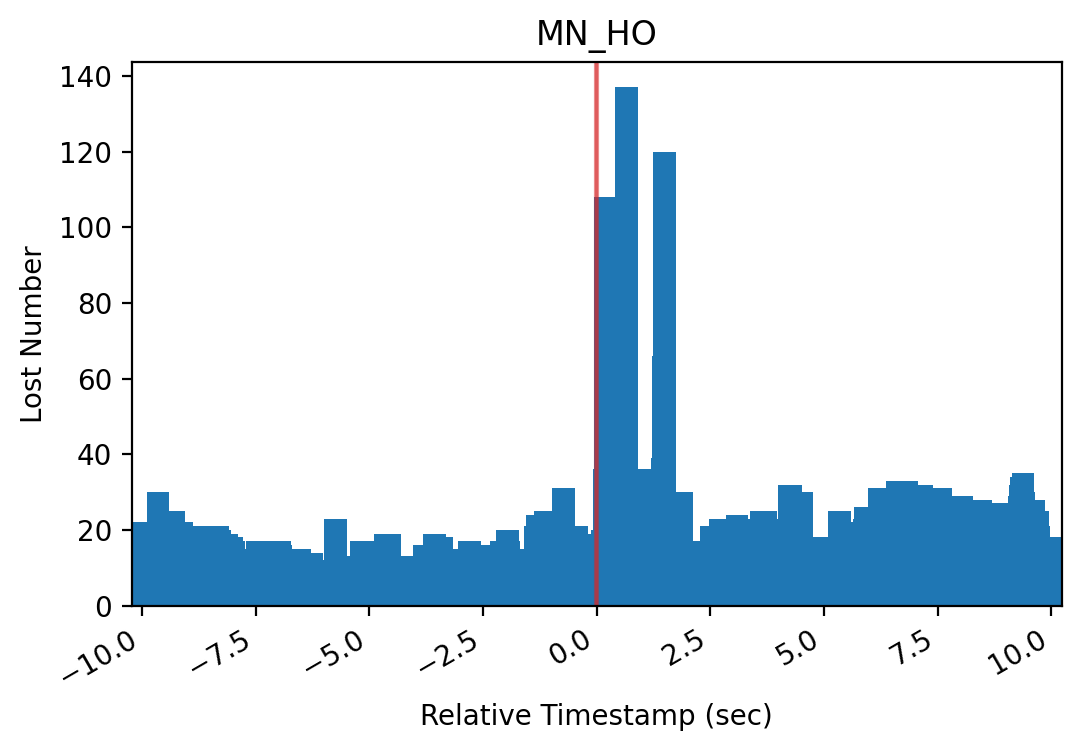

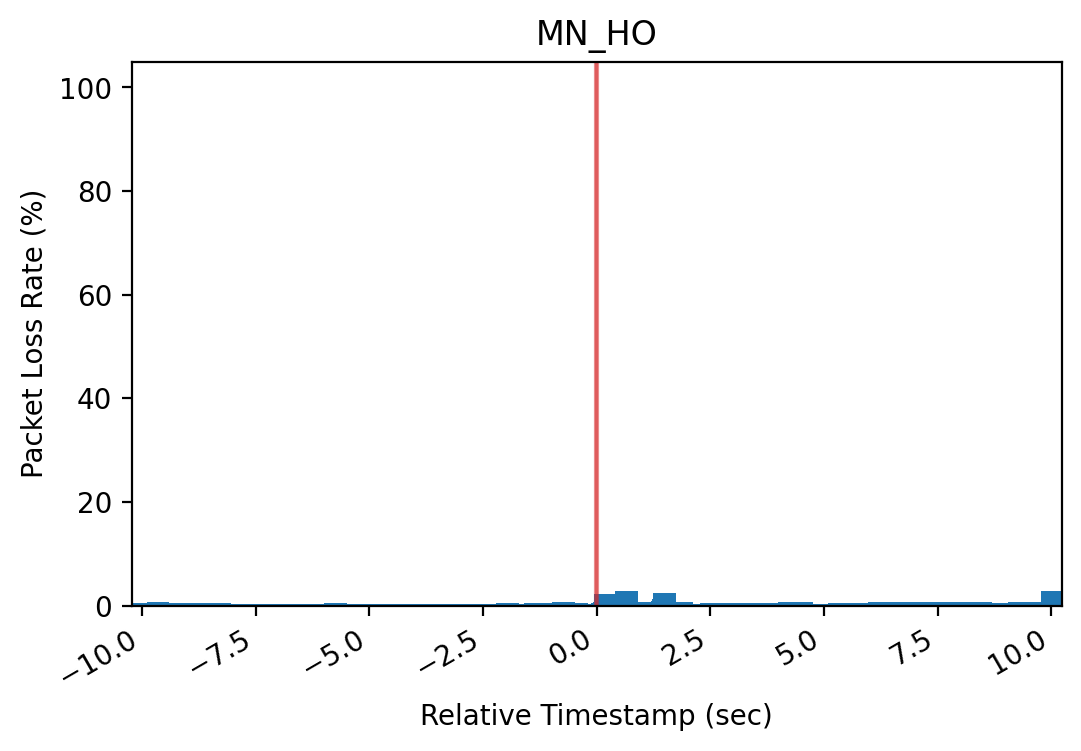

SN_HO
Avg Duration: 0.014638668 seconds
HO Count: 1091


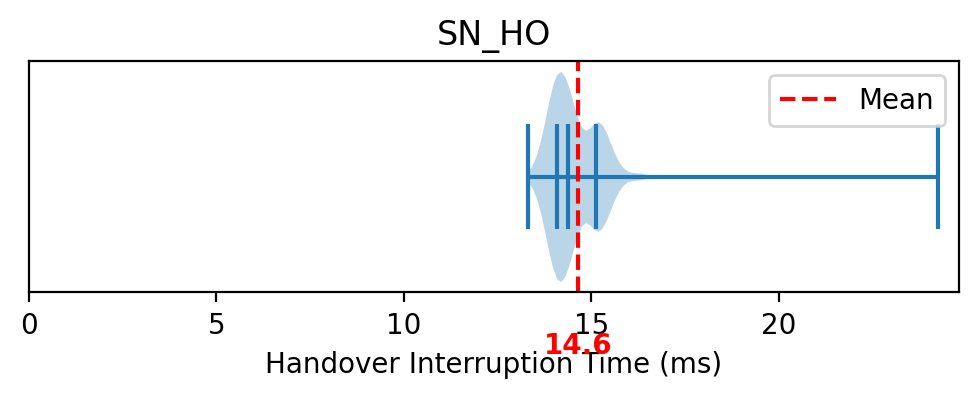

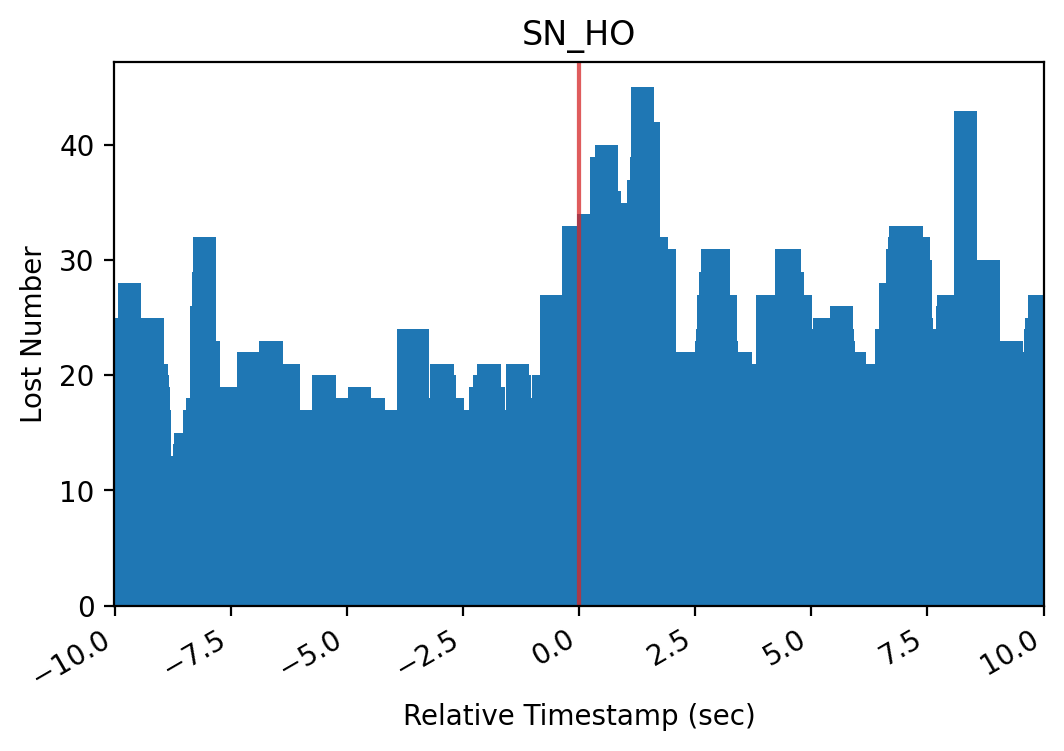

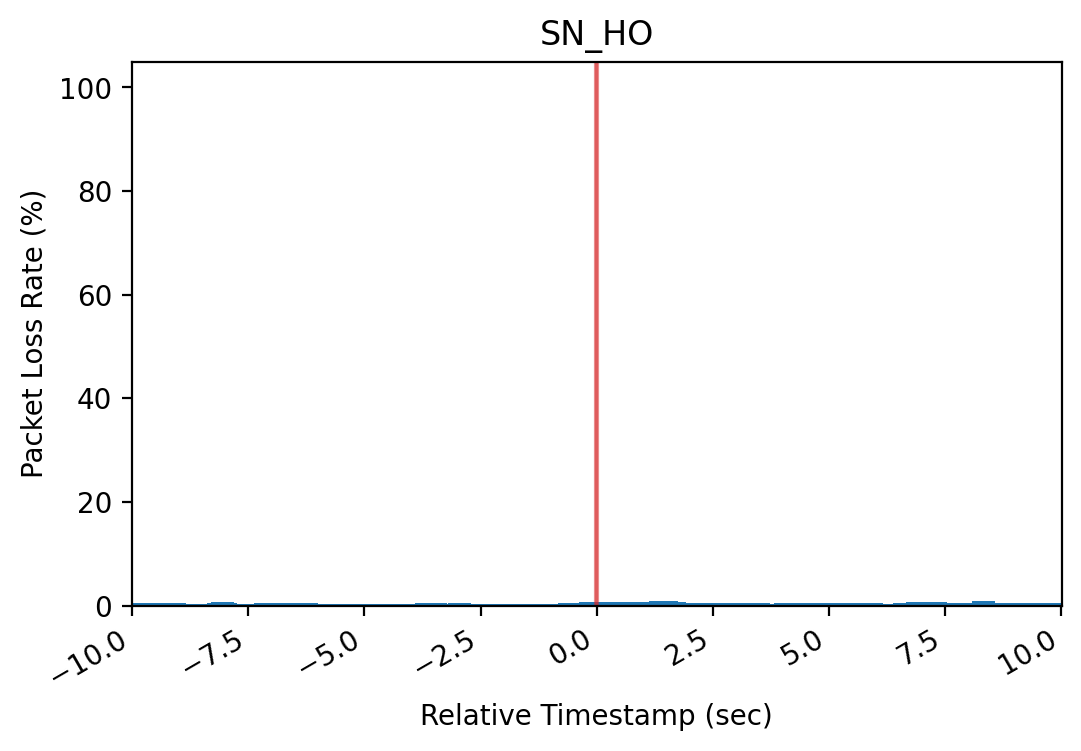

SN_Rel
Avg Duration: 0.022316417 seconds
HO Count: 12


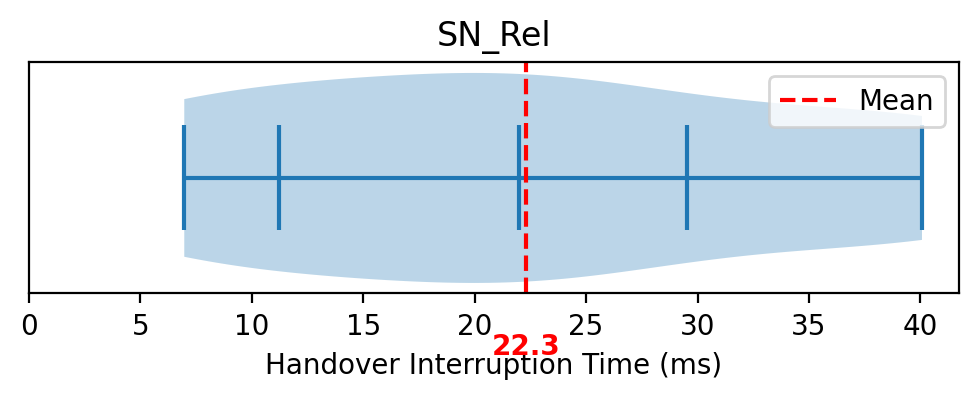

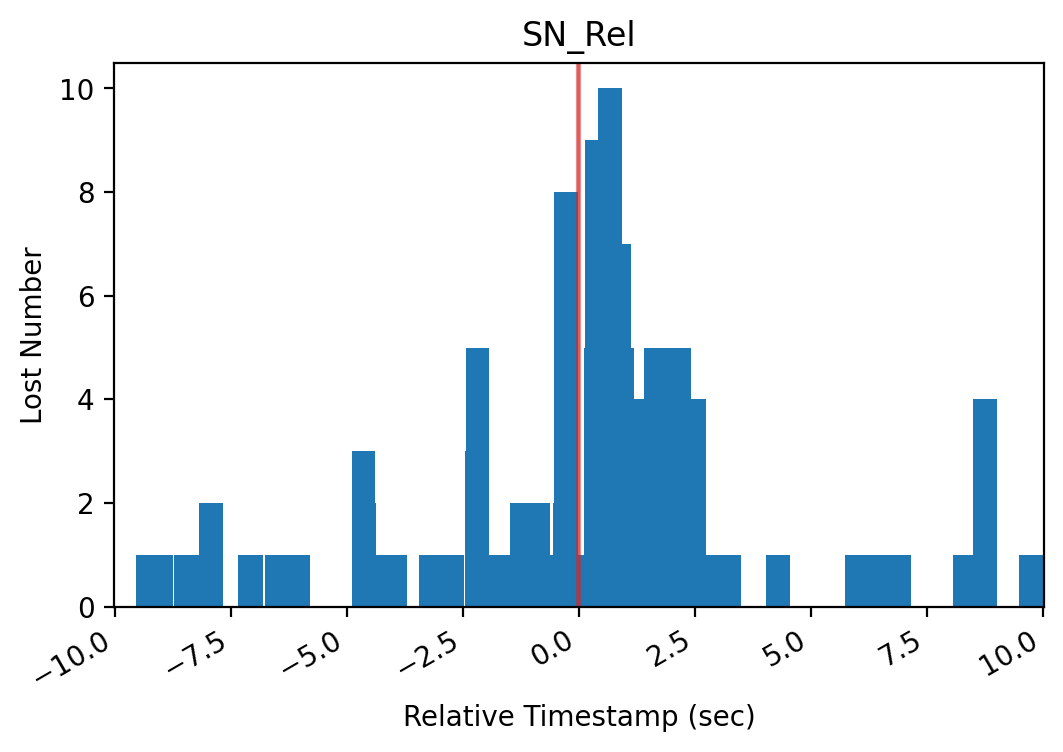

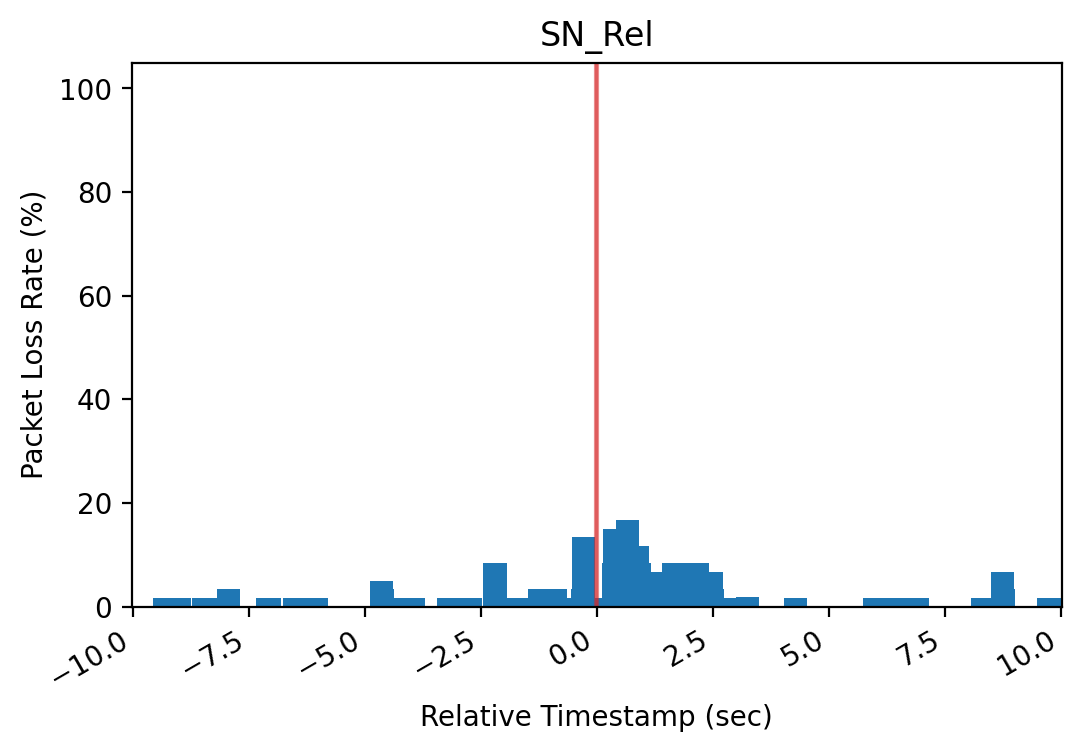

SN_Setup
Avg Duration: 0.02776141 seconds
HO Count: 284


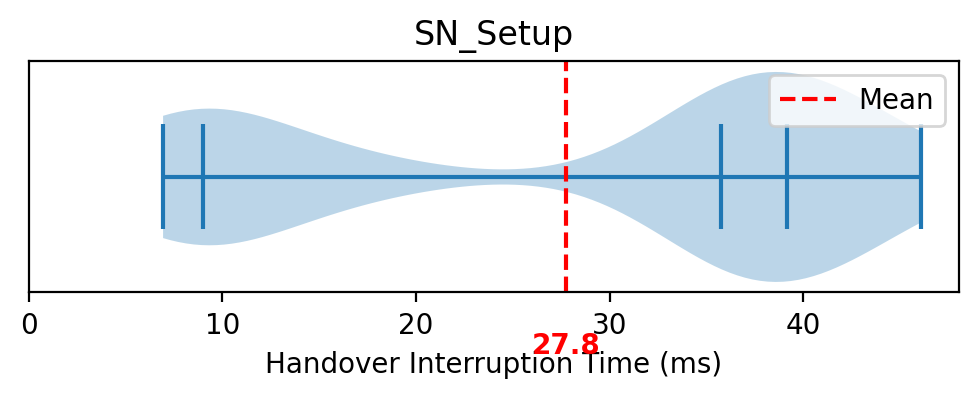

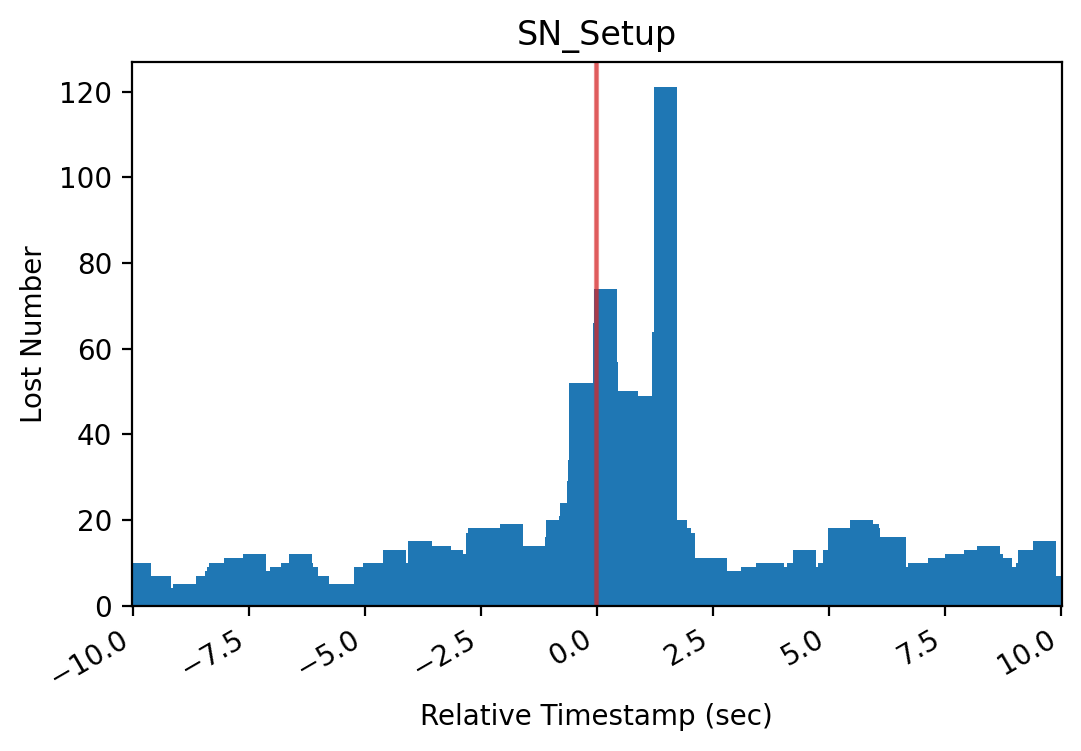

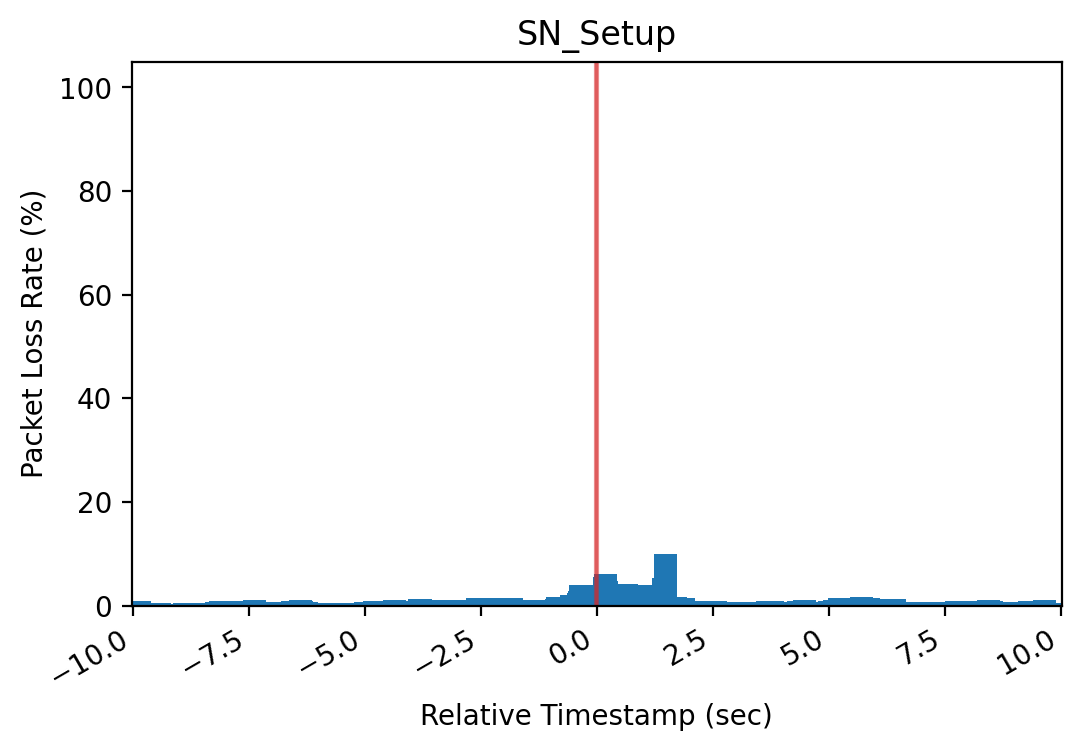

SN_Rel_MN_HO
Avg Duration: 0.01653786 seconds
HO Count: 405


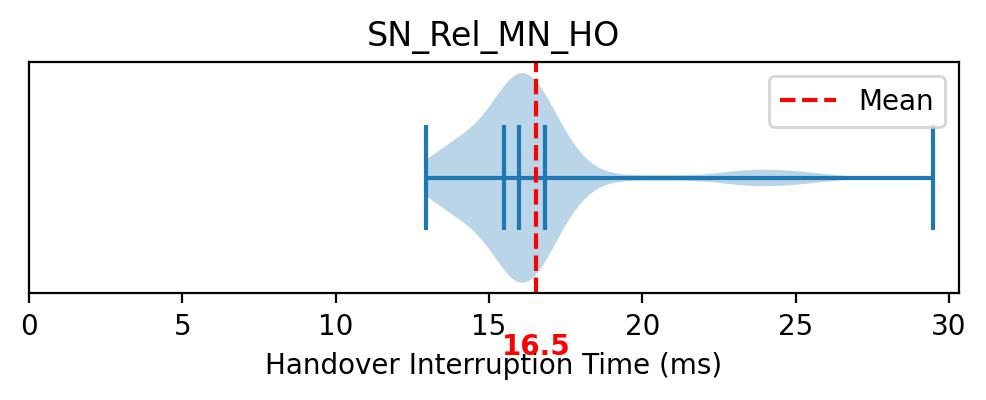

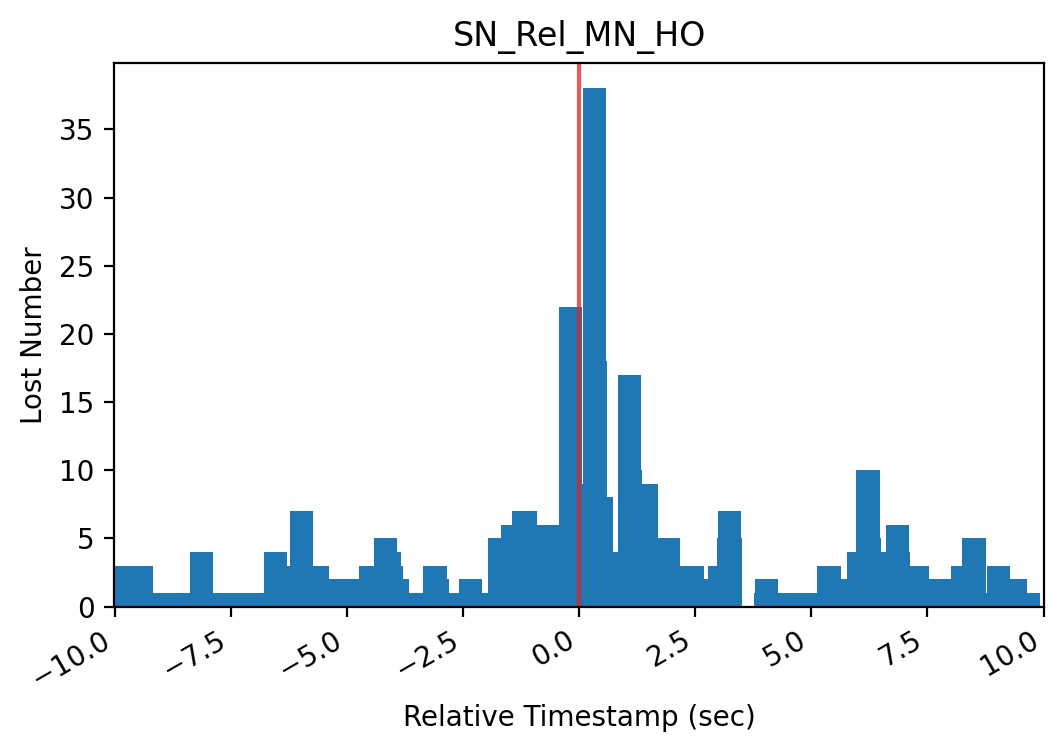

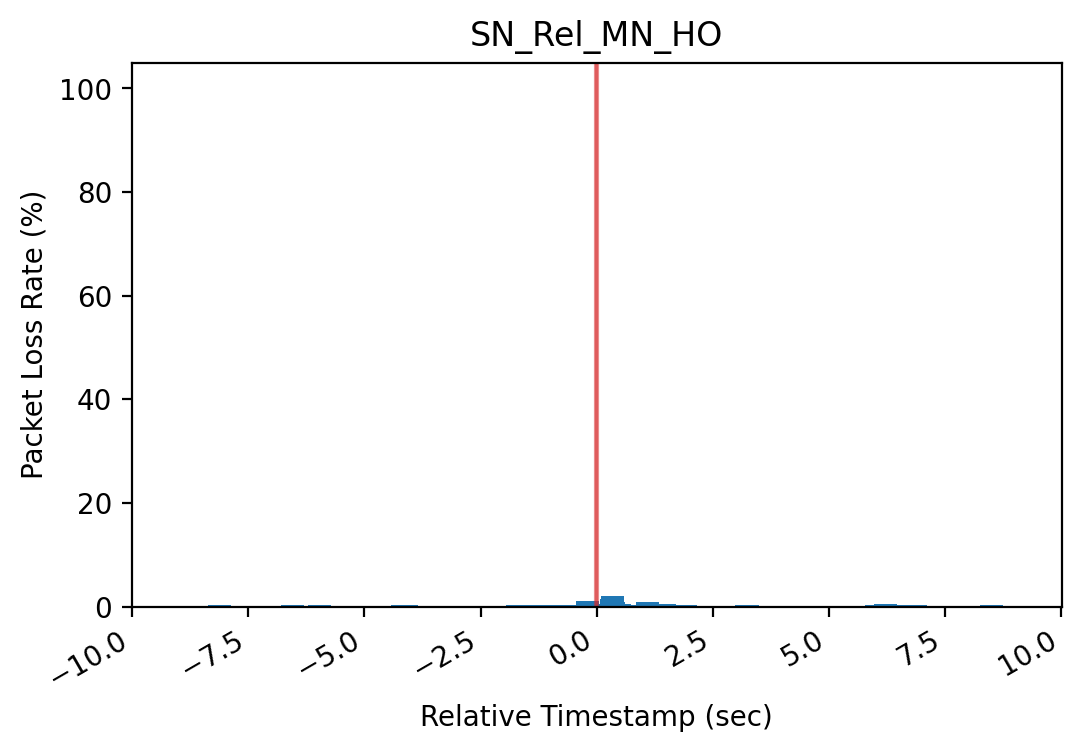

SCG_Failure_t310-Expiry (0)
Avg Duration: 0.0 seconds
HO Count: 3


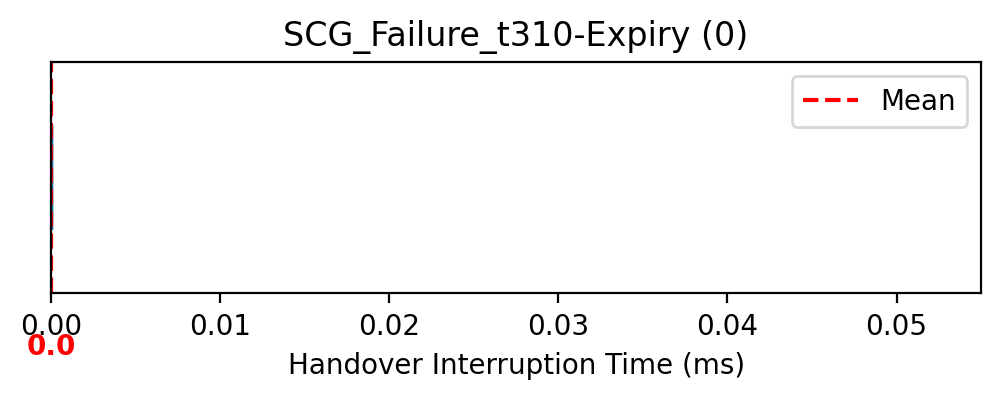

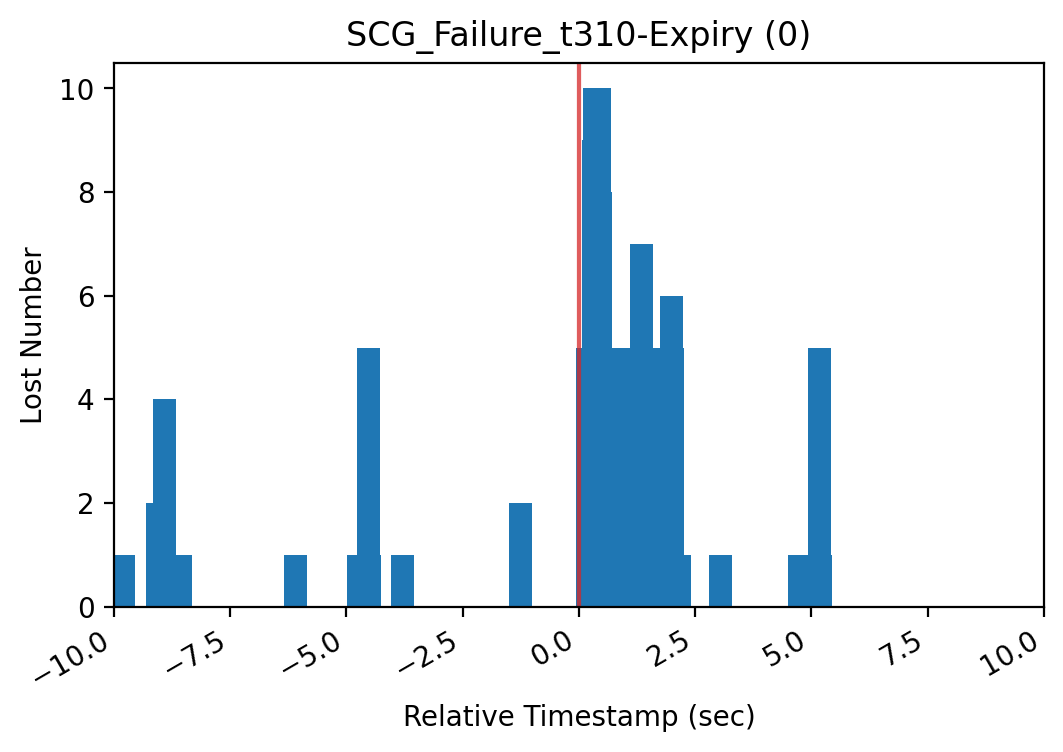

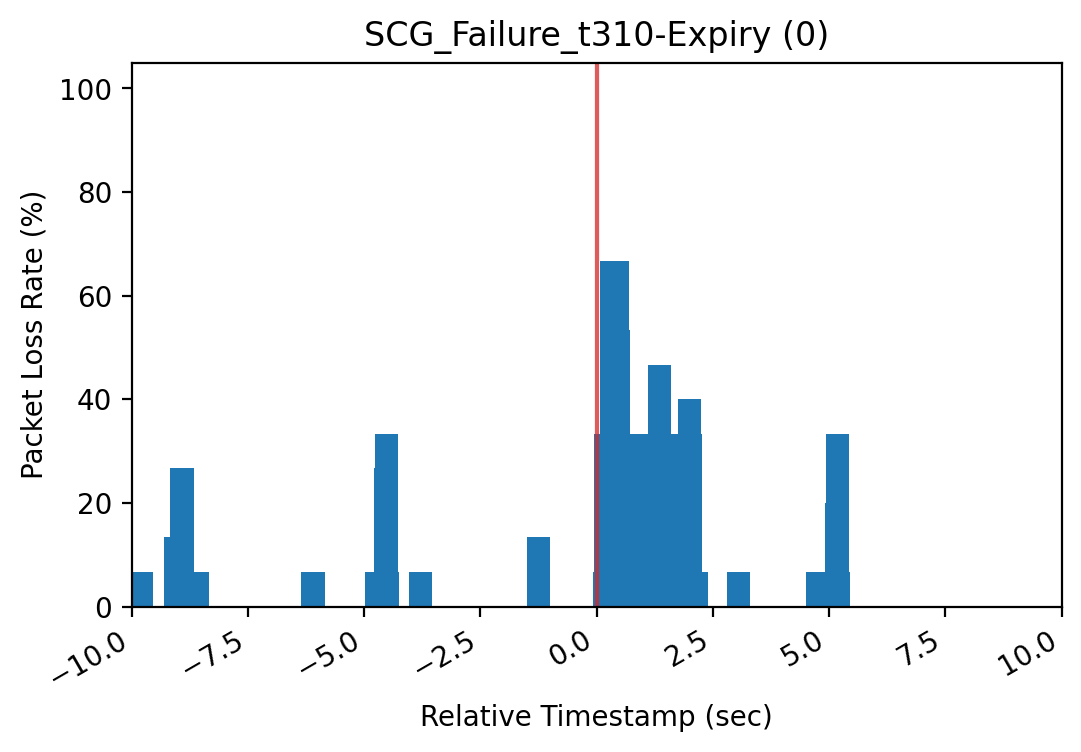

SCG_Failure_synchReconfigFailureSCG (3)
Avg Duration: 0.0 seconds
HO Count: 8


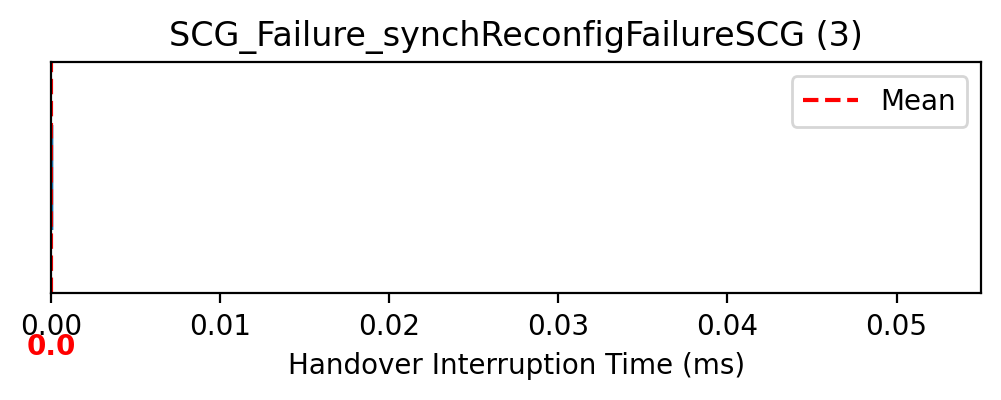

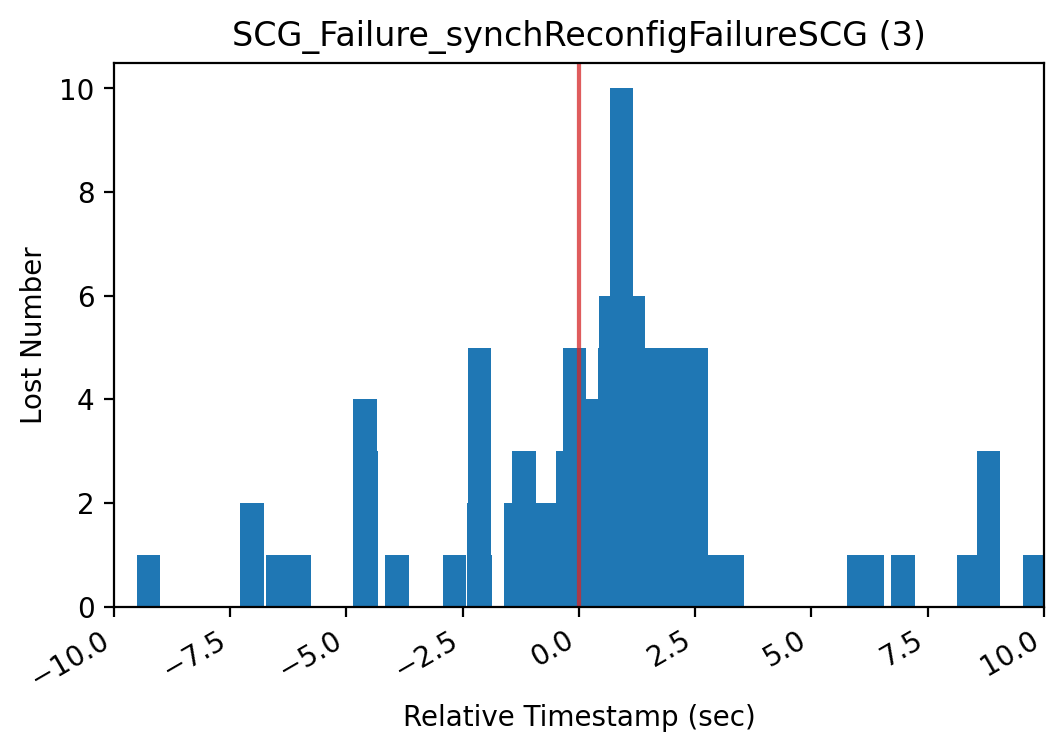

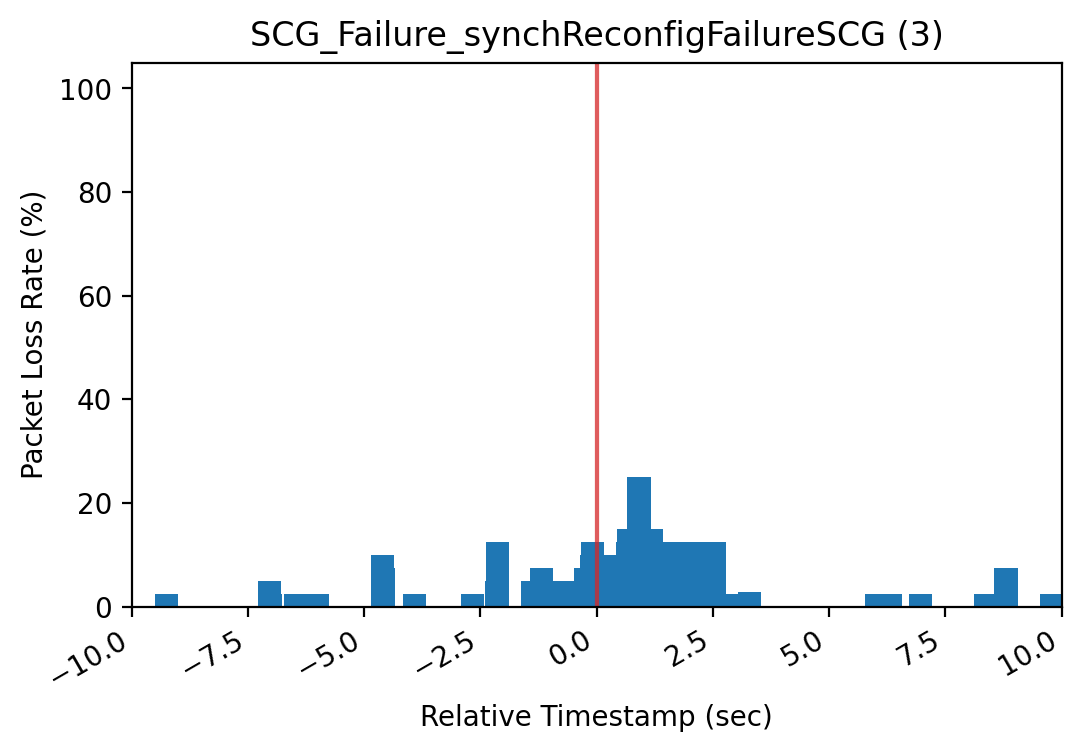

MCG_Failure_handoverFailure (1)
Avg Duration: 0.0808181 seconds
HO Count: 11


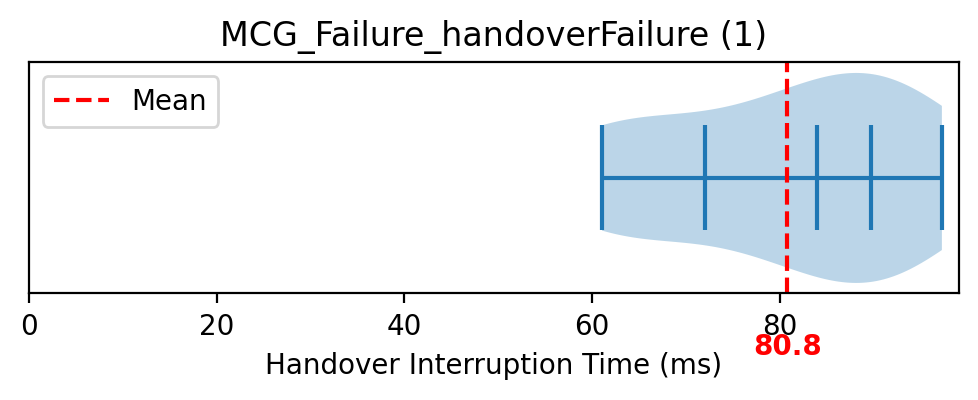

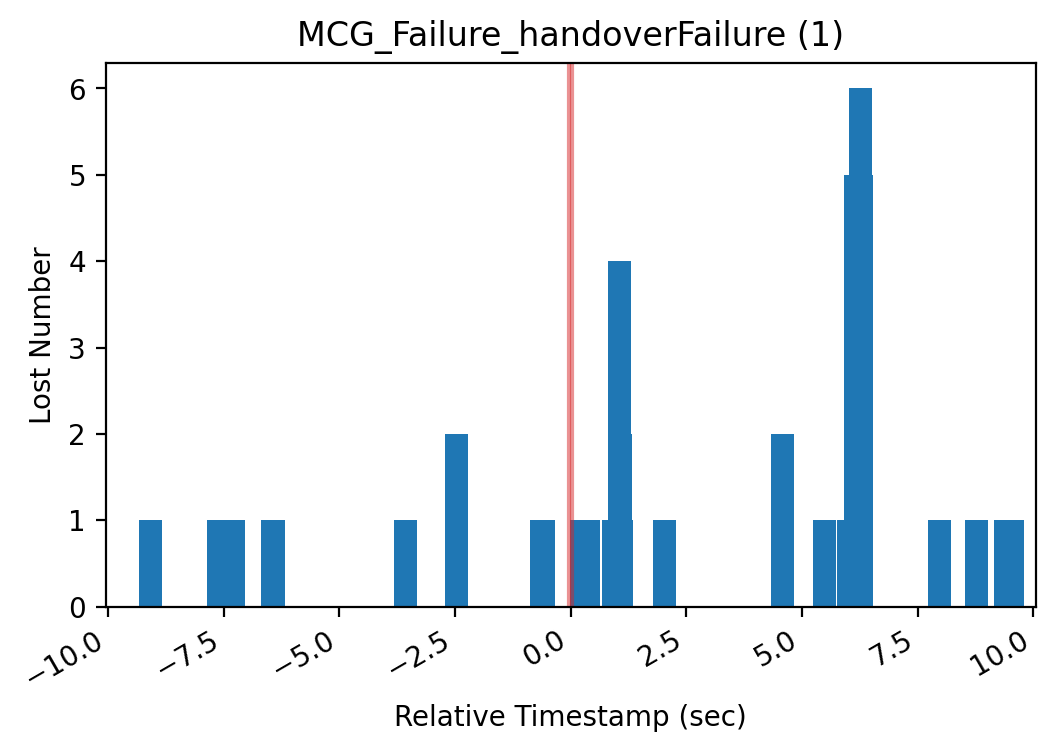

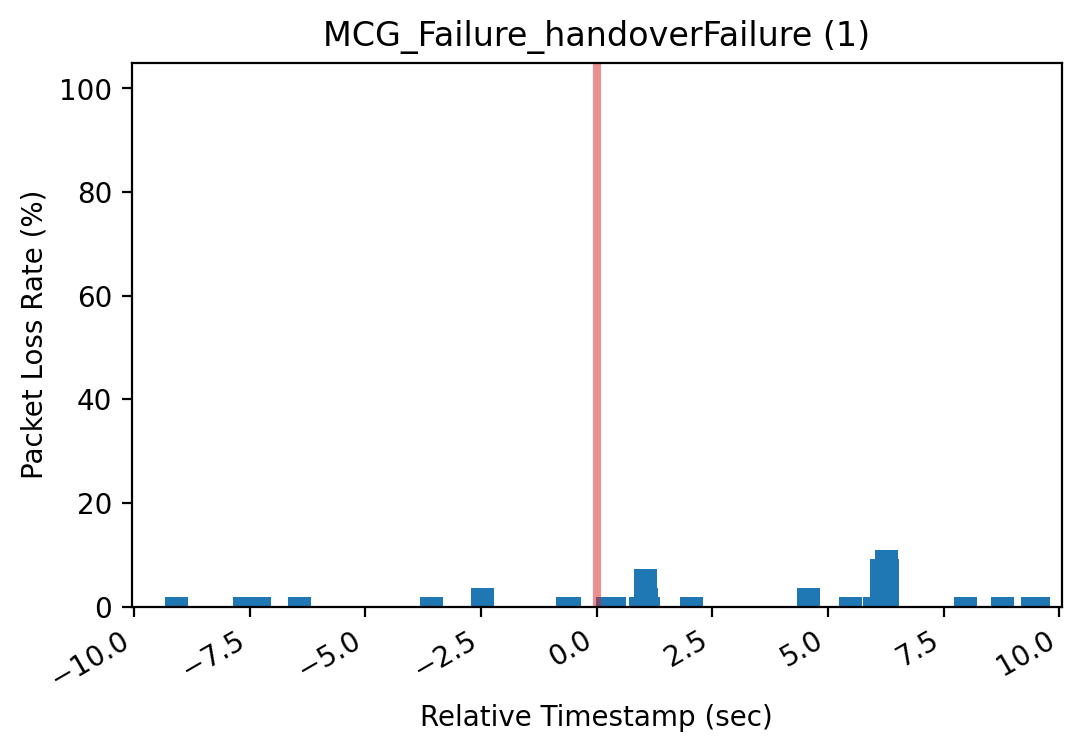

MCG_Failure_otherFailure (2)
Avg Duration: 0.07740378 seconds
HO Count: 118


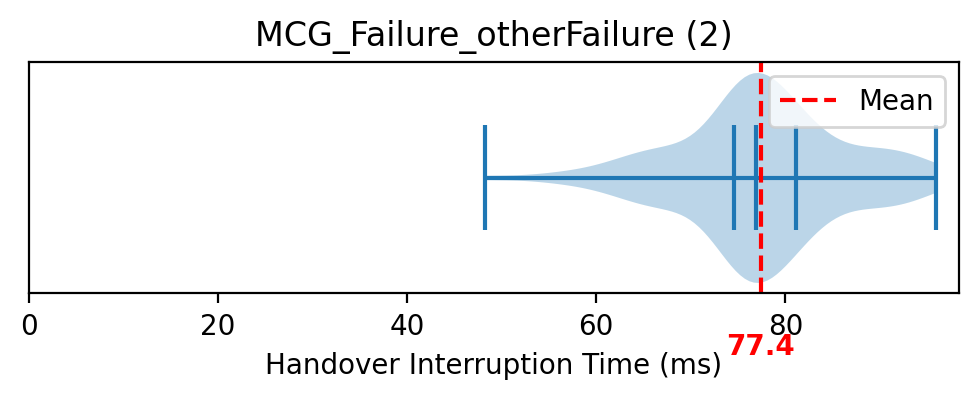

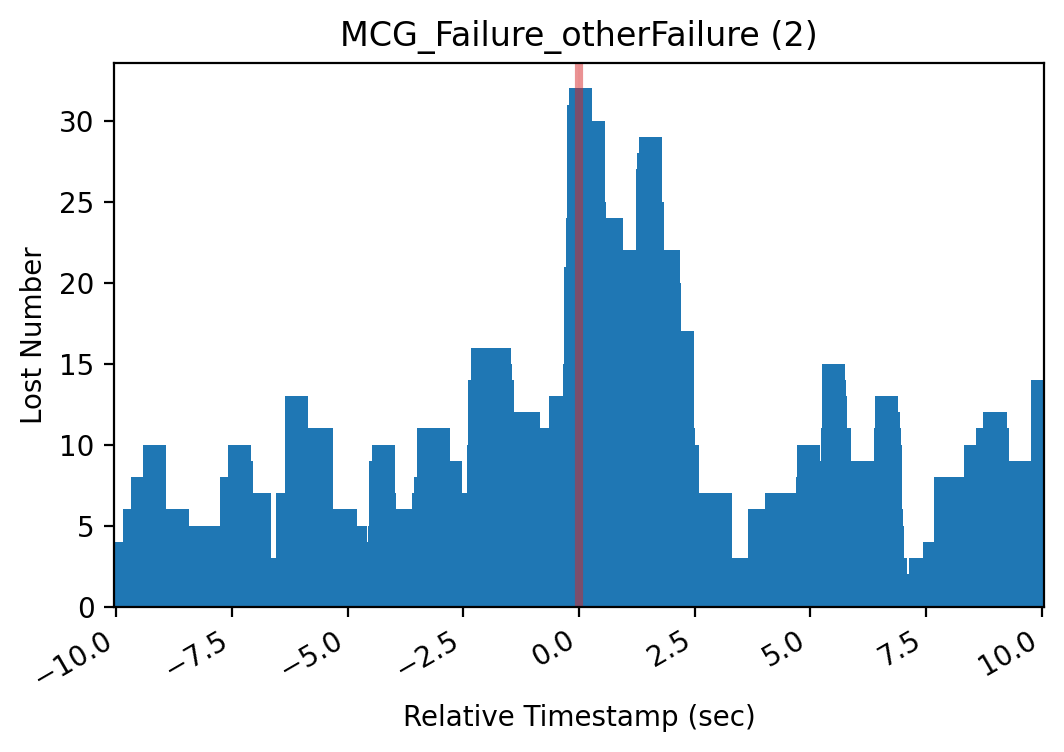

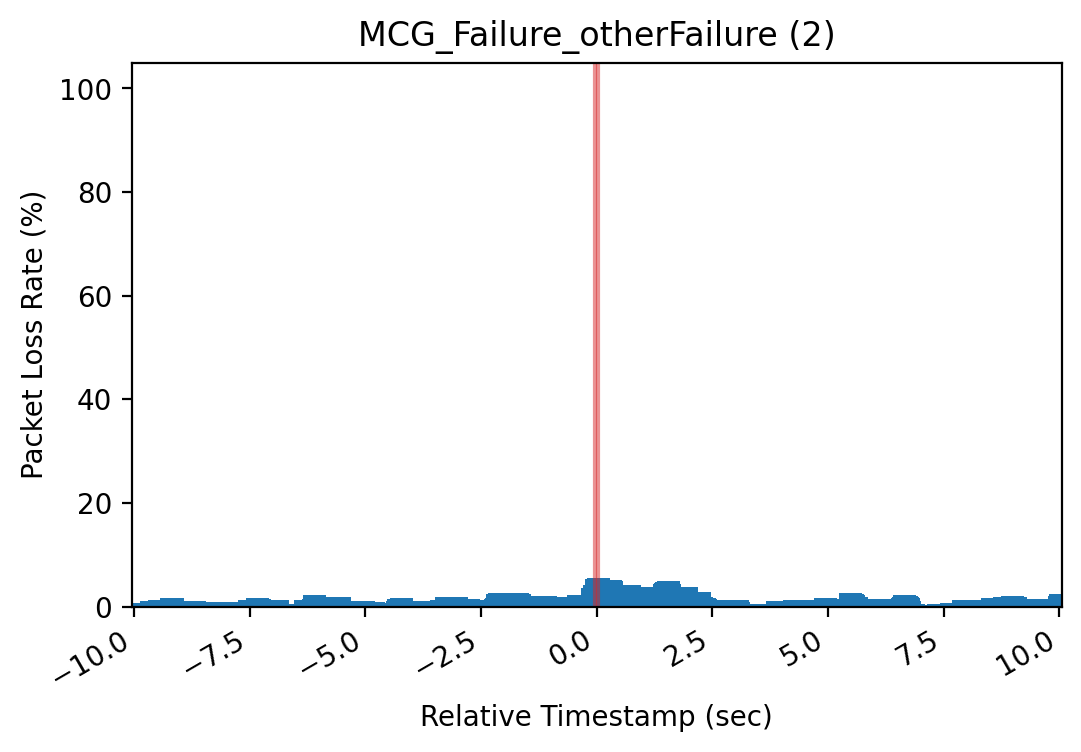

NAS_Recovery_otherFailure (2)
Avg Duration: 0.46772766 seconds
HO Count: 3


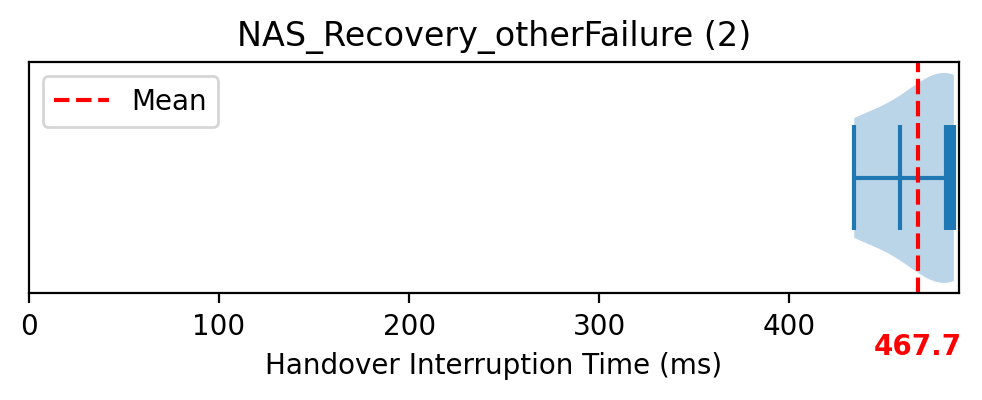

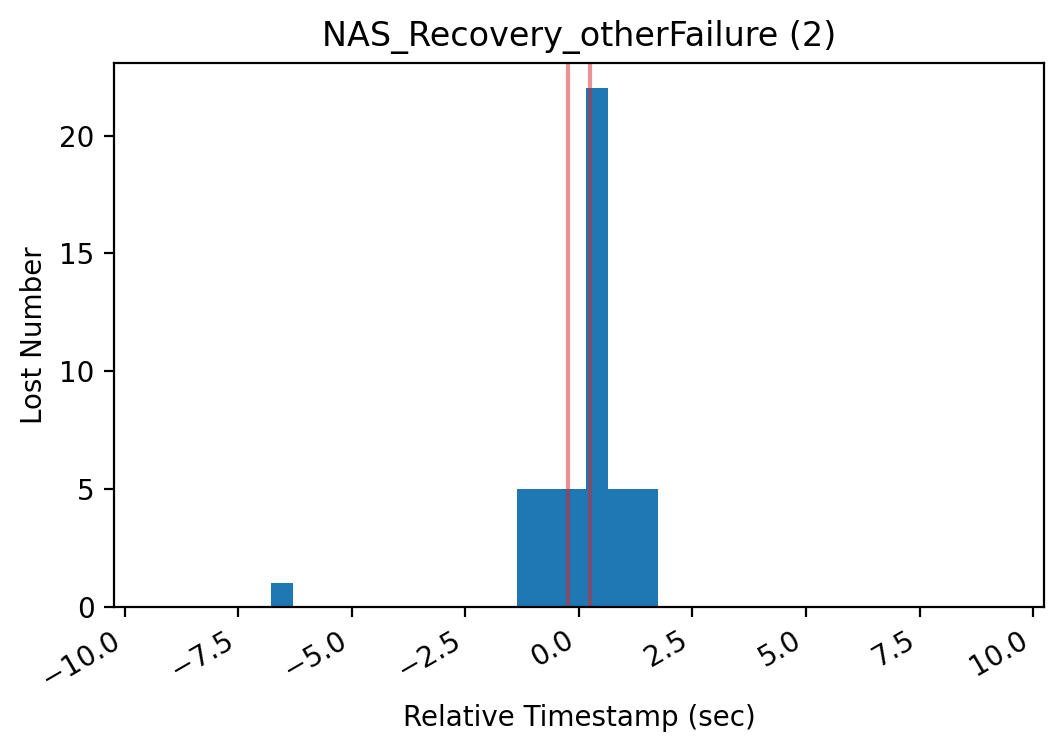

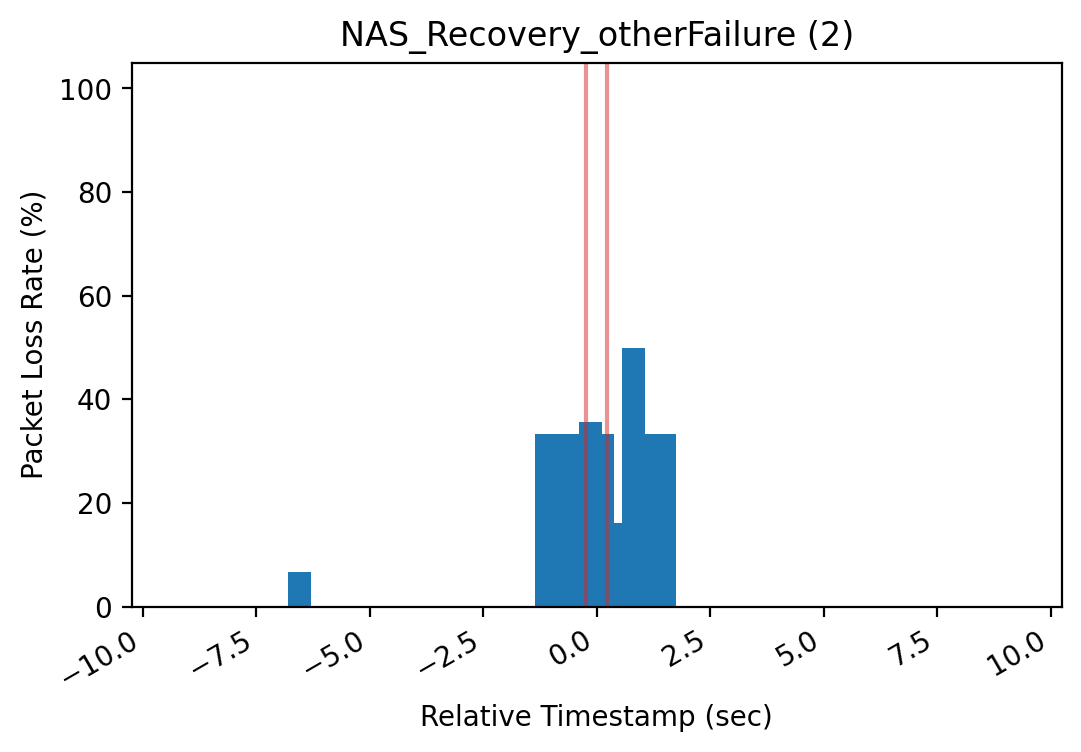

In [109]:
for tag in sorter:
    if len(D[tag]['intrs']) == 0:
        continue
    print('===================================')
    print(tag)
    table, intr = merge_profile(D[tag]['tables'], D[tag]['intrs'])
    print('Avg Duration:', intr, 'seconds')
    print('HO Count:', sum(D[tag]['count']))
    # display(table)
    plot_intrs(D[tag]['intrs'], tag)
    plot_profile(table, intr=intr, title=tag, mode='lost')
    plot_profile(table, intr=intr, title=tag, mode='plr')